In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_squared_error
import random
import optuna

In [4]:
def plot_numeric_distributions(df, numeric_columns):
    """
    Функция для построения гистограмм и boxplot для всех числовых переменных в DataFrame.
    
    Parameters:
    df (pd.DataFrame): DataFrame с данными.
    numeric_columns (list): Список числовых столбцов, для которых нужно построить графики.
    
    Returns:
    list: Список объектов matplotlib Figure для каждого графика.
    """
    
    # Устанавливаем стиль для графиков
    sns.set_theme(style="whitegrid")
    
    figures = []  # Список для хранения объектов Figure
    
    for col in numeric_columns:
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))

        # Гистограмма
        sns.histplot(df[col], bins=30, kde=True, ax=axes[0])
        axes[0].set_title(f'Histogram of {col}')
        axes[0].set_xlabel(col)
        axes[0].set_ylabel('Frequency')

        # Boxplot
        sns.boxplot(x=df[col], ax=axes[1])
        axes[1].set_title(f'Boxplot of {col}')
        axes[1].set_xlabel(col)
        
        figures.append(fig)  # Добавляем объект Figure в список

    return figures

In [5]:
def plot_categorical_columns(df):
    categorical_cols = list(df.select_dtypes(include=['object', 'category']).columns)
    categorical_cols.append('star_type')
    # Построение графиков для всех категориальных столбцов
    for col in categorical_cols:
        plt.figure(figsize=(10, 6))
        # Столбчатая диаграмма
        sns.countplot(y=df[col], order=df[col].value_counts().index)
        plt.title(f'Распределение {col}')
        plt.xlabel('Количество')
        plt.ylabel(col)
        plt.show()
        # Круговая диаграмма
        plt.figure(figsize=(8, 8))
        df[col].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, cmap='Set3')
        plt.title(f'Распределение {col} (круговая диаграмма)')
        plt.ylabel('')
        plt.show()

In [6]:
def clean_star_colors(data):
    # Удаление лишних пробелов, приведение значений столбца 'star_color' к нижнему регистру и замена дефисов и пробелов для устранения дубликатов
    data['star_color'] = data['star_color'].str.strip().str.lower().str.replace(r'[-\s]+', ' ', regex=True)
    
    # Объединение категорий звёздных цветов
    data['star_color'] = data['star_color'].replace({
        'blue-white': 'blue-white',
        'blue white': 'blue-white',
        'yellowish': 'yellow',
        'yellow white': 'yellow-white',
        'yellowish white': 'yellow-white',
        'white yellow': 'yellow-white',
        'white': 'white',
        'pale yellow orange': 'red',
        'orange red':'red',
        'orange':'red',
        'whitish': 'white'
    })
    
    return data


In [ ]:
# # Функция для генерации полиномиальных и взаимодействующих фичей
# def generate_poly_features(data, numerical_features, degree=2):
#     """
#     Генерация полиномиальных и взаимодействующих признаков для числовых фичей.
#     Параметры:
#         data (DataFrame): исходные данные
#         numerical_features (list): список имен числовых признаков, для которых нужно создать полиномиальные признаки
#         degree (int): степень полинома (по умолчанию 2)
    
#     Возвращает:
#         DataFrame: исходный DataFrame с добавленными новыми признаками
#     """
#     # Извлекаем числовые признаки
#     num_data = data[numerical_features]
#     # Создаем экземпляр PolynomialFeatures для создания полиномиальных и взаимодействующих признаков
#     poly = PolynomialFeatures(degree=degree, include_bias=False)
#     # Трансформируем числовые признаки в полиномиальные и взаимодействующие
#     poly_features = poly.fit_transform(num_data)
#     # Формируем имена новых признаков
#     poly_feature_names = poly.get_feature_names(numerical_features)
#     # Создаем DataFrame для новых признаков
#     poly_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=data.index)
#     # Объединяем исходный DataFrame с новыми признаками
#     data = pd.concat([data, poly_df], axis=1)
#     return data


In [ ]:
data = pd.read_csv('/datasets/6_class.csv')

In [9]:
data.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red


In [10]:
data = data.rename(columns={'Temperature (K)':'temperature', 
                            'Luminosity(L/Lo)':'luminosity','Radius(R/Ro)':'radius',
                            'Absolute magnitude(Mv)':'magnitude','Star type':'star_type',
                            'Star color':'star_color'})

In [11]:
data.head()

,temperature,luminosity,radius,magnitude,star_type,star_color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  240 non-null    int64  
 1   luminosity   240 non-null    float64
 2   radius       240 non-null    float64
 3   magnitude    240 non-null    float64
 4   star_type    240 non-null    int64  
 5   star_color   240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 11.4+ KB


In [13]:
data.describe()

,temperature,luminosity,radius,magnitude,star_type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


In [14]:
data['star_color'].value_counts()

Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
Yellowish White         3
white                   3
Blue white              3
yellowish               2
Whitish                 2
Orange                  2
Blue                    1
Orange-Red              1
Blue white              1
Pale yellow orange      1
Blue-White              1
White-Yellow            1
Yellowish               1
Name: star_color, dtype: int64

In [15]:
data = clean_star_colors(data)

In [16]:
numerical_features = ['luminosity', 'radius', 'magnitude']

In [17]:
data['star_color'].value_counts()

red             116
blue             56
blue-white       41
yellow-white     12
white            12
yellow            3
Name: star_color, dtype: int64

In [18]:
# Добавляем относительные величины
data['luminosity_relative'] = data['luminosity'] / 3.828e26
data['radius_relative'] = data['radius'] / 6.9551e8

# Добавляем индексы, чтобы уменьшить корреляцию между признаками
data['luminosity_radius_index'] = data['luminosity_relative'] / (data['radius_relative'] ** 2)
data['temperature_luminosity_index'] = (data['temperature'] ** 4) / data['luminosity_relative']

In [19]:
# Логарифмирование количественных данных, чтобы сжать распределение
log_transform_cols = ['temperature','luminosity_relative','radius_relative','luminosity_radius_index','temperature_luminosity_index']

In [20]:
for col in log_transform_cols:
    data[col] = np.log1p(data[col])

In [21]:
data

,temperature,luminosity,radius,magnitude,star_type,star_color,luminosity_relative,radius_relative,luminosity_radius_index,temperature_luminosity_index
0,8.029107,0.002400,0.1700,16.12,0,red,6.269592e-30,2.444250e-10,1.049417e-10,99.356966
1,8.020599,0.000500,0.1542,16.60,0,red,1.306165e-30,2.217078e-10,2.657272e-11,100.891539
2,7.863651,0.000300,0.1020,18.70,0,red,7.836991e-31,1.466550e-10,3.643810e-11,100.774350
3,7.937732,0.000200,0.1600,16.65,0,red,5.224660e-31,2.300470e-10,9.872448e-12,101.476247
4,7.570443,0.000138,0.1030,20.06,0,red,3.605016e-31,1.480928e-10,1.643764e-11,100.377522
...,...,...,...,...,...,...,...,...,...,...
235,10.569803,374830.000000,1356.0000,-9.93,5,blue,9.791797e-22,1.949647e-06,2.576023e-10,90.654436
236,10.336568,834042.000000,1194.0000,-10.63,5,blue,2.178793e-21,1.716724e-06,7.392887e-10,88.921657
237,9.085910,537493.000000,1423.0000,-10.73,5,white,1.404109e-21,2.045979e-06,3.354269e-10,84.358072
238,9.130864,404940.000000,1112.0000,-11.23,5,white,1.057837e-21,1.598825e-06,4.138242e-10,84.821084


In [22]:
data = data.drop(columns=['luminosity', 'radius','magnitude'])

## Изменения в фичах

### 1. Удаление старых признаков
- **Удалены первоначальные численные признаки**:
  - `luminosity`
  - `radius`
  - `magnitude`

### 2. Логарифмирование признаков
- Применено логарифмирование к числовым признакам с помощью функции `log1p` для сглаживания распределения и уменьшения разброса значений. Логарифмированы следующие признаки:
  - `temperature`
  - `luminosity`
  - `radius`
  - `magnitude`

### 3. Создание новых признаков
- Созданы новые признаки, чтобы уменьшить корреляцию между имеющимися и предоставить дополнительные полезные данные для модели:
  - **Относительная светимость (`luminosity_relative`)**: светимость звезды относительно светимости Солнца (L / L₀).
  - **Относительный радиус (`radius_relative`)**: радиус звезды относительно радиуса Солнца (R / R₀).
  - **Индекс светимости-радиуса (`luminosity_radius_index`)**: произведение логарифмов светимости и радиуса для выделения их взаимодействий.
  - **Индекс температуры-светимости (`temperature_luminosity_index`)**: произведение логарифмов температуры и светимости для выделения их взаимодействий.



[<Figure size 1400x600 with 2 Axes>,
 <Figure size 1400x600 with 2 Axes>,
 <Figure size 1400x600 with 2 Axes>,
 <Figure size 1400x600 with 2 Axes>,
 <Figure size 1400x600 with 2 Axes>]

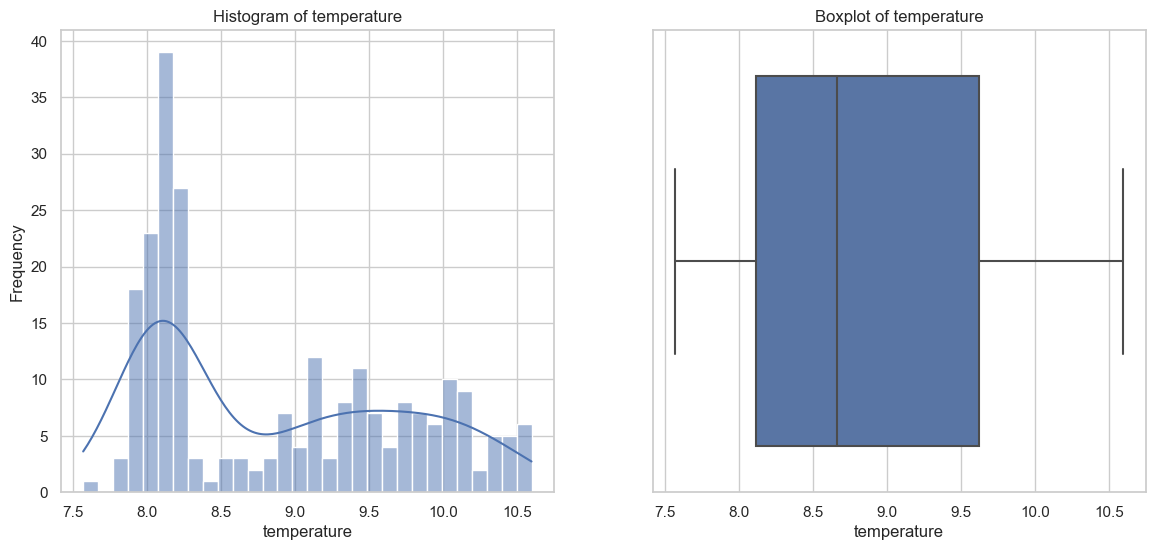

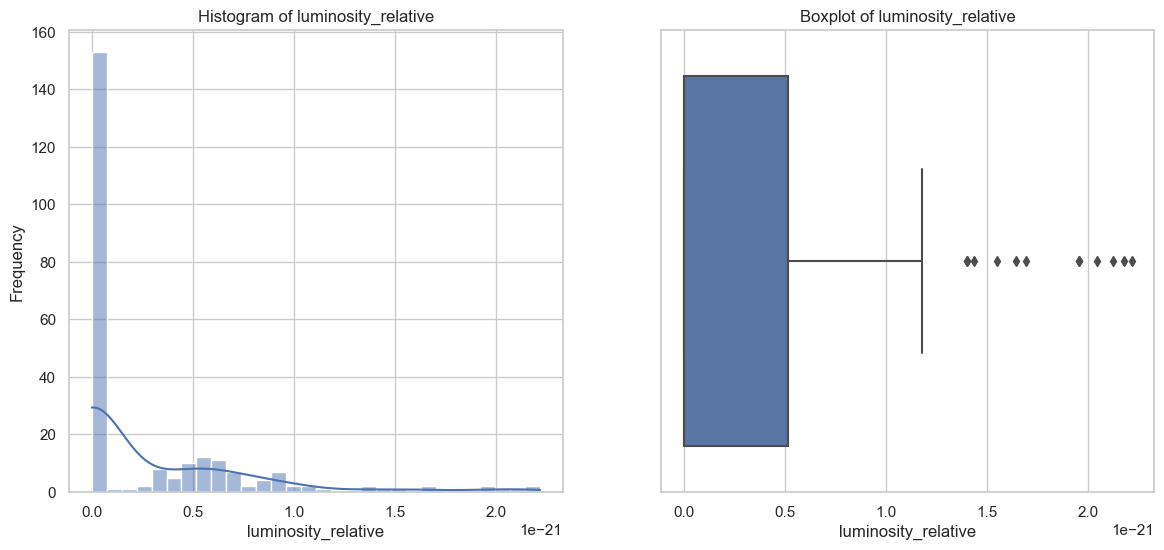

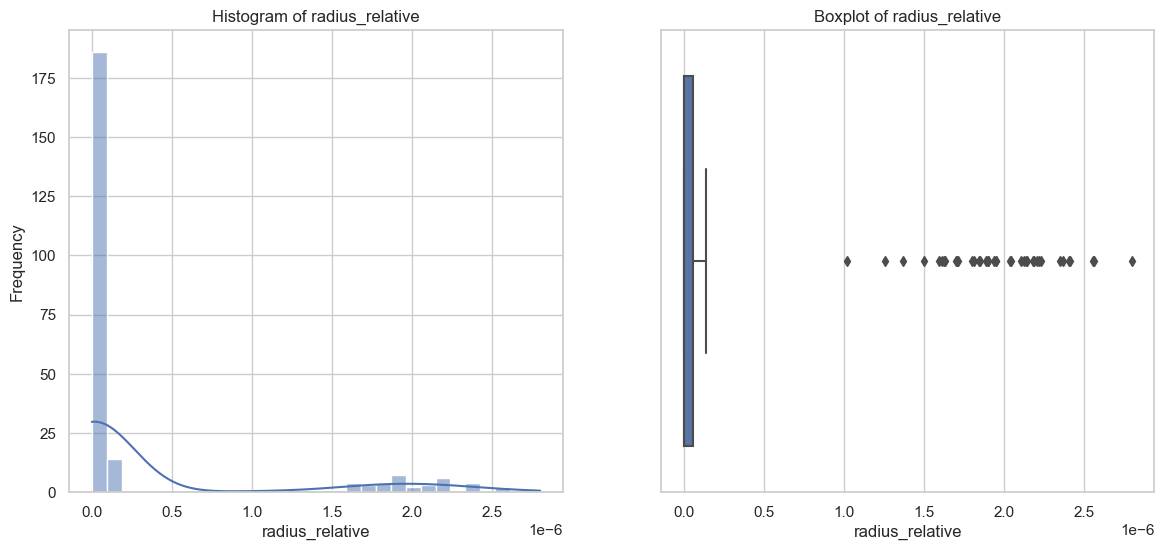

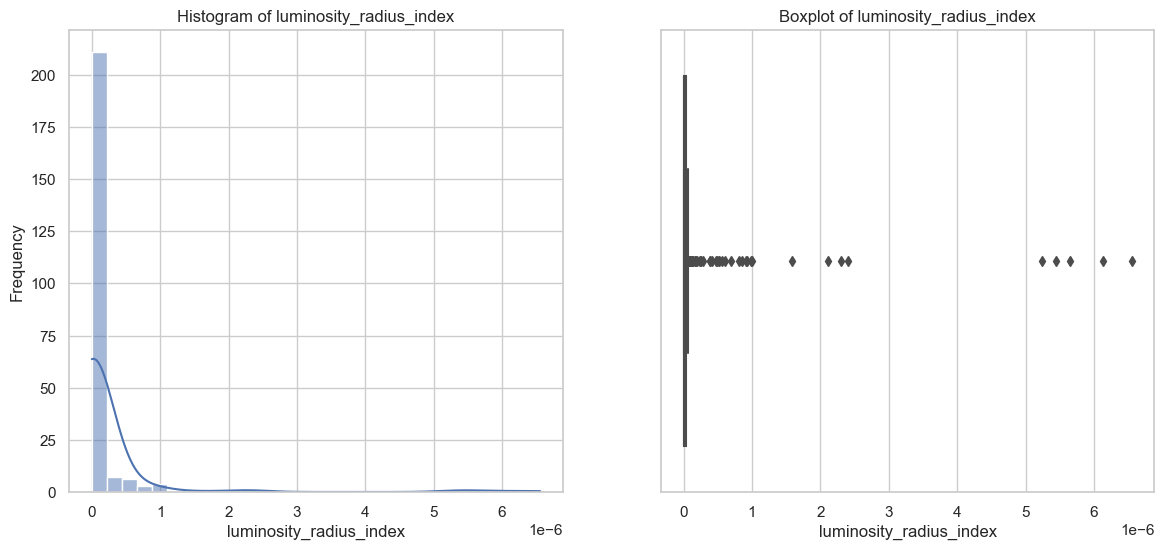

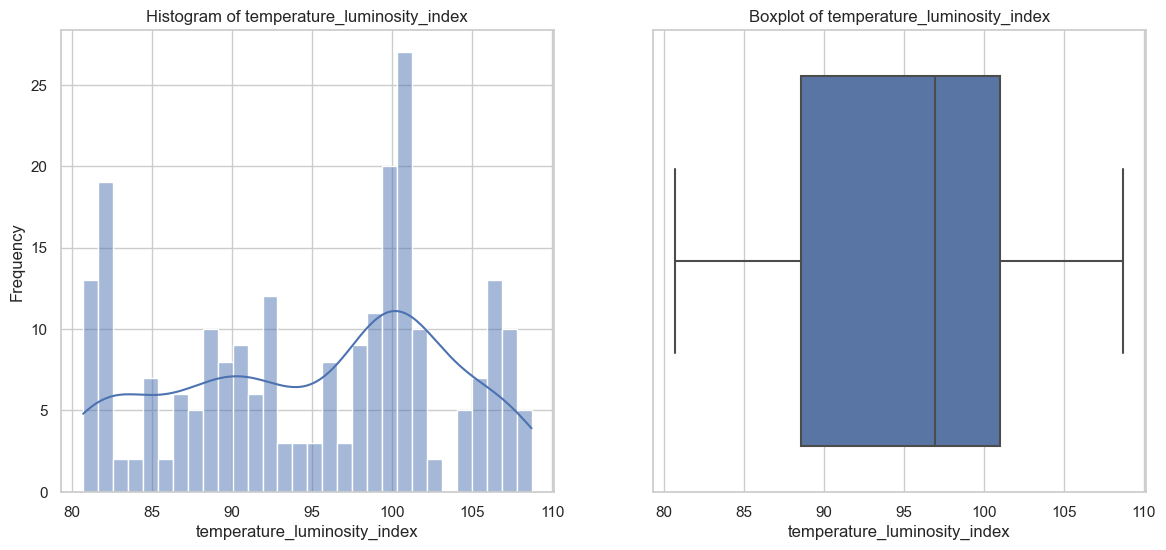

In [23]:
plot_numeric_distributions(data,log_transform_cols)

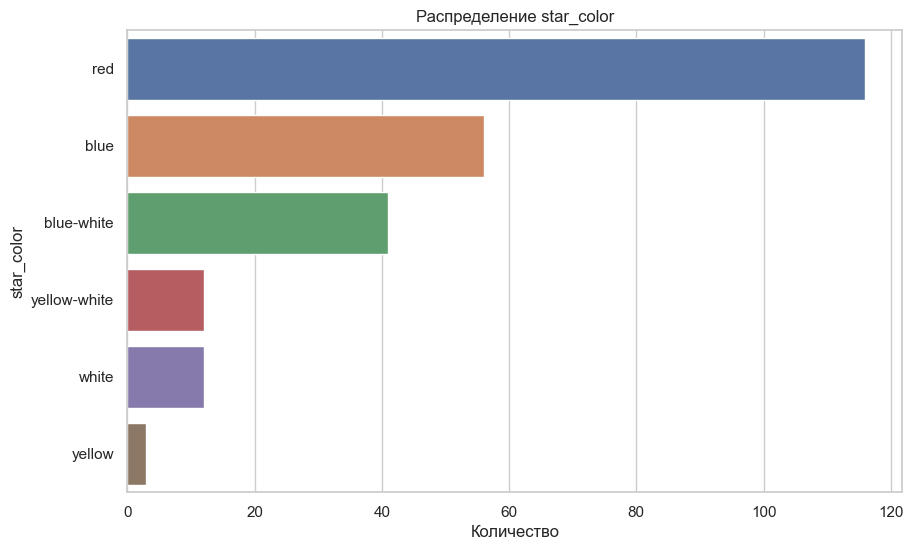

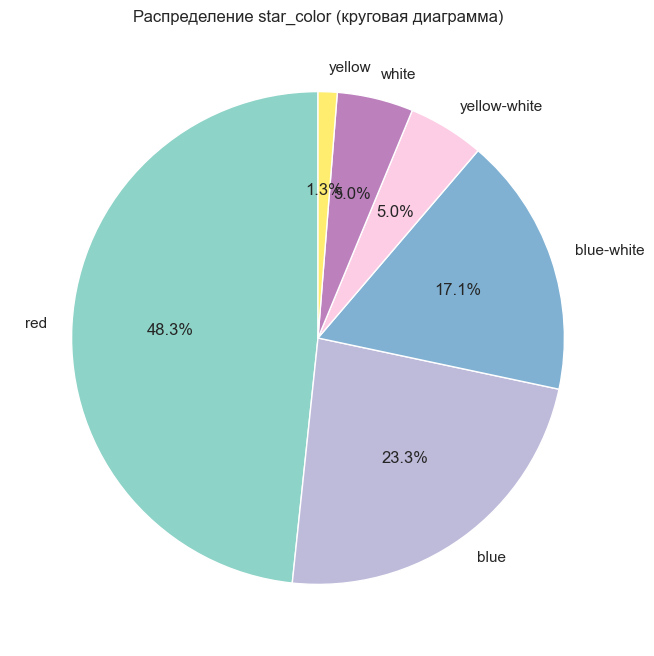

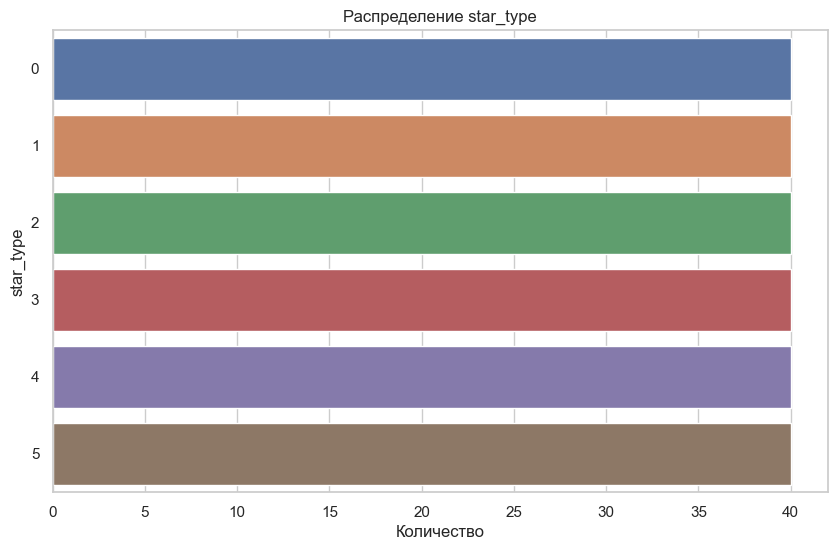

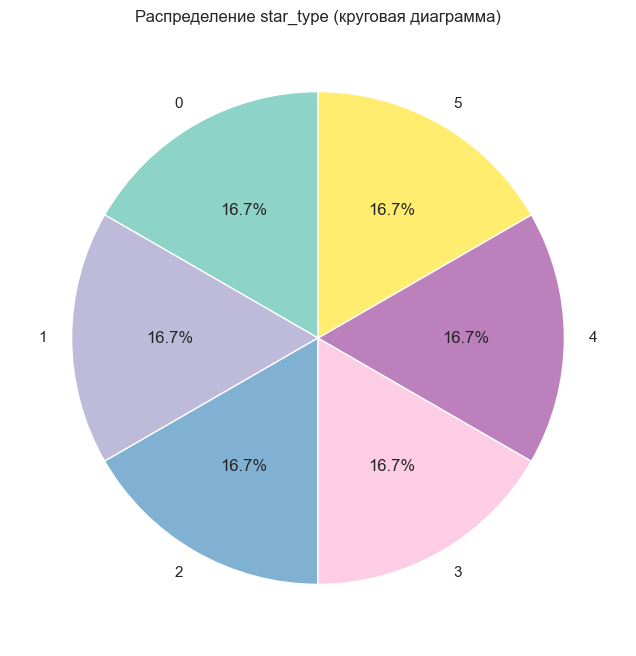

In [24]:
plot_categorical_columns(data)

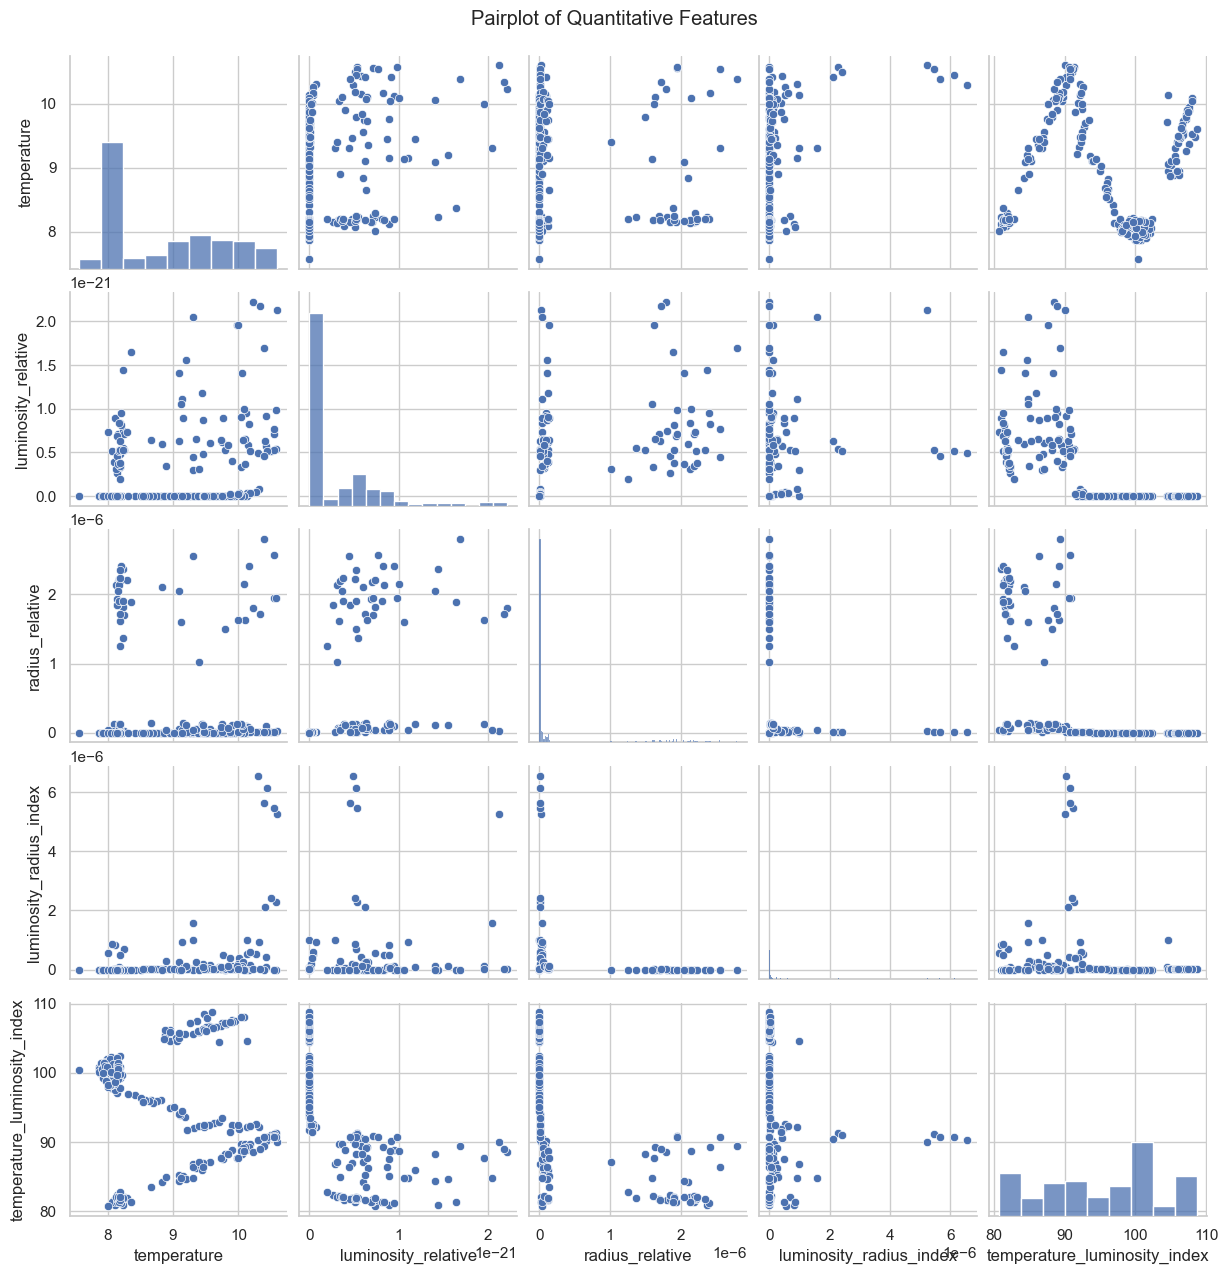

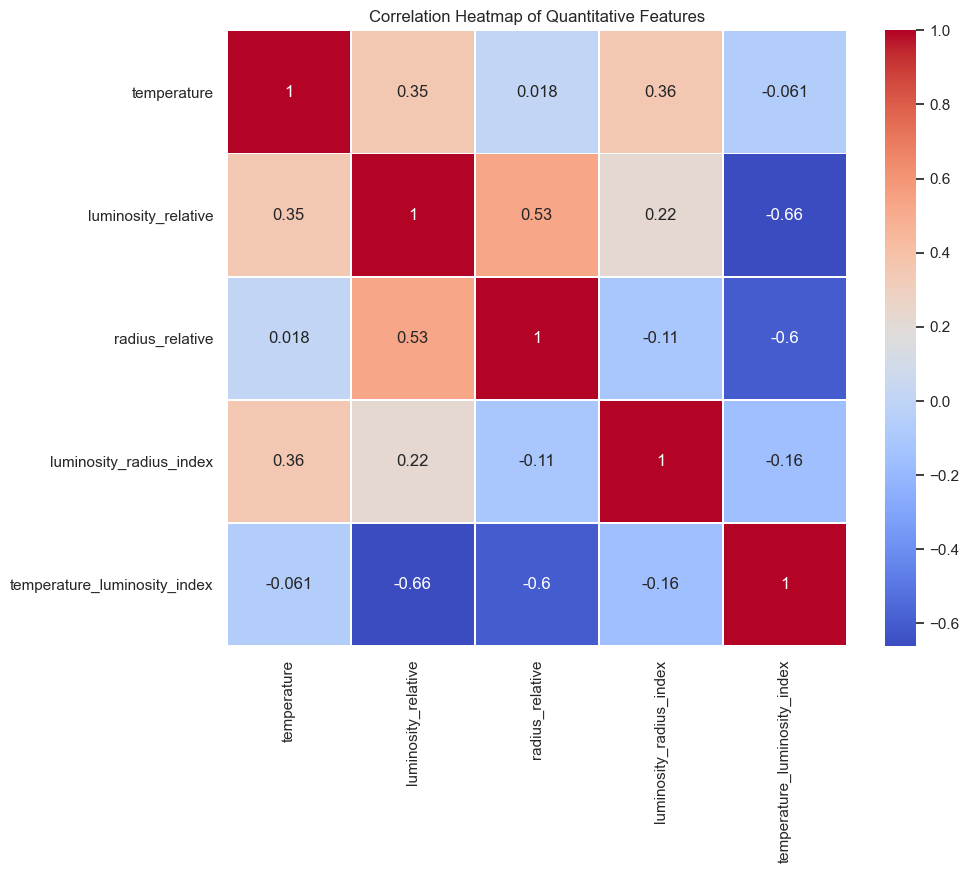

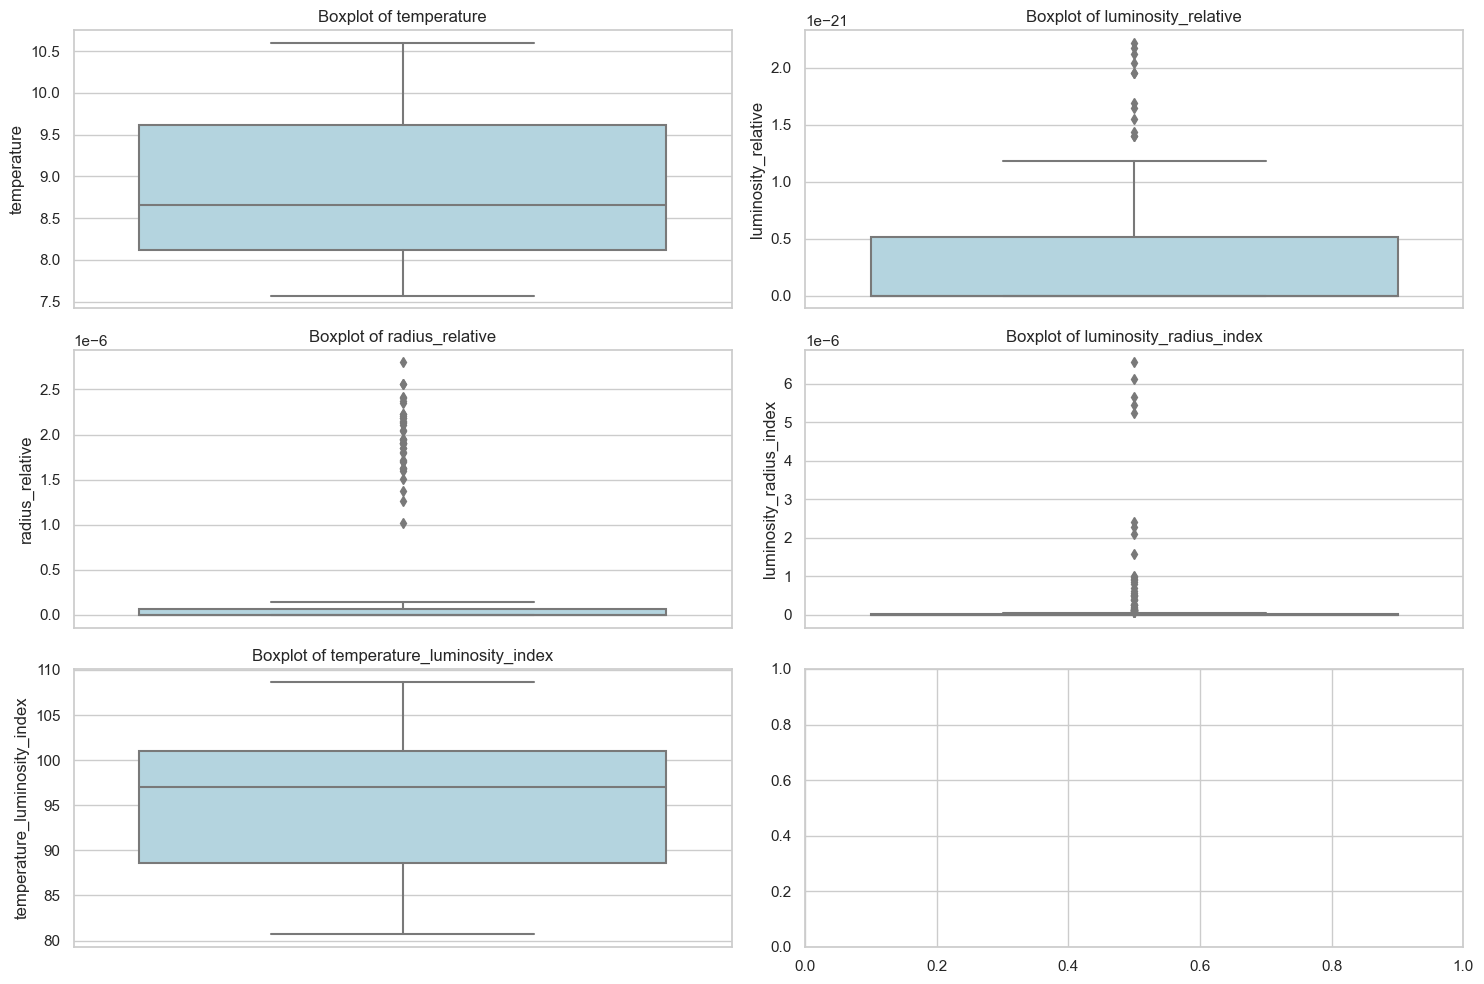

In [25]:
quantitative_cols = log_transform_cols
sns.pairplot(data[quantitative_cols], diag_kind='hist', palette='husl')
plt.suptitle('Pairplot of Quantitative Features', y=1.02)
plt.show()

# Correlation heatmap to examine relationships between features
plt.figure(figsize=(10, 8))
sns.heatmap(data[quantitative_cols].corr(), annot=True, cmap='coolwarm', linewidths=0.5, linecolor='white')
plt.title('Correlation Heatmap of Quantitative Features')
plt.show()

# Boxplots for each quantitative feature to detect outliers
fig, axes = plt.subplots(3, 2, figsize=(15, 10))

for i, col in enumerate(quantitative_cols):
    ax = axes[i//2, i%2]
    sns.boxplot(data=data, y=col, ax=ax, color='lightblue')
    ax.set_title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

## Выводы по графикам

### 1. Парные графики (Pairplot)
- **Temperature**: Температура имеет незначительную положительную корреляцию с `luminosity_relative` и `luminosity_radius_index`. Взаимодействие температуры с другими признаками не показывает выраженной зависимости.
- **Luminosity_relative**: Наблюдается умеренная корреляция с `radius_relative` и `temperature`. Взаимодействие с другими признаками показывает довольно размытые кластеры, что может свидетельствовать о слабой связи.
- **Radius_relative**: Показывает слабую корреляцию с другими признаками, что свидетельствует об их низкой зависимости.
- **Luminosity_radius_index** и **Temperature_luminosity_index**: Отмечается низкая корреляция с другими признаками, что подтверждает возможность их использования для уменьшения мультиколлинеарности и улучшения предсказательной способности модели.

### 2. Тепловая карта корреляции (Heatmap)
- **Корреляция между признаками** стала значительно ниже после применения логарифмирования и создания относительных признаков.
- Наиболее выраженная корреляция наблюдается между `luminosity_relative` и `radius_relative` (0.53), а также между `temperature` и `luminosity_radius_index` (0.36). Эти значения не превышают порога сильной корреляции, что свидетельствует о сбалансированности новых признаков.
- **Temperature_luminosity_index** показывает обратную корреляцию с `luminosity_relative` (-0.66) и `radius_relative` (-0.6), что может помочь модели выявить более сложные зависимости между признаками.

### 3. Ящик с усами (Boxplot)
- **Temperature**: Значения температуры распределены относительно равномерно, хотя наблюдаются некоторые выбросы в низких значениях.
- **Luminosity_relative, Radius_relative, Luminosity_radius_index**: Наблюдаются выраженные выбросы, что может свидетельствовать о редких, но значимых данных в контексте рассматриваемой выборки.
- **Temperature_luminosity_index**: Значения индекса варьируются в довольно узком диапазоне, что свидетельствует о сравнительно стабильном взаимодействии между температурой и светимостью.



# Категоризация данных

In [26]:
# Разделение на обучающую и тестовую выборки
train_data, test_data = train_test_split(data, test_size=0.2, random_state=27)

In [27]:
train_data['star_color'].unique()

array(['red', 'blue', 'blue-white', 'yellow-white', 'white', 'yellow'],
      dtype=object)

In [28]:
# Для star_color используем One-Hot Encoding
one_hot_encoder = OneHotEncoder(sparse=False)

In [29]:
encoded_colors_train = one_hot_encoder.fit_transform(train_data[['star_color']])

In [30]:
enc_train = pd.DataFrame(encoded_colors_train, columns=one_hot_encoder.get_feature_names(['star_color']))

In [31]:
enc_train

,star_color_blue,star_color_blue-white,star_color_red,star_color_white,star_color_yellow,star_color_yellow-white
0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
187,0.0,0.0,1.0,0.0,0.0,0.0
188,0.0,1.0,0.0,0.0,0.0,0.0
189,0.0,0.0,1.0,0.0,0.0,0.0
190,0.0,0.0,1.0,0.0,0.0,0.0


In [32]:
# Объединение закодированных категориальных train данных с основным датафреймом
train_data_enc = train_data
train_data_enc[one_hot_encoder.get_feature_names(['star_color'])] = encoded_colors_train
train_data_enc = train_data_enc.drop(columns = ['star_color'])

C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\258611638.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_enc[one_hot_encoder.get_feature_names(['star_color'])] = encoded_colors_train
c:\Users\Maste\OneDrive\Документы\GitHub\starlights\env\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [33]:
train_data_enc

,temperature,star_type,luminosity_relative,radius_relative,luminosity_radius_index,temperature_luminosity_index,star_color_blue,star_color_blue-white,star_color_red,star_color_white,star_color_yellow,star_color_yellow-white
40,8.249836,4,5.224660e-22,2.731808e-08,7.000958e-07,82.001783,0.0,0.0,1.0,0.0,0.0,0.0
197,8.159661,1,3.265413e-30,4.830987e-10,1.399156e-11,100.531666,0.0,0.0,1.0,0.0,0.0,0.0
106,10.111761,4,9.482759e-22,9.058101e-08,1.155740e-07,88.854279,1.0,0.0,0.0,0.0,0.0,0.0
223,10.062242,4,1.403945e-21,1.164613e-07,1.035110e-07,88.263798,1.0,0.0,0.0,0.0,0.0,0.0
206,10.086684,2,4.153605e-30,1.825998e-11,1.245732e-08,108.000145,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
56,8.205492,5,9.482759e-22,2.405426e-06,1.638889e-10,81.228270,0.0,0.0,1.0,0.0,0.0,0.0
31,10.308986,3,7.533960e-23,9.058101e-09,9.182243e-07,92.175847,0.0,1.0,0.0,0.0,0.0,0.0
72,8.103192,1,2.220481e-29,2.588029e-10,3.315192e-10,98.388801,0.0,0.0,1.0,0.0,0.0,0.0
184,8.147288,0,1.622257e-30,1.111415e-10,1.313311e-10,101.181729,0.0,0.0,1.0,0.0,0.0,0.0


In [34]:
encoded_colors_test = one_hot_encoder.transform(test_data[['star_color']])

In [35]:
# Объединение закодированных категориальных test данных с основным датафреймом
test_data_enc = test_data
test_data_enc[one_hot_encoder.get_feature_names(['star_color'])] = encoded_colors_test
test_data_enc = test_data_enc.drop(columns = ['star_color'])

C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\1305620913.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_enc[one_hot_encoder.get_feature_names(['star_color'])] = encoded_colors_test
c:\Users\Maste\OneDrive\Документы\GitHub\starlights\env\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [36]:
test_data_enc

,temperature,star_type,luminosity_relative,radius_relative,luminosity_radius_index,temperature_luminosity_index,star_color_blue,star_color_blue-white,star_color_red,star_color_white,star_color_yellow,star_color_yellow-white
88,9.526683,2,4.702194e-31,1.282512e-11,2.858760e-09,107.938548,0.0,0.0,0.0,1.0,0.0,0.0
65,8.100465,0,2.560084e-30,1.897888e-10,7.107437e-11,100.538159,0.0,0.0,1.0,0.0,0.0,0.0
8,7.882692,0,1.802508e-30,1.581573e-10,7.206071e-11,100.017634,0.0,0.0,1.0,0.0,0.0,0.0
63,7.950150,0,8.881923e-31,1.319895e-10,5.098335e-11,100.995309,0.0,0.0,1.0,0.0,0.0,0.0
238,9.130864,5,1.057837e-21,1.598825e-06,4.138242e-10,84.821084,0.0,0.0,0.0,1.0,0.0,0.0
201,9.660205,2,3.187043e-30,1.639085e-11,1.186274e-08,106.559024,1.0,0.0,0.0,0.0,0.0,0.0
172,8.363576,5,1.645768e-21,1.890697e-06,4.603879e-10,81.309450,0.0,0.0,1.0,0.0,0.0,0.0
155,10.264687,3,4.386102e-23,9.201881e-09,5.179949e-07,92.539626,0.0,1.0,0.0,0.0,0.0,0.0
168,9.763306,4,8.957680e-22,4.313381e-08,4.814594e-07,87.517353,1.0,0.0,0.0,0.0,0.0,0.0
120,8.108924,0,1.123302e-30,1.311268e-10,6.533014e-11,101.395773,0.0,0.0,1.0,0.0,0.0,0.0


In [37]:
log_transform_cols.remove('temperature')

In [38]:
# Масштабирование количественных данных
quantitative_cols = log_transform_cols
scaler = StandardScaler()

In [39]:
log_transform_cols

['luminosity_relative',
 'radius_relative',
 'luminosity_radius_index',
 'temperature_luminosity_index']

In [40]:
# Обучающее масштабирование на тренировочных данных и применение на тестовых данных
train_data_enc[quantitative_cols] = scaler.fit_transform(train_data[quantitative_cols])
test_data_enc[quantitative_cols] = scaler.transform(test_data[quantitative_cols])

In [41]:
# Выводим данные для проверки
train_data_enc.head()

,temperature,star_type,luminosity_relative,radius_relative,luminosity_radius_index,temperature_luminosity_index,star_color_blue,star_color_blue-white,star_color_red,star_color_white,star_color_yellow,star_color_yellow-white
40,8.249836,4,0.550831,-0.409329,0.514882,-1.582516,0.0,0.0,1.0,0.0,0.0,0.0
197,8.159661,1,-0.601672,-0.445539,-0.258852,0.683415,0.0,0.0,1.0,0.0,0.0,0.0
106,10.111761,4,1.490121,-0.323965,-0.131134,-0.744557,1.0,0.0,0.0,0.0,0.0,0.0
223,10.062242,4,2.495277,-0.289043,-0.144467,-0.816764,1.0,0.0,0.0,0.0,0.0,0.0
206,10.086684,2,-0.601672,-0.446167,-0.245100,1.596700,1.0,0.0,0.0,0.0,0.0,0.0


In [42]:
test_data_enc.head()

,temperature,star_type,luminosity_relative,radius_relative,luminosity_radius_index,temperature_luminosity_index,star_color_blue,star_color_blue-white,star_color_red,star_color_white,star_color_yellow,star_color_yellow-white
88,9.526683,2,-0.601672,-0.446174,-0.255708,1.589168,0.0,0.0,0.0,1.0,0.0,0.0
65,8.100465,0,-0.601672,-0.445935,-0.258789,0.684209,0.0,0.0,1.0,0.0,0.0,0.0
8,7.882692,0,-0.601672,-0.445978,-0.258788,0.620557,0.0,0.0,1.0,0.0,0.0,0.0
63,7.950150,0,-0.601672,-0.446013,-0.258811,0.740112,0.0,0.0,1.0,0.0,0.0,0.0
238,9.130864,5,1.731801,1.711198,-0.258410,-1.237757,0.0,0.0,0.0,1.0,0.0,0.0


In [43]:
test_data_enc.columns

Index(['temperature', 'star_type', 'luminosity_relative', 'radius_relative',
       'luminosity_radius_index', 'temperature_luminosity_index',
       'star_color_blue', 'star_color_blue-white', 'star_color_red',
       'star_color_white', 'star_color_yellow', 'star_color_yellow-white'],
      dtype='object')

In [44]:
# Разделение признаков и меток
X_train = train_data_enc.drop(columns=['temperature'])
y_train = train_data_enc['temperature']
X_test = test_data_enc.drop(columns=['temperature'])
y_test = test_data_enc['temperature']

# Конвертация данных в тензоры PyTorch
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

Baseline model

In [45]:
class StarDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]
    
class StarTemperatureModelBaseline(nn.Module):
    def __init__(self, input_size, initial_hidden_layer_size=512, num_hidden_layers=4):
        super(StarTemperatureModelBaseline, self).__init__()
        layers = []
        current_layer_size = initial_hidden_layer_size
        layers.append(nn.Linear(input_size, current_layer_size))
        layers.append(nn.ReLU())
        
        for _ in range(num_hidden_layers - 1):
            next_layer_size = max(1, current_layer_size // 2)  # Размерность уменьшается вдвое на каждом слое
            layers.append(nn.Linear(current_layer_size, next_layer_size))
            layers.append(nn.ReLU())
            current_layer_size = next_layer_size
        
        layers.append(nn.Linear(current_layer_size, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [46]:
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = nn.MSELoss()
        loss = torch.sqrt(criterion(x, y))
        return loss

In [47]:
seed = 27
random.seed(seed)  # Для Python
np.random.seed(seed)  # Для NumPy
torch.manual_seed(seed)  # Для PyTorch (CPU)
torch.cuda.manual_seed(seed)  # Для PyTorch (GPU)
torch.backends.cudnn.deterministic = True  # Для детерминированности на GPU
torch.backends.cudnn.benchmark = False  # Отключение динамической оптимизации

In [48]:
# Функция для обучения модели
def train_model(model, train_loader, criterion, optimizer, num_epochs=50):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for features, targets in train_loader:  # Проходим по всем батчам из train_loader
            optimizer.zero_grad()  # Обнуляем градиенты
            outputs = model(features)  # Предсказания модели на текущем батче
            loss = criterion(outputs, targets.view(-1, 1))  # Вычисление потерь для текущего батча
            loss.backward()  # Обратное распространение ошибки
            optimizer.step()  # Обновление весов модели

            running_loss += loss.item()

        # Выводим потери в конце каждой эпохи
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

In [49]:
train_dataset = StarDataset(X_train_tensor, y_train_tensor)
test_dataset = StarDataset(X_test_tensor, y_test_tensor)

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Проверка данных из DataLoader
for features, targets in train_loader:
    print(features.shape, targets.shape)
    break

torch.Size([8, 11]) torch.Size([8])


In [50]:
# Инициализация и обучение базовой модели
input_size = X_train_tensor.shape[1]
baseline_model = StarTemperatureModelBaseline(input_size)
# Оптимизатор и функция потерь
criterion = RMSELoss() 
optimizer = optim.Adam(baseline_model.parameters(), lr=0.0003)

In [51]:
%%time
# Обучение базовой модели
train_model(baseline_model, train_loader, criterion, optimizer, num_epochs=4000)

Epoch [1/4000], Loss: 8.3218
Epoch [2/4000], Loss: 4.1968
Epoch [3/4000], Loss: 1.4391
Epoch [4/4000], Loss: 0.8920
Epoch [5/4000], Loss: 0.6065
Epoch [6/4000], Loss: 0.5414
Epoch [7/4000], Loss: 0.4655
Epoch [8/4000], Loss: 0.4483
Epoch [9/4000], Loss: 0.3793
Epoch [10/4000], Loss: 0.3472
Epoch [11/4000], Loss: 0.3425
Epoch [12/4000], Loss: 0.3068
Epoch [13/4000], Loss: 0.3283
Epoch [14/4000], Loss: 0.3392
Epoch [15/4000], Loss: 0.3011
Epoch [16/4000], Loss: 0.2889
Epoch [17/4000], Loss: 0.2563
Epoch [18/4000], Loss: 0.2414
Epoch [19/4000], Loss: 0.2431
Epoch [20/4000], Loss: 0.2376
Epoch [21/4000], Loss: 0.2237
Epoch [22/4000], Loss: 0.2511
Epoch [23/4000], Loss: 0.2265
Epoch [24/4000], Loss: 0.2186
Epoch [25/4000], Loss: 0.2049
Epoch [26/4000], Loss: 0.2435
Epoch [27/4000], Loss: 0.2232
Epoch [28/4000], Loss: 0.2525
Epoch [29/4000], Loss: 0.2250
Epoch [30/4000], Loss: 0.2876
Epoch [31/4000], Loss: 0.2296
Epoch [32/4000], Loss: 0.1946
Epoch [33/4000], Loss: 0.1709
Epoch [34/4000], Lo

In [52]:
# Переключаем модель в режим оценки (evaluation)
baseline_model.eval()

# Предсказания на тестовых данных
with torch.no_grad():
    y_pred_scaled = baseline_model(X_test_tensor).numpy()  # Получаем предсказания из модели и преобразуем в numpy

In [53]:
def invert_lg1ip(x):
    "Инвертируем логарифмирование"
    return np.exp(x)-1
inv = np.vectorize(invert_lg1ip)

In [54]:
y_preds = inv(y_pred_scaled)
y_preds = y_preds.reshape(-1) # Преобразуем в столбец
y_test_real = y_test_tensor.numpy()
y_test_real = y_test_real.reshape(-1) # Преобразуем в столбец
y_test_real_inv = inv(y_test_real)

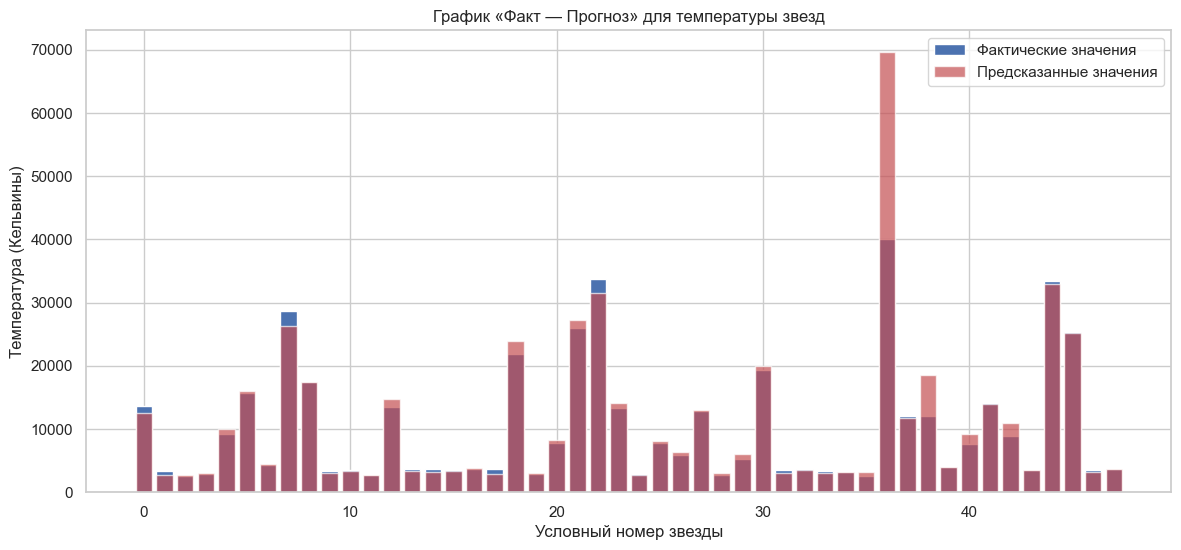

In [55]:
# Построение графика «Факт — Прогноз»
plt.figure(figsize=(14, 6))

# Определение ширины столбцов
width = 0.8

# Создание смещений для каждого набора данных, чтобы избежать их наложения
x_indices = np.arange(len(y_test_real_inv))
# Построение столбчатого графика для фактических значений
plt.bar(x_indices, y_test_real_inv, width=width, label='Фактические значения', color='b')
# Построение столбчатого графика для предсказанных значений
plt.bar(x_indices, y_preds, width=width, label='Предсказанные значения', color='r', alpha=0.7)
plt.xlabel('Условный номер звезды')
plt.ylabel('Температура (Кельвины)')
plt.title('График «Факт — Прогноз» для температуры звезд')
plt.legend()
plt.show()

In [56]:
first_rmse = np.sqrt(mean_squared_error(y_test_real_inv,y_preds))

In [57]:
print(f'Baseline test RMSE:{first_rmse}')

Baseline test RMSE:4451.426693267711


Шаг 5. Улучшение сети

In [58]:
# Создание класса для улучшенной архитектуры нейронной сети с Dropout
class StarTemperatureModel(nn.Module):
    def __init__(self, input_size, initial_hidden_layer_size=1024, num_hidden_layers=4, dropout_rate=0.0):
        super(StarTemperatureModel, self).__init__()
        layers = []
        current_layer_size = initial_hidden_layer_size
        layers.append(nn.Linear(input_size, current_layer_size))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))
        
        for _ in range(num_hidden_layers - 1):
            next_layer_size = max(1, current_layer_size // 2)  # Размерность уменьшается вдвое на каждом слое
            layers.append(nn.Linear(current_layer_size, next_layer_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            current_layer_size = next_layer_size
        
        layers.append(nn.Linear(current_layer_size, 1))  # Регрессия — один выходной нейрон
        
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [59]:
# # Определение устройства
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Конвертация данных в тензоры PyTorch и перемещение на устройство
# X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
# y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
# X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
# y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)
# # Создание Dataset и DataLoader
# train_dataset = StarDataset(X_train_tensor, y_train_tensor)
# test_dataset = StarDataset(X_test_tensor, y_test_tensor)

In [60]:
# Устройство (CPU или GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [76]:
# Определение функции для оптимизации с использованием Optuna
def objective(trial):
    # Гиперпараметры, которые будут оптимизироваться
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32, 64])
    hidden_layer_size = trial.suggest_categorical('hidden_layer_size', [256, 512, 1024])
    num_hidden_layers = trial.suggest_int('num_hidden_layers', 2, 5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)

    # Создаем DataLoader с текущим batch_size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Создание модели с текущими параметрами
    model = StarTemperatureModel(
        input_size, 
        initial_hidden_layer_size=hidden_layer_size, 
        num_hidden_layers=num_hidden_layers, 
        dropout_rate=dropout_rate
    ).to(device)

    # Оптимизатор и функция потерь
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    # Обучение модели
    num_epochs = 2000
    train_model(model, train_loader, criterion, optimizer, num_epochs=num_epochs, device=device)

    # Оценка модели
    model.eval()
    with torch.no_grad():
        y_pred_scaled = model(X_test_tensor.to(device)).cpu().numpy()

    # Масштабирование обратно в исходные единицы
    y_preds = inv(y_pred_scaled)
    y_pred_real = y_preds.reshape(-1) # Преобразуем в столбец
    y_test_real = inv(y_test_tensor.numpy().reshape(-1))
    # Вычисление RMSE
    rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
    return rmse

In [77]:
# Функция для обучения модели
def train_model(model, train_loader, criterion, optimizer, num_epochs, device):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for features, targets in train_loader:
            features, targets = features.to(device), targets.to(device)

            optimizer.zero_grad()  # Обнуляем градиенты
            outputs = model(features)  # Предсказания модели
            loss = criterion(outputs, targets.view(-1, 1))  # Вычисление потерь
            loss.backward()  # Обратное распространение ошибки
            optimizer.step()  # Шаг оптимизации

            running_loss += loss.item()

        # Печать потерь на каждой эпохе (можно отключить для ускорения)
        if epoch % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

In [78]:
# Создание и запуск Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=150)

[I 2024-11-12 16:07:18,328] A new study created in memory with name: no-name-023a4e46-2c9a-45d3-a7f2-27d261eb00a5
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 66.5899
Epoch [11/2000], Loss: 1.0653
Epoch [21/2000], Loss: 0.9148
Epoch [31/2000], Loss: 0.9477
Epoch [41/2000], Loss: 0.7553
Epoch [51/2000], Loss: 0.7850
Epoch [61/2000], Loss: 0.6403
Epoch [71/2000], Loss: 0.6667
Epoch [81/2000], Loss: 0.7113
Epoch [91/2000], Loss: 0.6342
Epoch [101/2000], Loss: 0.5365
Epoch [111/2000], Loss: 0.7862
Epoch [121/2000], Loss: 0.4948
Epoch [131/2000], Loss: 0.6561
Epoch [141/2000], Loss: 0.5910
Epoch [151/2000], Loss: 0.5247
Epoch [161/2000], Loss: 0.6360
Epoch [171/2000], Loss: 0.6203
Epoch [181/2000], Loss: 0.5782
Epoch [191/2000], Loss: 0.6858
Epoch [201/2000], Loss: 0.5898
Epoch [211/2000], Loss: 0.5979
Epoch [221/2000], Loss: 0.5840
Epoch [231/2000], Loss: 0.6517
Epoch [241/2000], Loss: 0.5282
Epoch [251/2000], Loss: 0.4670
Epoch [261/2000], Loss: 0.4906
Epoch [271/2000], Loss: 0.5692
Epoch [281/2000], Loss: 0.5364
Epoch [291/2000], Loss: 0.6738
Epoch [301/2000], Loss: 0.7097
Epoch [311/2000], Loss: 0.6473
Epoch [321/2000], 

[I 2024-11-12 16:08:13,264] Trial 0 finished with value: 5789.512834759152 and parameters: {'dropout_rate': 0.34037715953341713, 'batch_size': 16, 'hidden_layer_size': 512, 'num_hidden_layers': 2, 'learning_rate': 0.0002724565268494932}. Best is trial 0 with value: 5789.512834759152.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 75.2469
Epoch [11/2000], Loss: 3.3951
Epoch [21/2000], Loss: 3.5327
Epoch [31/2000], Loss: 2.8792
Epoch [41/2000], Loss: 3.0462
Epoch [51/2000], Loss: 3.1586
Epoch [61/2000], Loss: 2.5348
Epoch [71/2000], Loss: 3.2988
Epoch [81/2000], Loss: 2.2436
Epoch [91/2000], Loss: 2.6860
Epoch [101/2000], Loss: 2.4733
Epoch [111/2000], Loss: 2.6994
Epoch [121/2000], Loss: 2.2344
Epoch [131/2000], Loss: 3.0078
Epoch [141/2000], Loss: 2.1748
Epoch [151/2000], Loss: 2.5022
Epoch [161/2000], Loss: 2.6455
Epoch [171/2000], Loss: 3.1009
Epoch [181/2000], Loss: 2.4232
Epoch [191/2000], Loss: 2.2776
Epoch [201/2000], Loss: 2.3282
Epoch [211/2000], Loss: 2.4021
Epoch [221/2000], Loss: 2.0701
Epoch [231/2000], Loss: 2.0580
Epoch [241/2000], Loss: 2.6069
Epoch [251/2000], Loss: 2.7166
Epoch [261/2000], Loss: 2.5058
Epoch [271/2000], Loss: 2.1441
Epoch [281/2000], Loss: 2.3470
Epoch [291/2000], Loss: 2.1863
Epoch [301/2000], Loss: 2.4964
Epoch [311/2000], Loss: 2.3619
Epoch [321/2000], 

[I 2024-11-12 16:10:27,043] Trial 1 finished with value: 4831.935574813723 and parameters: {'dropout_rate': 0.40020189028952385, 'batch_size': 8, 'hidden_layer_size': 256, 'num_hidden_layers': 3, 'learning_rate': 0.00021298898896030197}. Best is trial 1 with value: 4831.935574813723.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 78.1942
Epoch [11/2000], Loss: 47.6436
Epoch [21/2000], Loss: 7.0250
Epoch [31/2000], Loss: 1.5553
Epoch [41/2000], Loss: 1.5319
Epoch [51/2000], Loss: 1.3224
Epoch [61/2000], Loss: 1.3068
Epoch [71/2000], Loss: 0.9278
Epoch [81/2000], Loss: 0.9166
Epoch [91/2000], Loss: 0.9379
Epoch [101/2000], Loss: 0.7994
Epoch [111/2000], Loss: 0.8526
Epoch [121/2000], Loss: 0.7974
Epoch [131/2000], Loss: 0.7959
Epoch [141/2000], Loss: 0.8773
Epoch [151/2000], Loss: 0.7211
Epoch [161/2000], Loss: 0.8012
Epoch [171/2000], Loss: 0.6147
Epoch [181/2000], Loss: 0.7107
Epoch [191/2000], Loss: 0.7425
Epoch [201/2000], Loss: 0.6448
Epoch [211/2000], Loss: 0.6826
Epoch [221/2000], Loss: 0.7000
Epoch [231/2000], Loss: 0.6267
Epoch [241/2000], Loss: 0.7691
Epoch [251/2000], Loss: 0.7893
Epoch [261/2000], Loss: 0.6956
Epoch [271/2000], Loss: 0.6539
Epoch [281/2000], Loss: 0.7527
Epoch [291/2000], Loss: 0.6314
Epoch [301/2000], Loss: 0.7559
Epoch [311/2000], Loss: 0.5906
Epoch [321/2000],

[I 2024-11-12 16:10:50,348] Trial 2 finished with value: 3356.1518406281853 and parameters: {'dropout_rate': 0.11611268320979617, 'batch_size': 64, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.0001983710077963207}. Best is trial 2 with value: 3356.1518406281853.


Epoch [1991/2000], Loss: 0.5582
Epoch [1/2000], Loss: 81.3059


C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [11/2000], Loss: 74.9453
Epoch [21/2000], Loss: 45.7791
Epoch [31/2000], Loss: 10.4234
Epoch [41/2000], Loss: 5.4140
Epoch [51/2000], Loss: 3.6391
Epoch [61/2000], Loss: 2.2908
Epoch [71/2000], Loss: 2.1262
Epoch [81/2000], Loss: 2.0226
Epoch [91/2000], Loss: 2.0925
Epoch [101/2000], Loss: 2.1311
Epoch [111/2000], Loss: 1.8198
Epoch [121/2000], Loss: 1.7685
Epoch [131/2000], Loss: 2.0783
Epoch [141/2000], Loss: 1.7970
Epoch [151/2000], Loss: 1.6595
Epoch [161/2000], Loss: 1.9094
Epoch [171/2000], Loss: 1.7966
Epoch [181/2000], Loss: 1.4525
Epoch [191/2000], Loss: 1.8290
Epoch [201/2000], Loss: 1.7211
Epoch [211/2000], Loss: 1.5631
Epoch [221/2000], Loss: 1.5499
Epoch [231/2000], Loss: 1.4596
Epoch [241/2000], Loss: 1.7461
Epoch [251/2000], Loss: 1.5590
Epoch [261/2000], Loss: 1.4288
Epoch [271/2000], Loss: 1.3435
Epoch [281/2000], Loss: 1.5394
Epoch [291/2000], Loss: 1.5718
Epoch [301/2000], Loss: 1.4154
Epoch [311/2000], Loss: 1.5381
Epoch [321/2000], Loss: 1.3810
Epoch [331/200

[I 2024-11-12 16:12:14,860] Trial 3 finished with value: 6009.214785553879 and parameters: {'dropout_rate': 0.1850052931580906, 'batch_size': 16, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 2.1602265031166363e-05}. Best is trial 2 with value: 3356.1518406281853.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 79.7095
Epoch [11/2000], Loss: 1.6141
Epoch [21/2000], Loss: 1.2682
Epoch [31/2000], Loss: 1.0400
Epoch [41/2000], Loss: 1.2388
Epoch [51/2000], Loss: 1.0022
Epoch [61/2000], Loss: 0.9027
Epoch [71/2000], Loss: 0.9511
Epoch [81/2000], Loss: 1.1297
Epoch [91/2000], Loss: 0.9368
Epoch [101/2000], Loss: 1.0343
Epoch [111/2000], Loss: 0.8283
Epoch [121/2000], Loss: 0.7841
Epoch [131/2000], Loss: 0.6880
Epoch [141/2000], Loss: 0.7971
Epoch [151/2000], Loss: 0.6629
Epoch [161/2000], Loss: 0.6527
Epoch [171/2000], Loss: 0.7978
Epoch [181/2000], Loss: 0.6576
Epoch [191/2000], Loss: 0.6652
Epoch [201/2000], Loss: 0.7814
Epoch [211/2000], Loss: 0.6997
Epoch [221/2000], Loss: 0.7085
Epoch [231/2000], Loss: 0.6126
Epoch [241/2000], Loss: 0.7525
Epoch [251/2000], Loss: 0.4649
Epoch [261/2000], Loss: 0.5583
Epoch [271/2000], Loss: 0.5393
Epoch [281/2000], Loss: 0.5528
Epoch [291/2000], Loss: 0.4773
Epoch [301/2000], Loss: 0.5192
Epoch [311/2000], Loss: 0.4849
Epoch [321/2000], 

[I 2024-11-12 16:13:50,468] Trial 4 finished with value: 6685.106912979608 and parameters: {'dropout_rate': 0.03587018936342917, 'batch_size': 16, 'hidden_layer_size': 256, 'num_hidden_layers': 5, 'learning_rate': 0.0003946332362464223}. Best is trial 2 with value: 3356.1518406281853.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 72.7762
Epoch [11/2000], Loss: 8.0238
Epoch [21/2000], Loss: 1.5743
Epoch [31/2000], Loss: 0.6701
Epoch [41/2000], Loss: 0.5009
Epoch [51/2000], Loss: 0.4603
Epoch [61/2000], Loss: 0.5100
Epoch [71/2000], Loss: 0.3871
Epoch [81/2000], Loss: 0.3404
Epoch [91/2000], Loss: 0.3607
Epoch [101/2000], Loss: 0.3124
Epoch [111/2000], Loss: 0.2684
Epoch [121/2000], Loss: 0.2682
Epoch [131/2000], Loss: 0.3013
Epoch [141/2000], Loss: 0.2401
Epoch [151/2000], Loss: 0.2662
Epoch [161/2000], Loss: 0.2829
Epoch [171/2000], Loss: 0.2982
Epoch [181/2000], Loss: 0.2581
Epoch [191/2000], Loss: 0.2014
Epoch [201/2000], Loss: 0.2268
Epoch [211/2000], Loss: 0.2262
Epoch [221/2000], Loss: 0.2634
Epoch [231/2000], Loss: 0.2585
Epoch [241/2000], Loss: 0.2055
Epoch [251/2000], Loss: 0.2786
Epoch [261/2000], Loss: 0.2100
Epoch [271/2000], Loss: 0.2430
Epoch [281/2000], Loss: 0.2687
Epoch [291/2000], Loss: 0.2019
Epoch [301/2000], Loss: 0.2048
Epoch [311/2000], Loss: 0.2508
Epoch [321/2000], 

[I 2024-11-12 16:15:31,374] Trial 5 finished with value: 3969.434998269731 and parameters: {'dropout_rate': 0.21102456229148137, 'batch_size': 8, 'hidden_layer_size': 1024, 'num_hidden_layers': 2, 'learning_rate': 2.1566136132996335e-05}. Best is trial 2 with value: 3356.1518406281853.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 79.3597
Epoch [11/2000], Loss: 2.7484
Epoch [21/2000], Loss: 2.3857
Epoch [31/2000], Loss: 2.1939
Epoch [41/2000], Loss: 1.4267
Epoch [51/2000], Loss: 1.7045
Epoch [61/2000], Loss: 1.4796
Epoch [71/2000], Loss: 1.6094
Epoch [81/2000], Loss: 1.4978
Epoch [91/2000], Loss: 1.4216
Epoch [101/2000], Loss: 1.7988
Epoch [111/2000], Loss: 1.3542
Epoch [121/2000], Loss: 1.8009
Epoch [131/2000], Loss: 1.3693
Epoch [141/2000], Loss: 1.3129
Epoch [151/2000], Loss: 1.3131
Epoch [161/2000], Loss: 1.3894
Epoch [171/2000], Loss: 1.3093
Epoch [181/2000], Loss: 1.4005
Epoch [191/2000], Loss: 1.3893
Epoch [201/2000], Loss: 1.7050
Epoch [211/2000], Loss: 1.1230
Epoch [221/2000], Loss: 1.3793
Epoch [231/2000], Loss: 1.4256
Epoch [241/2000], Loss: 1.2006
Epoch [251/2000], Loss: 1.3254
Epoch [261/2000], Loss: 1.5545
Epoch [271/2000], Loss: 1.3269
Epoch [281/2000], Loss: 1.5831
Epoch [291/2000], Loss: 1.4075
Epoch [301/2000], Loss: 1.4443
Epoch [311/2000], Loss: 1.2727
Epoch [321/2000], 

[I 2024-11-12 16:16:12,969] Trial 6 finished with value: 2128.231946057903 and parameters: {'dropout_rate': 0.24140834535913858, 'batch_size': 32, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.00036269887138273615}. Best is trial 6 with value: 2128.231946057903.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 80.9733
Epoch [11/2000], Loss: 77.0731
Epoch [21/2000], Loss: 57.8072
Epoch [31/2000], Loss: 15.6269
Epoch [41/2000], Loss: 7.6478
Epoch [51/2000], Loss: 4.5296
Epoch [61/2000], Loss: 3.6742
Epoch [71/2000], Loss: 3.4645
Epoch [81/2000], Loss: 3.3343
Epoch [91/2000], Loss: 3.4868
Epoch [101/2000], Loss: 3.4586
Epoch [111/2000], Loss: 3.0572
Epoch [121/2000], Loss: 3.1919
Epoch [131/2000], Loss: 3.0441
Epoch [141/2000], Loss: 3.0193
Epoch [151/2000], Loss: 2.8497
Epoch [161/2000], Loss: 3.0801
Epoch [171/2000], Loss: 2.5747
Epoch [181/2000], Loss: 2.3353
Epoch [191/2000], Loss: 2.7670
Epoch [201/2000], Loss: 2.3548
Epoch [211/2000], Loss: 2.4214
Epoch [221/2000], Loss: 2.1227
Epoch [231/2000], Loss: 1.9869
Epoch [241/2000], Loss: 1.9792
Epoch [251/2000], Loss: 2.3523
Epoch [261/2000], Loss: 2.0227
Epoch [271/2000], Loss: 2.1113
Epoch [281/2000], Loss: 2.4203
Epoch [291/2000], Loss: 2.2473
Epoch [301/2000], Loss: 2.3926
Epoch [311/2000], Loss: 2.2956
Epoch [321/2000

[I 2024-11-12 16:16:37,153] Trial 7 finished with value: 6086.285736366516 and parameters: {'dropout_rate': 0.27043644938039874, 'batch_size': 64, 'hidden_layer_size': 1024, 'num_hidden_layers': 5, 'learning_rate': 4.536000053283561e-05}. Best is trial 6 with value: 2128.231946057903.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 82.8781
Epoch [11/2000], Loss: 14.5658
Epoch [21/2000], Loss: 4.3718
Epoch [31/2000], Loss: 3.6499
Epoch [41/2000], Loss: 3.3501
Epoch [51/2000], Loss: 2.8764
Epoch [61/2000], Loss: 2.8284
Epoch [71/2000], Loss: 2.9183
Epoch [81/2000], Loss: 2.5663
Epoch [91/2000], Loss: 2.4361
Epoch [101/2000], Loss: 3.0554
Epoch [111/2000], Loss: 2.1643
Epoch [121/2000], Loss: 2.4634
Epoch [131/2000], Loss: 2.0558
Epoch [141/2000], Loss: 1.9677
Epoch [151/2000], Loss: 2.4484
Epoch [161/2000], Loss: 2.1035
Epoch [171/2000], Loss: 2.0899
Epoch [181/2000], Loss: 2.1067
Epoch [191/2000], Loss: 2.0168
Epoch [201/2000], Loss: 2.1229
Epoch [211/2000], Loss: 2.0350
Epoch [221/2000], Loss: 1.6796
Epoch [231/2000], Loss: 2.0606
Epoch [241/2000], Loss: 2.2272
Epoch [251/2000], Loss: 2.5335
Epoch [261/2000], Loss: 2.1533
Epoch [271/2000], Loss: 2.0446
Epoch [281/2000], Loss: 2.1289
Epoch [291/2000], Loss: 2.2607
Epoch [301/2000], Loss: 2.2341
Epoch [311/2000], Loss: 1.9406
Epoch [321/2000],

[I 2024-11-12 16:17:23,906] Trial 8 finished with value: 3663.303881880816 and parameters: {'dropout_rate': 0.1894403941986646, 'batch_size': 32, 'hidden_layer_size': 512, 'num_hidden_layers': 5, 'learning_rate': 0.00018910115145993122}. Best is trial 6 with value: 2128.231946057903.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 48.1239
Epoch [11/2000], Loss: 0.5649
Epoch [21/2000], Loss: 0.3863
Epoch [31/2000], Loss: 0.3017
Epoch [41/2000], Loss: 0.3211
Epoch [51/2000], Loss: 0.3483
Epoch [61/2000], Loss: 0.2663
Epoch [71/2000], Loss: 0.3411
Epoch [81/2000], Loss: 0.2575
Epoch [91/2000], Loss: 0.3363
Epoch [101/2000], Loss: 0.2561
Epoch [111/2000], Loss: 0.3559
Epoch [121/2000], Loss: 0.3594
Epoch [131/2000], Loss: 0.2683
Epoch [141/2000], Loss: 0.2802
Epoch [151/2000], Loss: 0.2479
Epoch [161/2000], Loss: 0.3010
Epoch [171/2000], Loss: 0.2610
Epoch [181/2000], Loss: 0.2495
Epoch [191/2000], Loss: 0.2647
Epoch [201/2000], Loss: 0.2521
Epoch [211/2000], Loss: 0.2183
Epoch [221/2000], Loss: 0.2294
Epoch [231/2000], Loss: 0.1990
Epoch [241/2000], Loss: 0.2330
Epoch [251/2000], Loss: 0.2438
Epoch [261/2000], Loss: 0.2540
Epoch [271/2000], Loss: 0.2825
Epoch [281/2000], Loss: 0.2580
Epoch [291/2000], Loss: 0.2077
Epoch [301/2000], Loss: 0.2575
Epoch [311/2000], Loss: 0.2070
Epoch [321/2000], 

[I 2024-11-12 16:19:10,891] Trial 9 finished with value: 2923.8755756646906 and parameters: {'dropout_rate': 0.16120310656229264, 'batch_size': 8, 'hidden_layer_size': 512, 'num_hidden_layers': 2, 'learning_rate': 0.00035425725600129316}. Best is trial 6 with value: 2128.231946057903.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 73.8473
Epoch [11/2000], Loss: 4.8215
Epoch [21/2000], Loss: 4.5585
Epoch [31/2000], Loss: 3.6179
Epoch [41/2000], Loss: 3.7974
Epoch [51/2000], Loss: 3.3440
Epoch [61/2000], Loss: 3.3318
Epoch [71/2000], Loss: 3.3531
Epoch [81/2000], Loss: 3.8601
Epoch [91/2000], Loss: 3.3045
Epoch [101/2000], Loss: 3.4669
Epoch [111/2000], Loss: 3.4908
Epoch [121/2000], Loss: 3.4190
Epoch [131/2000], Loss: 3.4477
Epoch [141/2000], Loss: 3.3146
Epoch [151/2000], Loss: 3.1208
Epoch [161/2000], Loss: 3.4008
Epoch [171/2000], Loss: 2.7252
Epoch [181/2000], Loss: 3.3544
Epoch [191/2000], Loss: 2.6316
Epoch [201/2000], Loss: 3.2207
Epoch [211/2000], Loss: 3.5062
Epoch [221/2000], Loss: 3.0470
Epoch [231/2000], Loss: 3.0451
Epoch [241/2000], Loss: 2.9659
Epoch [251/2000], Loss: 2.5245
Epoch [261/2000], Loss: 2.9536
Epoch [271/2000], Loss: 3.0755
Epoch [281/2000], Loss: 2.6052
Epoch [291/2000], Loss: 3.1399
Epoch [301/2000], Loss: 2.8152
Epoch [311/2000], Loss: 2.4718
Epoch [321/2000], 

[I 2024-11-12 16:19:42,958] Trial 10 finished with value: 3958.2749694163917 and parameters: {'dropout_rate': 0.4667268450780039, 'batch_size': 32, 'hidden_layer_size': 256, 'num_hidden_layers': 3, 'learning_rate': 0.000909583472483952}. Best is trial 6 with value: 2128.231946057903.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 33.8538
Epoch [11/2000], Loss: 0.3976
Epoch [21/2000], Loss: 0.3394
Epoch [31/2000], Loss: 0.5103
Epoch [41/2000], Loss: 0.3453
Epoch [51/2000], Loss: 0.4046
Epoch [61/2000], Loss: 0.4228
Epoch [71/2000], Loss: 0.3942
Epoch [81/2000], Loss: 0.3044
Epoch [91/2000], Loss: 0.2870
Epoch [101/2000], Loss: 0.5763
Epoch [111/2000], Loss: 0.3818
Epoch [121/2000], Loss: 0.3353
Epoch [131/2000], Loss: 0.3628
Epoch [141/2000], Loss: 0.5599
Epoch [151/2000], Loss: 0.3423
Epoch [161/2000], Loss: 0.4629
Epoch [171/2000], Loss: 0.3312
Epoch [181/2000], Loss: 0.3299
Epoch [191/2000], Loss: 0.2727
Epoch [201/2000], Loss: 0.2804
Epoch [211/2000], Loss: 0.5350
Epoch [221/2000], Loss: 0.2879
Epoch [231/2000], Loss: 0.3584
Epoch [241/2000], Loss: 0.3072
Epoch [251/2000], Loss: 0.3048
Epoch [261/2000], Loss: 0.3922
Epoch [271/2000], Loss: 0.3315
Epoch [281/2000], Loss: 0.4720
Epoch [291/2000], Loss: 0.3175
Epoch [301/2000], Loss: 0.2603
Epoch [311/2000], Loss: 0.2188
Epoch [321/2000], 

[I 2024-11-12 16:21:53,970] Trial 11 finished with value: 3148.864968865422 and parameters: {'dropout_rate': 0.0901484761972049, 'batch_size': 8, 'hidden_layer_size': 512, 'num_hidden_layers': 3, 'learning_rate': 0.0008455004738619559}. Best is trial 6 with value: 2128.231946057903.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 78.5233
Epoch [11/2000], Loss: 57.9014
Epoch [21/2000], Loss: 9.0302
Epoch [31/2000], Loss: 3.5062
Epoch [41/2000], Loss: 2.9016
Epoch [51/2000], Loss: 3.2265
Epoch [61/2000], Loss: 2.4893
Epoch [71/2000], Loss: 2.8347
Epoch [81/2000], Loss: 2.3291
Epoch [91/2000], Loss: 2.3989
Epoch [101/2000], Loss: 2.5047
Epoch [111/2000], Loss: 2.1034
Epoch [121/2000], Loss: 2.3131
Epoch [131/2000], Loss: 2.1762
Epoch [141/2000], Loss: 1.8728
Epoch [151/2000], Loss: 2.0790
Epoch [161/2000], Loss: 1.9698
Epoch [171/2000], Loss: 2.0880
Epoch [181/2000], Loss: 2.0848
Epoch [191/2000], Loss: 2.0622
Epoch [201/2000], Loss: 1.7490
Epoch [211/2000], Loss: 1.9249
Epoch [221/2000], Loss: 1.9171
Epoch [231/2000], Loss: 1.9649
Epoch [241/2000], Loss: 1.8434
Epoch [251/2000], Loss: 2.1591
Epoch [261/2000], Loss: 1.6616
Epoch [271/2000], Loss: 1.6506
Epoch [281/2000], Loss: 1.7489
Epoch [291/2000], Loss: 1.6787
Epoch [301/2000], Loss: 1.7799
Epoch [311/2000], Loss: 1.8557
Epoch [321/2000],

[I 2024-11-12 16:22:35,447] Trial 12 finished with value: 4539.005879947155 and parameters: {'dropout_rate': 0.29008955179505697, 'batch_size': 32, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 7.528257677318983e-05}. Best is trial 6 with value: 2128.231946057903.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 36.4191
Epoch [11/2000], Loss: 0.3601
Epoch [21/2000], Loss: 0.2650
Epoch [31/2000], Loss: 0.2613
Epoch [41/2000], Loss: 0.2497
Epoch [51/2000], Loss: 0.2557
Epoch [61/2000], Loss: 0.2282
Epoch [71/2000], Loss: 0.2387
Epoch [81/2000], Loss: 0.2239
Epoch [91/2000], Loss: 0.2643
Epoch [101/2000], Loss: 0.1915
Epoch [111/2000], Loss: 0.2166
Epoch [121/2000], Loss: 0.1783
Epoch [131/2000], Loss: 0.2058
Epoch [141/2000], Loss: 0.2259
Epoch [151/2000], Loss: 0.2113
Epoch [161/2000], Loss: 0.3130
Epoch [171/2000], Loss: 0.2356
Epoch [181/2000], Loss: 0.2117
Epoch [191/2000], Loss: 0.2241
Epoch [201/2000], Loss: 0.1775
Epoch [211/2000], Loss: 0.1846
Epoch [221/2000], Loss: 0.1783
Epoch [231/2000], Loss: 0.1863
Epoch [241/2000], Loss: 0.1857
Epoch [251/2000], Loss: 0.2019
Epoch [261/2000], Loss: 0.1936
Epoch [271/2000], Loss: 0.1881
Epoch [281/2000], Loss: 0.1587
Epoch [291/2000], Loss: 0.2263
Epoch [301/2000], Loss: 0.1784
Epoch [311/2000], Loss: 0.2017
Epoch [321/2000], 

[I 2024-11-12 16:24:21,316] Trial 13 finished with value: 3334.483458092244 and parameters: {'dropout_rate': 0.12794843820711393, 'batch_size': 8, 'hidden_layer_size': 512, 'num_hidden_layers': 2, 'learning_rate': 0.0004393457210614853}. Best is trial 6 with value: 2128.231946057903.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 78.5637
Epoch [11/2000], Loss: 5.9380
Epoch [21/2000], Loss: 0.4894
Epoch [31/2000], Loss: 0.3573
Epoch [41/2000], Loss: 0.2595
Epoch [51/2000], Loss: 0.1932
Epoch [61/2000], Loss: 0.1467
Epoch [71/2000], Loss: 0.1180
Epoch [81/2000], Loss: 0.1000
Epoch [91/2000], Loss: 0.0869
Epoch [101/2000], Loss: 0.0726
Epoch [111/2000], Loss: 0.0663
Epoch [121/2000], Loss: 0.0596
Epoch [131/2000], Loss: 0.0579
Epoch [141/2000], Loss: 0.0522
Epoch [151/2000], Loss: 0.0453
Epoch [161/2000], Loss: 0.0492
Epoch [171/2000], Loss: 0.0455
Epoch [181/2000], Loss: 0.0452
Epoch [191/2000], Loss: 0.0431
Epoch [201/2000], Loss: 0.0360
Epoch [211/2000], Loss: 0.0394
Epoch [221/2000], Loss: 0.0368
Epoch [231/2000], Loss: 0.0312
Epoch [241/2000], Loss: 0.0340
Epoch [251/2000], Loss: 0.0288
Epoch [261/2000], Loss: 0.0289
Epoch [271/2000], Loss: 0.0322
Epoch [281/2000], Loss: 0.0283
Epoch [291/2000], Loss: 0.0307
Epoch [301/2000], Loss: 0.0282
Epoch [311/2000], Loss: 0.0294
Epoch [321/2000], 

[I 2024-11-12 16:24:57,010] Trial 14 finished with value: 2165.226262934168 and parameters: {'dropout_rate': 0.004406187751722579, 'batch_size': 32, 'hidden_layer_size': 1024, 'num_hidden_layers': 3, 'learning_rate': 9.874584994234046e-05}. Best is trial 6 with value: 2128.231946057903.


Epoch [1991/2000], Loss: 0.0151
Epoch [1/2000], Loss: 79.1381


C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [11/2000], Loss: 9.7209
Epoch [21/2000], Loss: 0.7724
Epoch [31/2000], Loss: 0.4572
Epoch [41/2000], Loss: 0.3393
Epoch [51/2000], Loss: 0.2707
Epoch [61/2000], Loss: 0.2108
Epoch [71/2000], Loss: 0.1727
Epoch [81/2000], Loss: 0.1283
Epoch [91/2000], Loss: 0.1052
Epoch [101/2000], Loss: 0.0898
Epoch [111/2000], Loss: 0.0827
Epoch [121/2000], Loss: 0.0698
Epoch [131/2000], Loss: 0.0637
Epoch [141/2000], Loss: 0.0632
Epoch [151/2000], Loss: 0.0593
Epoch [161/2000], Loss: 0.0544
Epoch [171/2000], Loss: 0.0467
Epoch [181/2000], Loss: 0.0531
Epoch [191/2000], Loss: 0.0449
Epoch [201/2000], Loss: 0.0444
Epoch [211/2000], Loss: 0.0370
Epoch [221/2000], Loss: 0.0361
Epoch [231/2000], Loss: 0.0397
Epoch [241/2000], Loss: 0.0322
Epoch [251/2000], Loss: 0.0312
Epoch [261/2000], Loss: 0.0357
Epoch [271/2000], Loss: 0.0314
Epoch [281/2000], Loss: 0.0323
Epoch [291/2000], Loss: 0.0287
Epoch [301/2000], Loss: 0.0319
Epoch [311/2000], Loss: 0.0289
Epoch [321/2000], Loss: 0.0259
Epoch [331/2000],

[I 2024-11-12 16:25:37,793] Trial 15 finished with value: 7959.982889422207 and parameters: {'dropout_rate': 0.001970079273656822, 'batch_size': 32, 'hidden_layer_size': 1024, 'num_hidden_layers': 4, 'learning_rate': 8.042391391115369e-05}. Best is trial 6 with value: 2128.231946057903.


Epoch [1991/2000], Loss: 0.0214
Epoch [1/2000], Loss: 80.5508


C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [11/2000], Loss: 73.8724
Epoch [21/2000], Loss: 63.7613
Epoch [31/2000], Loss: 47.7607
Epoch [41/2000], Loss: 29.0601
Epoch [51/2000], Loss: 15.2796
Epoch [61/2000], Loss: 9.1430
Epoch [71/2000], Loss: 6.3886
Epoch [81/2000], Loss: 5.0457
Epoch [91/2000], Loss: 3.4685
Epoch [101/2000], Loss: 2.4938
Epoch [111/2000], Loss: 1.8800
Epoch [121/2000], Loss: 1.8404
Epoch [131/2000], Loss: 1.4344
Epoch [141/2000], Loss: 1.5817
Epoch [151/2000], Loss: 1.3891
Epoch [161/2000], Loss: 1.2953
Epoch [171/2000], Loss: 1.2780
Epoch [181/2000], Loss: 1.4613
Epoch [191/2000], Loss: 1.3195
Epoch [201/2000], Loss: 1.2294
Epoch [211/2000], Loss: 1.3308
Epoch [221/2000], Loss: 1.3742
Epoch [231/2000], Loss: 1.2320
Epoch [241/2000], Loss: 0.9839
Epoch [251/2000], Loss: 0.9693
Epoch [261/2000], Loss: 1.0347
Epoch [271/2000], Loss: 1.1443
Epoch [281/2000], Loss: 0.9985
Epoch [291/2000], Loss: 1.1526
Epoch [301/2000], Loss: 0.9263
Epoch [311/2000], Loss: 1.1947
Epoch [321/2000], Loss: 0.9609
Epoch [331/2

[I 2024-11-12 16:26:12,134] Trial 16 finished with value: 5047.6841488519885 and parameters: {'dropout_rate': 0.3519487448403461, 'batch_size': 32, 'hidden_layer_size': 1024, 'num_hidden_layers': 3, 'learning_rate': 1.0508012235640347e-05}. Best is trial 6 with value: 2128.231946057903.


Epoch [1991/2000], Loss: 0.7001
Epoch [1/2000], Loss: 78.8438


C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [11/2000], Loss: 5.0972
Epoch [21/2000], Loss: 0.7597
Epoch [31/2000], Loss: 0.7318
Epoch [41/2000], Loss: 0.5978
Epoch [51/2000], Loss: 0.4245
Epoch [61/2000], Loss: 0.3912
Epoch [71/2000], Loss: 0.4267
Epoch [81/2000], Loss: 0.3733
Epoch [91/2000], Loss: 0.3617
Epoch [101/2000], Loss: 0.3322
Epoch [111/2000], Loss: 0.3606
Epoch [121/2000], Loss: 0.3441
Epoch [131/2000], Loss: 0.3425
Epoch [141/2000], Loss: 0.2831
Epoch [151/2000], Loss: 0.3117
Epoch [161/2000], Loss: 0.3048
Epoch [171/2000], Loss: 0.2895
Epoch [181/2000], Loss: 0.3678
Epoch [191/2000], Loss: 0.2990
Epoch [201/2000], Loss: 0.2576
Epoch [211/2000], Loss: 0.2452
Epoch [221/2000], Loss: 0.2519
Epoch [231/2000], Loss: 0.2569
Epoch [241/2000], Loss: 0.2989
Epoch [251/2000], Loss: 0.2573
Epoch [261/2000], Loss: 0.2278
Epoch [271/2000], Loss: 0.2683
Epoch [281/2000], Loss: 0.2704
Epoch [291/2000], Loss: 0.2022
Epoch [301/2000], Loss: 0.2610
Epoch [311/2000], Loss: 0.2481
Epoch [321/2000], Loss: 0.2980
Epoch [331/2000],

[I 2024-11-12 16:26:52,505] Trial 17 finished with value: 3730.426790361206 and parameters: {'dropout_rate': 0.0731597578967724, 'batch_size': 32, 'hidden_layer_size': 1024, 'num_hidden_layers': 4, 'learning_rate': 0.00012062660434551475}. Best is trial 6 with value: 2128.231946057903.


Epoch [1991/2000], Loss: 0.2268


C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 76.5822
Epoch [11/2000], Loss: 35.5388
Epoch [21/2000], Loss: 7.6473
Epoch [31/2000], Loss: 2.6813
Epoch [41/2000], Loss: 1.9572
Epoch [51/2000], Loss: 1.7852
Epoch [61/2000], Loss: 1.5743
Epoch [71/2000], Loss: 1.8750
Epoch [81/2000], Loss: 1.4663
Epoch [91/2000], Loss: 1.6820
Epoch [101/2000], Loss: 1.3558
Epoch [111/2000], Loss: 1.5947
Epoch [121/2000], Loss: 1.4377
Epoch [131/2000], Loss: 1.5252
Epoch [141/2000], Loss: 1.2788
Epoch [151/2000], Loss: 1.4724
Epoch [161/2000], Loss: 1.1318
Epoch [171/2000], Loss: 1.4264
Epoch [181/2000], Loss: 1.3831
Epoch [191/2000], Loss: 1.1463
Epoch [201/2000], Loss: 1.3977
Epoch [211/2000], Loss: 1.2268
Epoch [221/2000], Loss: 1.3149
Epoch [231/2000], Loss: 1.0000
Epoch [241/2000], Loss: 1.3441
Epoch [251/2000], Loss: 0.9829
Epoch [261/2000], Loss: 1.1511
Epoch [271/2000], Loss: 1.0559
Epoch [281/2000], Loss: 1.2673
Epoch [291/2000], Loss: 1.1060
Epoch [301/2000], Loss: 1.0805
Epoch [311/2000], Loss: 1.0522
Epoch [321/2000],

[I 2024-11-12 16:27:26,773] Trial 18 finished with value: 5785.19309302096 and parameters: {'dropout_rate': 0.46760771613744323, 'batch_size': 32, 'hidden_layer_size': 1024, 'num_hidden_layers': 3, 'learning_rate': 3.86836464129452e-05}. Best is trial 6 with value: 2128.231946057903.


Epoch [1991/2000], Loss: 0.7540


C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 79.1820
Epoch [11/2000], Loss: 3.9063
Epoch [21/2000], Loss: 1.6095
Epoch [31/2000], Loss: 1.5533
Epoch [41/2000], Loss: 1.4020
Epoch [51/2000], Loss: 1.2039
Epoch [61/2000], Loss: 1.1837
Epoch [71/2000], Loss: 1.0210
Epoch [81/2000], Loss: 1.1085
Epoch [91/2000], Loss: 0.9658
Epoch [101/2000], Loss: 0.9734
Epoch [111/2000], Loss: 1.0334
Epoch [121/2000], Loss: 0.8042
Epoch [131/2000], Loss: 0.8260
Epoch [141/2000], Loss: 0.7756
Epoch [151/2000], Loss: 0.9227
Epoch [161/2000], Loss: 0.7446
Epoch [171/2000], Loss: 0.8024
Epoch [181/2000], Loss: 0.6230
Epoch [191/2000], Loss: 0.7954
Epoch [201/2000], Loss: 0.7758
Epoch [211/2000], Loss: 0.7879
Epoch [221/2000], Loss: 0.8123
Epoch [231/2000], Loss: 0.6167
Epoch [241/2000], Loss: 0.7954
Epoch [251/2000], Loss: 0.7216
Epoch [261/2000], Loss: 0.7567
Epoch [271/2000], Loss: 0.8223
Epoch [281/2000], Loss: 0.8578
Epoch [291/2000], Loss: 1.0757
Epoch [301/2000], Loss: 0.8266
Epoch [311/2000], Loss: 0.8841
Epoch [321/2000], 

[I 2024-11-12 16:28:07,102] Trial 19 finished with value: 2539.430221617179 and parameters: {'dropout_rate': 0.24065651207169084, 'batch_size': 32, 'hidden_layer_size': 1024, 'num_hidden_layers': 4, 'learning_rate': 0.00012540965147833918}. Best is trial 6 with value: 2128.231946057903.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 75.4643
Epoch [11/2000], Loss: 12.4256
Epoch [21/2000], Loss: 4.0002
Epoch [31/2000], Loss: 2.8609
Epoch [41/2000], Loss: 2.8303
Epoch [51/2000], Loss: 2.5339
Epoch [61/2000], Loss: 2.4468
Epoch [71/2000], Loss: 2.4097
Epoch [81/2000], Loss: 2.0200
Epoch [91/2000], Loss: 1.9061
Epoch [101/2000], Loss: 2.1091
Epoch [111/2000], Loss: 2.1888
Epoch [121/2000], Loss: 1.7550
Epoch [131/2000], Loss: 1.8328
Epoch [141/2000], Loss: 2.0702
Epoch [151/2000], Loss: 1.5543
Epoch [161/2000], Loss: 2.0888
Epoch [171/2000], Loss: 2.0569
Epoch [181/2000], Loss: 1.8426
Epoch [191/2000], Loss: 2.2471
Epoch [201/2000], Loss: 2.0929
Epoch [211/2000], Loss: 2.0511
Epoch [221/2000], Loss: 1.5679
Epoch [231/2000], Loss: 2.1191
Epoch [241/2000], Loss: 1.7635
Epoch [251/2000], Loss: 1.6528
Epoch [261/2000], Loss: 1.6609
Epoch [271/2000], Loss: 1.6403
Epoch [281/2000], Loss: 1.8885
Epoch [291/2000], Loss: 1.6383
Epoch [301/2000], Loss: 1.5998
Epoch [311/2000], Loss: 1.7641
Epoch [321/2000],

[I 2024-11-12 16:28:24,461] Trial 20 finished with value: 4107.93390201202 and parameters: {'dropout_rate': 0.3320696409746399, 'batch_size': 64, 'hidden_layer_size': 256, 'num_hidden_layers': 3, 'learning_rate': 0.0005698436115612271}. Best is trial 6 with value: 2128.231946057903.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 79.3451
Epoch [11/2000], Loss: 5.1027
Epoch [21/2000], Loss: 1.8615
Epoch [31/2000], Loss: 1.5239
Epoch [41/2000], Loss: 1.1353
Epoch [51/2000], Loss: 1.2366
Epoch [61/2000], Loss: 1.1752
Epoch [71/2000], Loss: 0.9818
Epoch [81/2000], Loss: 0.8551
Epoch [91/2000], Loss: 0.9362
Epoch [101/2000], Loss: 0.9731
Epoch [111/2000], Loss: 0.8015
Epoch [121/2000], Loss: 0.9529
Epoch [131/2000], Loss: 0.9642
Epoch [141/2000], Loss: 0.9375
Epoch [151/2000], Loss: 0.9400
Epoch [161/2000], Loss: 0.7823
Epoch [171/2000], Loss: 0.7573
Epoch [181/2000], Loss: 0.9835
Epoch [191/2000], Loss: 1.0866
Epoch [201/2000], Loss: 0.8689
Epoch [211/2000], Loss: 0.8217
Epoch [221/2000], Loss: 0.8716
Epoch [231/2000], Loss: 0.7650
Epoch [241/2000], Loss: 0.7167
Epoch [251/2000], Loss: 0.7284
Epoch [261/2000], Loss: 0.8513
Epoch [271/2000], Loss: 0.7758
Epoch [281/2000], Loss: 0.8727
Epoch [291/2000], Loss: 0.7677
Epoch [301/2000], Loss: 0.7917
Epoch [311/2000], Loss: 0.8258
Epoch [321/2000], 

[I 2024-11-12 16:29:05,647] Trial 21 finished with value: 4334.020252339432 and parameters: {'dropout_rate': 0.23873723796363885, 'batch_size': 32, 'hidden_layer_size': 1024, 'num_hidden_layers': 4, 'learning_rate': 0.00010247054507113492}. Best is trial 6 with value: 2128.231946057903.


Epoch [1991/2000], Loss: 0.6259


C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 77.1524
Epoch [11/2000], Loss: 3.6098
Epoch [21/2000], Loss: 1.4701
Epoch [31/2000], Loss: 1.7242
Epoch [41/2000], Loss: 1.7174
Epoch [51/2000], Loss: 1.3212
Epoch [61/2000], Loss: 1.1004
Epoch [71/2000], Loss: 0.9716
Epoch [81/2000], Loss: 1.0181
Epoch [91/2000], Loss: 0.9997
Epoch [101/2000], Loss: 0.8878
Epoch [111/2000], Loss: 0.9378
Epoch [121/2000], Loss: 0.8641
Epoch [131/2000], Loss: 0.7996
Epoch [141/2000], Loss: 1.1792
Epoch [151/2000], Loss: 0.8553
Epoch [161/2000], Loss: 0.8632
Epoch [171/2000], Loss: 0.8281
Epoch [181/2000], Loss: 1.0132
Epoch [191/2000], Loss: 0.6372
Epoch [201/2000], Loss: 0.7943
Epoch [211/2000], Loss: 0.8029
Epoch [221/2000], Loss: 0.8580
Epoch [231/2000], Loss: 0.8912
Epoch [241/2000], Loss: 0.8544
Epoch [251/2000], Loss: 0.9240
Epoch [261/2000], Loss: 0.8549
Epoch [271/2000], Loss: 0.7871
Epoch [281/2000], Loss: 0.8133
Epoch [291/2000], Loss: 0.8043
Epoch [301/2000], Loss: 0.8162
Epoch [311/2000], Loss: 0.6121
Epoch [321/2000], 

[I 2024-11-12 16:29:44,869] Trial 22 finished with value: 5026.599348707783 and parameters: {'dropout_rate': 0.24606819903567598, 'batch_size': 32, 'hidden_layer_size': 1024, 'num_hidden_layers': 4, 'learning_rate': 0.00013471595345684826}. Best is trial 6 with value: 2128.231946057903.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 82.1431
Epoch [11/2000], Loss: 72.0235
Epoch [21/2000], Loss: 12.4821
Epoch [31/2000], Loss: 7.2180
Epoch [41/2000], Loss: 6.8312
Epoch [51/2000], Loss: 7.8032
Epoch [61/2000], Loss: 5.8590
Epoch [71/2000], Loss: 5.2901
Epoch [81/2000], Loss: 4.6767
Epoch [91/2000], Loss: 5.4389
Epoch [101/2000], Loss: 5.4977
Epoch [111/2000], Loss: 4.7407
Epoch [121/2000], Loss: 4.5621
Epoch [131/2000], Loss: 4.3982
Epoch [141/2000], Loss: 3.6094
Epoch [151/2000], Loss: 4.8467
Epoch [161/2000], Loss: 4.4936
Epoch [171/2000], Loss: 4.3634
Epoch [181/2000], Loss: 4.2441
Epoch [191/2000], Loss: 3.9291
Epoch [201/2000], Loss: 4.3251
Epoch [211/2000], Loss: 3.3165
Epoch [221/2000], Loss: 4.6346
Epoch [231/2000], Loss: 4.0703
Epoch [241/2000], Loss: 3.7214
Epoch [251/2000], Loss: 4.4013
Epoch [261/2000], Loss: 3.9329
Epoch [271/2000], Loss: 3.9948
Epoch [281/2000], Loss: 4.0868
Epoch [291/2000], Loss: 4.2022
Epoch [301/2000], Loss: 4.1296
Epoch [311/2000], Loss: 4.1189
Epoch [321/2000]

[I 2024-11-12 16:30:30,784] Trial 23 finished with value: 4579.8896535183385 and parameters: {'dropout_rate': 0.4098484743677724, 'batch_size': 32, 'hidden_layer_size': 1024, 'num_hidden_layers': 5, 'learning_rate': 5.894179560198723e-05}. Best is trial 6 with value: 2128.231946057903.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 77.6200
Epoch [11/2000], Loss: 2.0364
Epoch [21/2000], Loss: 2.1665
Epoch [31/2000], Loss: 1.7460
Epoch [41/2000], Loss: 1.3771
Epoch [51/2000], Loss: 1.1920
Epoch [61/2000], Loss: 1.3462
Epoch [71/2000], Loss: 1.2366
Epoch [81/2000], Loss: 1.0209
Epoch [91/2000], Loss: 1.2633
Epoch [101/2000], Loss: 1.1402
Epoch [111/2000], Loss: 1.2777
Epoch [121/2000], Loss: 0.9369
Epoch [131/2000], Loss: 1.0289
Epoch [141/2000], Loss: 0.9466
Epoch [151/2000], Loss: 0.9092
Epoch [161/2000], Loss: 1.0191
Epoch [171/2000], Loss: 1.0140
Epoch [181/2000], Loss: 0.9994
Epoch [191/2000], Loss: 1.0620
Epoch [201/2000], Loss: 0.9536
Epoch [211/2000], Loss: 0.9950
Epoch [221/2000], Loss: 1.0268
Epoch [231/2000], Loss: 1.0003
Epoch [241/2000], Loss: 0.9641
Epoch [251/2000], Loss: 1.1052
Epoch [261/2000], Loss: 1.0413
Epoch [271/2000], Loss: 1.0189
Epoch [281/2000], Loss: 1.1205
Epoch [291/2000], Loss: 1.0460
Epoch [301/2000], Loss: 1.1472
Epoch [311/2000], Loss: 0.8910
Epoch [321/2000], 

[I 2024-11-12 16:31:11,489] Trial 24 finished with value: 3338.1828421831515 and parameters: {'dropout_rate': 0.2939555979874612, 'batch_size': 32, 'hidden_layer_size': 1024, 'num_hidden_layers': 4, 'learning_rate': 0.00015438246680634835}. Best is trial 6 with value: 2128.231946057903.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 59.5417
Epoch [11/2000], Loss: 0.7110
Epoch [21/2000], Loss: 0.4420
Epoch [31/2000], Loss: 0.4142
Epoch [41/2000], Loss: 0.4375
Epoch [51/2000], Loss: 0.3783
Epoch [61/2000], Loss: 0.3135
Epoch [71/2000], Loss: 0.3945
Epoch [81/2000], Loss: 0.3478
Epoch [91/2000], Loss: 0.2968
Epoch [101/2000], Loss: 0.3079
Epoch [111/2000], Loss: 0.3311
Epoch [121/2000], Loss: 0.2894
Epoch [131/2000], Loss: 0.3611
Epoch [141/2000], Loss: 0.4092
Epoch [151/2000], Loss: 0.3372
Epoch [161/2000], Loss: 0.3069
Epoch [171/2000], Loss: 0.3230
Epoch [181/2000], Loss: 0.2745
Epoch [191/2000], Loss: 0.3315
Epoch [201/2000], Loss: 0.2857
Epoch [211/2000], Loss: 0.3715
Epoch [221/2000], Loss: 0.3891
Epoch [231/2000], Loss: 0.2875
Epoch [241/2000], Loss: 0.3174
Epoch [251/2000], Loss: 0.2740
Epoch [261/2000], Loss: 0.3398
Epoch [271/2000], Loss: 0.3017
Epoch [281/2000], Loss: 0.2941
Epoch [291/2000], Loss: 0.3795
Epoch [301/2000], Loss: 0.3349
Epoch [311/2000], Loss: 0.3561
Epoch [321/2000], 

[I 2024-11-12 16:31:45,134] Trial 25 finished with value: 4169.728133029104 and parameters: {'dropout_rate': 0.15575093955726801, 'batch_size': 32, 'hidden_layer_size': 1024, 'num_hidden_layers': 3, 'learning_rate': 0.0005859515631346253}. Best is trial 6 with value: 2128.231946057903.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 75.9410
Epoch [11/2000], Loss: 2.2918
Epoch [21/2000], Loss: 1.4499
Epoch [31/2000], Loss: 1.1987
Epoch [41/2000], Loss: 1.0276
Epoch [51/2000], Loss: 0.8230
Epoch [61/2000], Loss: 0.8978
Epoch [71/2000], Loss: 0.8793
Epoch [81/2000], Loss: 0.7981
Epoch [91/2000], Loss: 0.7463
Epoch [101/2000], Loss: 0.9287
Epoch [111/2000], Loss: 0.8747
Epoch [121/2000], Loss: 0.7312
Epoch [131/2000], Loss: 0.8635
Epoch [141/2000], Loss: 0.6419
Epoch [151/2000], Loss: 0.7652
Epoch [161/2000], Loss: 0.8557
Epoch [171/2000], Loss: 0.8802
Epoch [181/2000], Loss: 0.7251
Epoch [191/2000], Loss: 0.8204
Epoch [201/2000], Loss: 0.5557
Epoch [211/2000], Loss: 0.6555
Epoch [221/2000], Loss: 0.6917
Epoch [231/2000], Loss: 0.7199
Epoch [241/2000], Loss: 0.6755
Epoch [251/2000], Loss: 0.5080
Epoch [261/2000], Loss: 0.6794
Epoch [271/2000], Loss: 0.7546
Epoch [281/2000], Loss: 0.6327
Epoch [291/2000], Loss: 0.7656
Epoch [301/2000], Loss: 0.5876
Epoch [311/2000], Loss: 0.6854
Epoch [321/2000], 

[I 2024-11-12 16:32:24,706] Trial 26 finished with value: 5006.519951276561 and parameters: {'dropout_rate': 0.2197753903418098, 'batch_size': 32, 'hidden_layer_size': 1024, 'num_hidden_layers': 4, 'learning_rate': 0.00025225377448011077}. Best is trial 6 with value: 2128.231946057903.


Epoch [1991/2000], Loss: 0.4597


C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 80.3971
Epoch [11/2000], Loss: 70.4052
Epoch [21/2000], Loss: 18.3752
Epoch [31/2000], Loss: 4.9670
Epoch [41/2000], Loss: 1.4672
Epoch [51/2000], Loss: 1.0497
Epoch [61/2000], Loss: 0.8078
Epoch [71/2000], Loss: 0.7006
Epoch [81/2000], Loss: 0.6824
Epoch [91/2000], Loss: 0.6375
Epoch [101/2000], Loss: 0.5773
Epoch [111/2000], Loss: 0.6939
Epoch [121/2000], Loss: 0.5577
Epoch [131/2000], Loss: 0.6789
Epoch [141/2000], Loss: 0.5188
Epoch [151/2000], Loss: 0.5821
Epoch [161/2000], Loss: 0.5387
Epoch [171/2000], Loss: 0.6175
Epoch [181/2000], Loss: 0.5078
Epoch [191/2000], Loss: 0.4850
Epoch [201/2000], Loss: 0.4409
Epoch [211/2000], Loss: 0.4339
Epoch [221/2000], Loss: 0.5257
Epoch [231/2000], Loss: 0.3583
Epoch [241/2000], Loss: 0.4310
Epoch [251/2000], Loss: 0.4410
Epoch [261/2000], Loss: 0.4000
Epoch [271/2000], Loss: 0.3939
Epoch [281/2000], Loss: 0.4345
Epoch [291/2000], Loss: 0.3795
Epoch [301/2000], Loss: 0.3966
Epoch [311/2000], Loss: 0.4754
Epoch [321/2000]

[I 2024-11-12 16:33:12,219] Trial 27 finished with value: 2804.1935409775842 and parameters: {'dropout_rate': 0.0482934783195732, 'batch_size': 32, 'hidden_layer_size': 1024, 'num_hidden_layers': 5, 'learning_rate': 3.185677315429116e-05}. Best is trial 6 with value: 2128.231946057903.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 78.9762
Epoch [11/2000], Loss: 73.8520
Epoch [21/2000], Loss: 64.4112
Epoch [31/2000], Loss: 47.2334
Epoch [41/2000], Loss: 25.7803
Epoch [51/2000], Loss: 11.6495
Epoch [61/2000], Loss: 7.0034
Epoch [71/2000], Loss: 4.7572
Epoch [81/2000], Loss: 3.9283
Epoch [91/2000], Loss: 3.9965
Epoch [101/2000], Loss: 2.7593
Epoch [111/2000], Loss: 3.1506
Epoch [121/2000], Loss: 4.3085
Epoch [131/2000], Loss: 2.8547
Epoch [141/2000], Loss: 2.7385
Epoch [151/2000], Loss: 3.4726
Epoch [161/2000], Loss: 2.8475
Epoch [171/2000], Loss: 2.2564
Epoch [181/2000], Loss: 2.7921
Epoch [191/2000], Loss: 3.8060
Epoch [201/2000], Loss: 2.8685
Epoch [211/2000], Loss: 2.8813
Epoch [221/2000], Loss: 3.0382
Epoch [231/2000], Loss: 2.6957
Epoch [241/2000], Loss: 3.2017
Epoch [251/2000], Loss: 2.7276
Epoch [261/2000], Loss: 3.0349
Epoch [271/2000], Loss: 2.4268
Epoch [281/2000], Loss: 2.9726
Epoch [291/2000], Loss: 2.4387
Epoch [301/2000], Loss: 3.5057
Epoch [311/2000], Loss: 2.7943
Epoch [321/20

[I 2024-11-12 16:33:30,209] Trial 28 finished with value: 5307.766194828177 and parameters: {'dropout_rate': 0.38893391160149715, 'batch_size': 64, 'hidden_layer_size': 256, 'num_hidden_layers': 3, 'learning_rate': 8.365515585203116e-05}. Best is trial 6 with value: 2128.231946057903.


Epoch [1981/2000], Loss: 2.0287
Epoch [1991/2000], Loss: 2.1119


C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 63.3765
Epoch [11/2000], Loss: 0.9528
Epoch [21/2000], Loss: 0.8654
Epoch [31/2000], Loss: 0.8139
Epoch [41/2000], Loss: 0.5195
Epoch [51/2000], Loss: 0.7023
Epoch [61/2000], Loss: 0.6907
Epoch [71/2000], Loss: 0.6336
Epoch [81/2000], Loss: 0.7154
Epoch [91/2000], Loss: 0.5821
Epoch [101/2000], Loss: 0.5376
Epoch [111/2000], Loss: 0.5398
Epoch [121/2000], Loss: 0.7077
Epoch [131/2000], Loss: 0.6790
Epoch [141/2000], Loss: 0.5598
Epoch [151/2000], Loss: 0.5338
Epoch [161/2000], Loss: 0.4883
Epoch [171/2000], Loss: 0.6377
Epoch [181/2000], Loss: 0.5197
Epoch [191/2000], Loss: 0.4860
Epoch [201/2000], Loss: 0.4935
Epoch [211/2000], Loss: 0.4818
Epoch [221/2000], Loss: 0.4740
Epoch [231/2000], Loss: 0.5487
Epoch [241/2000], Loss: 0.5556
Epoch [251/2000], Loss: 0.5175
Epoch [261/2000], Loss: 0.5870
Epoch [271/2000], Loss: 0.5263
Epoch [281/2000], Loss: 0.5675
Epoch [291/2000], Loss: 0.5127
Epoch [301/2000], Loss: 0.5441
Epoch [311/2000], Loss: 0.4034
Epoch [321/2000], 

[I 2024-11-12 16:34:25,109] Trial 29 finished with value: 4126.786575081831 and parameters: {'dropout_rate': 0.32620310580862344, 'batch_size': 16, 'hidden_layer_size': 512, 'num_hidden_layers': 2, 'learning_rate': 0.0002720369168004751}. Best is trial 6 with value: 2128.231946057903.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 79.1918
Epoch [11/2000], Loss: 28.9589
Epoch [21/2000], Loss: 2.2879
Epoch [31/2000], Loss: 0.5442
Epoch [41/2000], Loss: 0.3484
Epoch [51/2000], Loss: 0.2701
Epoch [61/2000], Loss: 0.2122
Epoch [71/2000], Loss: 0.1762
Epoch [81/2000], Loss: 0.1445
Epoch [91/2000], Loss: 0.1248
Epoch [101/2000], Loss: 0.1049
Epoch [111/2000], Loss: 0.0910
Epoch [121/2000], Loss: 0.0743
Epoch [131/2000], Loss: 0.0667
Epoch [141/2000], Loss: 0.0608
Epoch [151/2000], Loss: 0.0571
Epoch [161/2000], Loss: 0.0517
Epoch [171/2000], Loss: 0.0480
Epoch [181/2000], Loss: 0.0483
Epoch [191/2000], Loss: 0.0393
Epoch [201/2000], Loss: 0.0397
Epoch [211/2000], Loss: 0.0370
Epoch [221/2000], Loss: 0.0375
Epoch [231/2000], Loss: 0.0421
Epoch [241/2000], Loss: 0.0351
Epoch [251/2000], Loss: 0.0284
Epoch [261/2000], Loss: 0.0338
Epoch [271/2000], Loss: 0.0288
Epoch [281/2000], Loss: 0.0386
Epoch [291/2000], Loss: 0.0235
Epoch [301/2000], Loss: 0.0213
Epoch [311/2000], Loss: 0.0240
Epoch [321/2000],

[I 2024-11-12 16:35:47,945] Trial 30 finished with value: 13600.98145193423 and parameters: {'dropout_rate': 0.0005256318336972488, 'batch_size': 16, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 5.581891411591091e-05}. Best is trial 6 with value: 2128.231946057903.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 81.6229
Epoch [11/2000], Loss: 73.0973
Epoch [21/2000], Loss: 28.3021
Epoch [31/2000], Loss: 7.2165
Epoch [41/2000], Loss: 2.6530
Epoch [51/2000], Loss: 1.2343
Epoch [61/2000], Loss: 0.7696
Epoch [71/2000], Loss: 0.6180
Epoch [81/2000], Loss: 0.7373
Epoch [91/2000], Loss: 0.5354
Epoch [101/2000], Loss: 0.4941
Epoch [111/2000], Loss: 0.5287
Epoch [121/2000], Loss: 0.4075
Epoch [131/2000], Loss: 0.4234
Epoch [141/2000], Loss: 0.4311
Epoch [151/2000], Loss: 0.3662
Epoch [161/2000], Loss: 0.4161
Epoch [171/2000], Loss: 0.3455
Epoch [181/2000], Loss: 0.3432
Epoch [191/2000], Loss: 0.3828
Epoch [201/2000], Loss: 0.3516
Epoch [211/2000], Loss: 0.3761
Epoch [221/2000], Loss: 0.3510
Epoch [231/2000], Loss: 0.3583
Epoch [241/2000], Loss: 0.3121
Epoch [251/2000], Loss: 0.2989
Epoch [261/2000], Loss: 0.3070
Epoch [271/2000], Loss: 0.2570
Epoch [281/2000], Loss: 0.3330
Epoch [291/2000], Loss: 0.2665
Epoch [301/2000], Loss: 0.2763
Epoch [311/2000], Loss: 0.2722
Epoch [321/2000]

[I 2024-11-12 16:36:34,177] Trial 31 finished with value: 3451.1374900290766 and parameters: {'dropout_rate': 0.03225081810393685, 'batch_size': 32, 'hidden_layer_size': 1024, 'num_hidden_layers': 5, 'learning_rate': 2.7772262937006387e-05}. Best is trial 6 with value: 2128.231946057903.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 80.1794
Epoch [11/2000], Loss: 78.3196
Epoch [21/2000], Loss: 72.5794
Epoch [31/2000], Loss: 54.1919
Epoch [41/2000], Loss: 21.9626
Epoch [51/2000], Loss: 9.2427
Epoch [61/2000], Loss: 5.8830
Epoch [71/2000], Loss: 3.2686
Epoch [81/2000], Loss: 2.0403
Epoch [91/2000], Loss: 1.3839
Epoch [101/2000], Loss: 1.1637
Epoch [111/2000], Loss: 1.1321
Epoch [121/2000], Loss: 1.0533
Epoch [131/2000], Loss: 0.8008
Epoch [141/2000], Loss: 0.8775
Epoch [151/2000], Loss: 0.9620
Epoch [161/2000], Loss: 0.9221
Epoch [171/2000], Loss: 0.7577
Epoch [181/2000], Loss: 0.7885
Epoch [191/2000], Loss: 1.0024
Epoch [201/2000], Loss: 0.8538
Epoch [211/2000], Loss: 0.8339
Epoch [221/2000], Loss: 0.7574
Epoch [231/2000], Loss: 0.7939
Epoch [241/2000], Loss: 0.8200
Epoch [251/2000], Loss: 0.8129
Epoch [261/2000], Loss: 0.6387
Epoch [271/2000], Loss: 0.7179
Epoch [281/2000], Loss: 0.6623
Epoch [291/2000], Loss: 0.7658
Epoch [301/2000], Loss: 0.7065
Epoch [311/2000], Loss: 0.7610
Epoch [321/200

[I 2024-11-12 16:37:20,167] Trial 32 finished with value: 4849.388876663512 and parameters: {'dropout_rate': 0.0668018786179228, 'batch_size': 32, 'hidden_layer_size': 1024, 'num_hidden_layers': 5, 'learning_rate': 1.4247657084929974e-05}. Best is trial 6 with value: 2128.231946057903.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 80.8068
Epoch [11/2000], Loss: 74.4790
Epoch [21/2000], Loss: 26.6850
Epoch [31/2000], Loss: 7.5107
Epoch [41/2000], Loss: 2.9117
Epoch [51/2000], Loss: 1.6693
Epoch [61/2000], Loss: 1.4654
Epoch [71/2000], Loss: 1.4198
Epoch [81/2000], Loss: 1.4445
Epoch [91/2000], Loss: 1.3104
Epoch [101/2000], Loss: 1.3780
Epoch [111/2000], Loss: 1.3140
Epoch [121/2000], Loss: 1.1880
Epoch [131/2000], Loss: 1.2306
Epoch [141/2000], Loss: 1.1533
Epoch [151/2000], Loss: 1.1710
Epoch [161/2000], Loss: 1.1362
Epoch [171/2000], Loss: 1.2309
Epoch [181/2000], Loss: 0.9731
Epoch [191/2000], Loss: 1.0860
Epoch [201/2000], Loss: 1.0167
Epoch [211/2000], Loss: 0.9880
Epoch [221/2000], Loss: 0.9459
Epoch [231/2000], Loss: 0.9409
Epoch [241/2000], Loss: 0.7964
Epoch [251/2000], Loss: 1.0312
Epoch [261/2000], Loss: 0.8005
Epoch [271/2000], Loss: 0.8422
Epoch [281/2000], Loss: 0.9026
Epoch [291/2000], Loss: 0.8004
Epoch [301/2000], Loss: 0.8523
Epoch [311/2000], Loss: 0.9551
Epoch [321/2000]

[I 2024-11-12 16:38:06,683] Trial 33 finished with value: 4065.789354353388 and parameters: {'dropout_rate': 0.10761905887716595, 'batch_size': 32, 'hidden_layer_size': 1024, 'num_hidden_layers': 5, 'learning_rate': 3.33685263045222e-05}. Best is trial 6 with value: 2128.231946057903.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 77.2715
Epoch [11/2000], Loss: 1.0929
Epoch [21/2000], Loss: 0.5102
Epoch [31/2000], Loss: 0.4273
Epoch [41/2000], Loss: 0.3507
Epoch [51/2000], Loss: 0.2743
Epoch [61/2000], Loss: 0.2229
Epoch [71/2000], Loss: 0.2383
Epoch [81/2000], Loss: 0.2074
Epoch [91/2000], Loss: 0.2143
Epoch [101/2000], Loss: 0.1865
Epoch [111/2000], Loss: 0.2000
Epoch [121/2000], Loss: 0.1821
Epoch [131/2000], Loss: 0.2066
Epoch [141/2000], Loss: 0.1793
Epoch [151/2000], Loss: 0.1741
Epoch [161/2000], Loss: 0.1970
Epoch [171/2000], Loss: 0.1671
Epoch [181/2000], Loss: 0.1820
Epoch [191/2000], Loss: 0.1474
Epoch [201/2000], Loss: 0.1659
Epoch [211/2000], Loss: 0.1491
Epoch [221/2000], Loss: 0.1602
Epoch [231/2000], Loss: 0.1839
Epoch [241/2000], Loss: 0.1702
Epoch [251/2000], Loss: 0.1346
Epoch [261/2000], Loss: 0.1476
Epoch [271/2000], Loss: 0.1461
Epoch [281/2000], Loss: 0.1459
Epoch [291/2000], Loss: 0.1668
Epoch [301/2000], Loss: 0.1570
Epoch [311/2000], Loss: 0.1356
Epoch [321/2000], 

[I 2024-11-12 16:38:49,821] Trial 34 finished with value: 2798.9333870493633 and parameters: {'dropout_rate': 0.039863699861539176, 'batch_size': 32, 'hidden_layer_size': 1024, 'num_hidden_layers': 4, 'learning_rate': 0.00016836162114099867}. Best is trial 6 with value: 2128.231946057903.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 80.8363
Epoch [11/2000], Loss: 58.0875
Epoch [21/2000], Loss: 6.5802
Epoch [31/2000], Loss: 2.1753
Epoch [41/2000], Loss: 2.0577
Epoch [51/2000], Loss: 1.8626
Epoch [61/2000], Loss: 1.9616
Epoch [71/2000], Loss: 2.0393
Epoch [81/2000], Loss: 1.6199
Epoch [91/2000], Loss: 1.7094
Epoch [101/2000], Loss: 1.8075
Epoch [111/2000], Loss: 1.6499
Epoch [121/2000], Loss: 1.4764
Epoch [131/2000], Loss: 1.5454
Epoch [141/2000], Loss: 1.4958
Epoch [151/2000], Loss: 1.5963
Epoch [161/2000], Loss: 1.4091
Epoch [171/2000], Loss: 1.2840
Epoch [181/2000], Loss: 1.6092
Epoch [191/2000], Loss: 1.2068
Epoch [201/2000], Loss: 1.1217
Epoch [211/2000], Loss: 1.2324
Epoch [221/2000], Loss: 1.3598
Epoch [231/2000], Loss: 1.3061
Epoch [241/2000], Loss: 1.2098
Epoch [251/2000], Loss: 1.2146
Epoch [261/2000], Loss: 1.1786
Epoch [271/2000], Loss: 1.3157
Epoch [281/2000], Loss: 1.0027
Epoch [291/2000], Loss: 1.1235
Epoch [301/2000], Loss: 1.3413
Epoch [311/2000], Loss: 1.0851
Epoch [321/2000],

[I 2024-11-12 16:39:35,381] Trial 35 finished with value: 3647.1435794908975 and parameters: {'dropout_rate': 0.1275398571801823, 'batch_size': 32, 'hidden_layer_size': 256, 'num_hidden_layers': 4, 'learning_rate': 0.00014938570657166376}. Best is trial 6 with value: 2128.231946057903.


Epoch [1991/2000], Loss: 0.7474


C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 75.9416
Epoch [11/2000], Loss: 0.6668
Epoch [21/2000], Loss: 0.4330
Epoch [31/2000], Loss: 0.3571
Epoch [41/2000], Loss: 0.2482
Epoch [51/2000], Loss: 0.3204
Epoch [61/2000], Loss: 0.2412
Epoch [71/2000], Loss: 0.2401
Epoch [81/2000], Loss: 0.2575
Epoch [91/2000], Loss: 0.1842
Epoch [101/2000], Loss: 0.2148
Epoch [111/2000], Loss: 0.2085
Epoch [121/2000], Loss: 0.1829
Epoch [131/2000], Loss: 0.1854
Epoch [141/2000], Loss: 0.2253
Epoch [151/2000], Loss: 0.1994
Epoch [161/2000], Loss: 0.1877
Epoch [171/2000], Loss: 0.2225
Epoch [181/2000], Loss: 0.1829
Epoch [191/2000], Loss: 0.1726
Epoch [201/2000], Loss: 0.1634
Epoch [211/2000], Loss: 0.1641
Epoch [221/2000], Loss: 0.1570
Epoch [231/2000], Loss: 0.1844
Epoch [241/2000], Loss: 0.1667
Epoch [251/2000], Loss: 0.1620
Epoch [261/2000], Loss: 0.2046
Epoch [271/2000], Loss: 0.1771
Epoch [281/2000], Loss: 0.2291
Epoch [291/2000], Loss: 0.1960
Epoch [301/2000], Loss: 0.2076
Epoch [311/2000], Loss: 0.1328
Epoch [321/2000], 

[I 2024-11-12 16:41:01,363] Trial 36 finished with value: 1530.111427841441 and parameters: {'dropout_rate': 0.027793587688080795, 'batch_size': 16, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.000198128526282197}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 74.7677
Epoch [11/2000], Loss: 1.0545
Epoch [21/2000], Loss: 0.7841
Epoch [31/2000], Loss: 0.5891
Epoch [41/2000], Loss: 0.5376
Epoch [51/2000], Loss: 0.6024
Epoch [61/2000], Loss: 0.4685
Epoch [71/2000], Loss: 0.5288
Epoch [81/2000], Loss: 0.5836
Epoch [91/2000], Loss: 0.4399
Epoch [101/2000], Loss: 0.6108
Epoch [111/2000], Loss: 0.4012
Epoch [121/2000], Loss: 0.5745
Epoch [131/2000], Loss: 0.5875
Epoch [141/2000], Loss: 0.4851
Epoch [151/2000], Loss: 0.6447
Epoch [161/2000], Loss: 0.5963
Epoch [171/2000], Loss: 0.5704
Epoch [181/2000], Loss: 0.4590
Epoch [191/2000], Loss: 0.5285
Epoch [201/2000], Loss: 0.4829
Epoch [211/2000], Loss: 0.5376
Epoch [221/2000], Loss: 0.5545
Epoch [231/2000], Loss: 0.5993
Epoch [241/2000], Loss: 0.6584
Epoch [251/2000], Loss: 0.5157
Epoch [261/2000], Loss: 0.4956
Epoch [271/2000], Loss: 0.4518
Epoch [281/2000], Loss: 0.6550
Epoch [291/2000], Loss: 0.4748
Epoch [301/2000], Loss: 0.4861
Epoch [311/2000], Loss: 0.6307
Epoch [321/2000], 

[I 2024-11-12 16:42:17,710] Trial 37 finished with value: 3860.2211117060956 and parameters: {'dropout_rate': 0.17177891633854542, 'batch_size': 16, 'hidden_layer_size': 512, 'num_hidden_layers': 3, 'learning_rate': 0.00028491089521690373}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 76.6293
Epoch [11/2000], Loss: 2.4051
Epoch [21/2000], Loss: 2.2257
Epoch [31/2000], Loss: 1.7443
Epoch [41/2000], Loss: 1.4487
Epoch [51/2000], Loss: 1.5096
Epoch [61/2000], Loss: 1.6361
Epoch [71/2000], Loss: 1.3268
Epoch [81/2000], Loss: 1.1842
Epoch [91/2000], Loss: 1.1772
Epoch [101/2000], Loss: 1.2529
Epoch [111/2000], Loss: 1.5259
Epoch [121/2000], Loss: 1.1112
Epoch [131/2000], Loss: 1.2088
Epoch [141/2000], Loss: 1.3524
Epoch [151/2000], Loss: 1.3126
Epoch [161/2000], Loss: 1.5383
Epoch [171/2000], Loss: 1.3448
Epoch [181/2000], Loss: 1.0940
Epoch [191/2000], Loss: 1.3019
Epoch [201/2000], Loss: 1.1589
Epoch [211/2000], Loss: 1.6313
Epoch [221/2000], Loss: 1.2880
Epoch [231/2000], Loss: 1.2117
Epoch [241/2000], Loss: 1.2969
Epoch [251/2000], Loss: 1.4780
Epoch [261/2000], Loss: 1.0960
Epoch [271/2000], Loss: 1.6636
Epoch [281/2000], Loss: 1.1887
Epoch [291/2000], Loss: 1.0935
Epoch [301/2000], Loss: 1.3165
Epoch [311/2000], Loss: 1.3195
Epoch [321/2000], 

[I 2024-11-12 16:43:42,377] Trial 38 finished with value: 2808.3450028204616 and parameters: {'dropout_rate': 0.2093755383721865, 'batch_size': 16, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.0002136608024236647}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 79.5290
Epoch [11/2000], Loss: 5.4745
Epoch [21/2000], Loss: 3.7310
Epoch [31/2000], Loss: 2.3630
Epoch [41/2000], Loss: 2.7498
Epoch [51/2000], Loss: 2.3497
Epoch [61/2000], Loss: 2.3856
Epoch [71/2000], Loss: 2.5865
Epoch [81/2000], Loss: 1.6922
Epoch [91/2000], Loss: 1.7174
Epoch [101/2000], Loss: 1.7534
Epoch [111/2000], Loss: 1.8272
Epoch [121/2000], Loss: 1.5979
Epoch [131/2000], Loss: 1.8007
Epoch [141/2000], Loss: 1.8485
Epoch [151/2000], Loss: 1.9032
Epoch [161/2000], Loss: 1.8185
Epoch [171/2000], Loss: 1.6522
Epoch [181/2000], Loss: 2.0801
Epoch [191/2000], Loss: 1.8402
Epoch [201/2000], Loss: 1.3610
Epoch [211/2000], Loss: 1.6349
Epoch [221/2000], Loss: 1.4828
Epoch [231/2000], Loss: 1.7377
Epoch [241/2000], Loss: 1.6853
Epoch [251/2000], Loss: 1.6790
Epoch [261/2000], Loss: 1.6813
Epoch [271/2000], Loss: 2.0374
Epoch [281/2000], Loss: 1.6347
Epoch [291/2000], Loss: 1.7638
Epoch [301/2000], Loss: 1.5233
Epoch [311/2000], Loss: 1.4616
Epoch [321/2000], 

[I 2024-11-12 16:45:04,683] Trial 39 finished with value: 3933.7307617004813 and parameters: {'dropout_rate': 0.271107819495492, 'batch_size': 16, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.00010377481883841694}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 77.9422
Epoch [11/2000], Loss: 7.2983
Epoch [21/2000], Loss: 5.4048
Epoch [31/2000], Loss: 4.9949
Epoch [41/2000], Loss: 3.5613
Epoch [51/2000], Loss: 4.5784
Epoch [61/2000], Loss: 4.8954
Epoch [71/2000], Loss: 4.0186
Epoch [81/2000], Loss: 3.7473
Epoch [91/2000], Loss: 3.6911
Epoch [101/2000], Loss: 3.3298
Epoch [111/2000], Loss: 4.4193
Epoch [121/2000], Loss: 3.6596
Epoch [131/2000], Loss: 4.1563
Epoch [141/2000], Loss: 3.8012
Epoch [151/2000], Loss: 3.4314
Epoch [161/2000], Loss: 3.6082
Epoch [171/2000], Loss: 3.3232
Epoch [181/2000], Loss: 4.0343
Epoch [191/2000], Loss: 3.4122
Epoch [201/2000], Loss: 3.8000
Epoch [211/2000], Loss: 4.0128
Epoch [221/2000], Loss: 3.2471
Epoch [231/2000], Loss: 3.4368
Epoch [241/2000], Loss: 3.7826
Epoch [251/2000], Loss: 3.1264
Epoch [261/2000], Loss: 2.7412
Epoch [271/2000], Loss: 3.1666
Epoch [281/2000], Loss: 3.6551
Epoch [291/2000], Loss: 3.5706
Epoch [301/2000], Loss: 3.2112
Epoch [311/2000], Loss: 2.8948
Epoch [321/2000], 

[I 2024-11-12 16:46:25,972] Trial 40 finished with value: 4246.311711904518 and parameters: {'dropout_rate': 0.49509684578745283, 'batch_size': 16, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.00034784811604152366}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 77.8761
Epoch [11/2000], Loss: 61.5367
Epoch [21/2000], Loss: 8.0856
Epoch [31/2000], Loss: 1.7046
Epoch [41/2000], Loss: 0.7712
Epoch [51/2000], Loss: 0.7931
Epoch [61/2000], Loss: 0.6548
Epoch [71/2000], Loss: 0.5433
Epoch [81/2000], Loss: 0.5032
Epoch [91/2000], Loss: 0.4300
Epoch [101/2000], Loss: 0.4040
Epoch [111/2000], Loss: 0.3520
Epoch [121/2000], Loss: 0.3210
Epoch [131/2000], Loss: 0.3562
Epoch [141/2000], Loss: 0.3002
Epoch [151/2000], Loss: 0.3256
Epoch [161/2000], Loss: 0.2822
Epoch [171/2000], Loss: 0.2490
Epoch [181/2000], Loss: 0.2720
Epoch [191/2000], Loss: 0.2852
Epoch [201/2000], Loss: 0.2563
Epoch [211/2000], Loss: 0.2623
Epoch [221/2000], Loss: 0.2355
Epoch [231/2000], Loss: 0.2322
Epoch [241/2000], Loss: 0.2327
Epoch [251/2000], Loss: 0.2179
Epoch [261/2000], Loss: 0.2331
Epoch [271/2000], Loss: 0.1979
Epoch [281/2000], Loss: 0.2266
Epoch [291/2000], Loss: 0.2165
Epoch [301/2000], Loss: 0.2004
Epoch [311/2000], Loss: 0.2532
Epoch [321/2000],

[I 2024-11-12 16:46:48,228] Trial 41 finished with value: 2393.001011336035 and parameters: {'dropout_rate': 0.026073020321043163, 'batch_size': 64, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.00019017114205859201}. Best is trial 36 with value: 1530.111427841441.


Epoch [1991/2000], Loss: 0.1439
Epoch [1/2000], Loss: 77.6765


C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [11/2000], Loss: 37.9445
Epoch [21/2000], Loss: 4.2698
Epoch [31/2000], Loss: 0.7499
Epoch [41/2000], Loss: 0.6703
Epoch [51/2000], Loss: 0.5050
Epoch [61/2000], Loss: 0.4634
Epoch [71/2000], Loss: 0.3926
Epoch [81/2000], Loss: 0.3579
Epoch [91/2000], Loss: 0.3064
Epoch [101/2000], Loss: 0.2857
Epoch [111/2000], Loss: 0.2823
Epoch [121/2000], Loss: 0.2584
Epoch [131/2000], Loss: 0.3344
Epoch [141/2000], Loss: 0.2648
Epoch [151/2000], Loss: 0.2044
Epoch [161/2000], Loss: 0.2344
Epoch [171/2000], Loss: 0.2336
Epoch [181/2000], Loss: 0.2391
Epoch [191/2000], Loss: 0.2415
Epoch [201/2000], Loss: 0.2179
Epoch [211/2000], Loss: 0.2184
Epoch [221/2000], Loss: 0.2576
Epoch [231/2000], Loss: 0.2386
Epoch [241/2000], Loss: 0.1861
Epoch [251/2000], Loss: 0.1990
Epoch [261/2000], Loss: 0.1839
Epoch [271/2000], Loss: 0.1560
Epoch [281/2000], Loss: 0.2171
Epoch [291/2000], Loss: 0.2254
Epoch [301/2000], Loss: 0.1804
Epoch [311/2000], Loss: 0.2021
Epoch [321/2000], Loss: 0.1660
Epoch [331/2000]

[I 2024-11-12 16:47:10,783] Trial 42 finished with value: 5678.7865949996585 and parameters: {'dropout_rate': 0.027071616690011395, 'batch_size': 64, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.00021517108265181503}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 80.8782
Epoch [11/2000], Loss: 70.2553
Epoch [21/2000], Loss: 25.9150
Epoch [31/2000], Loss: 6.8345
Epoch [41/2000], Loss: 1.8955
Epoch [51/2000], Loss: 1.0201
Epoch [61/2000], Loss: 0.8196
Epoch [71/2000], Loss: 0.9003
Epoch [81/2000], Loss: 0.6753
Epoch [91/2000], Loss: 0.6658
Epoch [101/2000], Loss: 0.7433
Epoch [111/2000], Loss: 0.6169
Epoch [121/2000], Loss: 0.6033
Epoch [131/2000], Loss: 0.7424
Epoch [141/2000], Loss: 0.6787
Epoch [151/2000], Loss: 0.5670
Epoch [161/2000], Loss: 0.5214
Epoch [171/2000], Loss: 0.5103
Epoch [181/2000], Loss: 0.4703
Epoch [191/2000], Loss: 0.5428
Epoch [201/2000], Loss: 0.5258
Epoch [211/2000], Loss: 0.4612
Epoch [221/2000], Loss: 0.4971
Epoch [231/2000], Loss: 0.4790
Epoch [241/2000], Loss: 0.4633
Epoch [251/2000], Loss: 0.4620
Epoch [261/2000], Loss: 0.4487
Epoch [271/2000], Loss: 0.4816
Epoch [281/2000], Loss: 0.4235
Epoch [291/2000], Loss: 0.3901
Epoch [301/2000], Loss: 0.3693
Epoch [311/2000], Loss: 0.4697
Epoch [321/2000]

[I 2024-11-12 16:47:32,933] Trial 43 finished with value: 3523.0730679234457 and parameters: {'dropout_rate': 0.06290933885643907, 'batch_size': 64, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.00012128477788084051}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 78.7959
Epoch [11/2000], Loss: 3.9476
Epoch [21/2000], Loss: 0.9757
Epoch [31/2000], Loss: 0.7084
Epoch [41/2000], Loss: 0.6191
Epoch [51/2000], Loss: 0.4806
Epoch [61/2000], Loss: 0.5186
Epoch [71/2000], Loss: 0.3629
Epoch [81/2000], Loss: 0.3650
Epoch [91/2000], Loss: 0.4399
Epoch [101/2000], Loss: 0.4157
Epoch [111/2000], Loss: 0.3617
Epoch [121/2000], Loss: 0.4384
Epoch [131/2000], Loss: 0.3113
Epoch [141/2000], Loss: 0.3685
Epoch [151/2000], Loss: 0.4006
Epoch [161/2000], Loss: 0.3059
Epoch [171/2000], Loss: 0.3058
Epoch [181/2000], Loss: 0.3012
Epoch [191/2000], Loss: 0.3098
Epoch [201/2000], Loss: 0.3626
Epoch [211/2000], Loss: 0.3308
Epoch [221/2000], Loss: 0.3421
Epoch [231/2000], Loss: 0.3205
Epoch [241/2000], Loss: 0.3189
Epoch [251/2000], Loss: 0.2668
Epoch [261/2000], Loss: 0.3512
Epoch [271/2000], Loss: 0.2624
Epoch [281/2000], Loss: 0.3773
Epoch [291/2000], Loss: 0.3269
Epoch [301/2000], Loss: 0.3826
Epoch [311/2000], Loss: 0.3018
Epoch [321/2000], 

[I 2024-11-12 16:47:51,725] Trial 44 finished with value: 6465.247192208786 and parameters: {'dropout_rate': 0.09003064855239751, 'batch_size': 64, 'hidden_layer_size': 512, 'num_hidden_layers': 3, 'learning_rate': 0.0005359647738241074}. Best is trial 36 with value: 1530.111427841441.


Epoch [1981/2000], Loss: 0.2158
Epoch [1991/2000], Loss: 0.2336


C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 72.8241
Epoch [11/2000], Loss: 0.4446
Epoch [21/2000], Loss: 0.3323
Epoch [31/2000], Loss: 0.2461
Epoch [41/2000], Loss: 0.2319
Epoch [51/2000], Loss: 0.1936
Epoch [61/2000], Loss: 0.2169
Epoch [71/2000], Loss: 0.1809
Epoch [81/2000], Loss: 0.2019
Epoch [91/2000], Loss: 0.1540
Epoch [101/2000], Loss: 0.2098
Epoch [111/2000], Loss: 0.2123
Epoch [121/2000], Loss: 0.1694
Epoch [131/2000], Loss: 0.1755
Epoch [141/2000], Loss: 0.1363
Epoch [151/2000], Loss: 0.1830
Epoch [161/2000], Loss: 0.1724
Epoch [171/2000], Loss: 0.1288
Epoch [181/2000], Loss: 0.1456
Epoch [191/2000], Loss: 0.1584
Epoch [201/2000], Loss: 0.1429
Epoch [211/2000], Loss: 0.1451
Epoch [221/2000], Loss: 0.1434
Epoch [231/2000], Loss: 0.1430
Epoch [241/2000], Loss: 0.1541
Epoch [251/2000], Loss: 0.1234
Epoch [261/2000], Loss: 0.1635
Epoch [271/2000], Loss: 0.1527
Epoch [281/2000], Loss: 0.2065
Epoch [291/2000], Loss: 0.1542
Epoch [301/2000], Loss: 0.1594
Epoch [311/2000], Loss: 0.1449
Epoch [321/2000], 

[I 2024-11-12 16:50:26,248] Trial 45 finished with value: 3539.4179636208414 and parameters: {'dropout_rate': 0.023446473945688114, 'batch_size': 8, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.00018313286848215508}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 76.6694
Epoch [11/2000], Loss: 9.4945
Epoch [21/2000], Loss: 1.0037
Epoch [31/2000], Loss: 0.7706
Epoch [41/2000], Loss: 0.6909
Epoch [51/2000], Loss: 0.5491
Epoch [61/2000], Loss: 0.5426
Epoch [71/2000], Loss: 0.4849
Epoch [81/2000], Loss: 0.5222
Epoch [91/2000], Loss: 0.4083
Epoch [101/2000], Loss: 0.5297
Epoch [111/2000], Loss: 0.3972
Epoch [121/2000], Loss: 0.4308
Epoch [131/2000], Loss: 0.3683
Epoch [141/2000], Loss: 0.4087
Epoch [151/2000], Loss: 0.3530
Epoch [161/2000], Loss: 0.3678
Epoch [171/2000], Loss: 0.3682
Epoch [181/2000], Loss: 0.4007
Epoch [191/2000], Loss: 0.4244
Epoch [201/2000], Loss: 0.4274
Epoch [211/2000], Loss: 0.4205
Epoch [221/2000], Loss: 0.3815
Epoch [231/2000], Loss: 0.4062
Epoch [241/2000], Loss: 0.4516
Epoch [251/2000], Loss: 0.3163
Epoch [261/2000], Loss: 0.3314
Epoch [271/2000], Loss: 0.3672
Epoch [281/2000], Loss: 0.3288
Epoch [291/2000], Loss: 0.3108
Epoch [301/2000], Loss: 0.3301
Epoch [311/2000], Loss: 0.3135
Epoch [321/2000], 

[I 2024-11-12 16:50:45,129] Trial 46 finished with value: 2471.452999112397 and parameters: {'dropout_rate': 0.10114886288180053, 'batch_size': 64, 'hidden_layer_size': 512, 'num_hidden_layers': 3, 'learning_rate': 0.000330602063321933}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 78.8527
Epoch [11/2000], Loss: 10.0543
Epoch [21/2000], Loss: 0.9448
Epoch [31/2000], Loss: 0.7968
Epoch [41/2000], Loss: 0.6449
Epoch [51/2000], Loss: 0.4871
Epoch [61/2000], Loss: 0.4633
Epoch [71/2000], Loss: 0.4904
Epoch [81/2000], Loss: 0.4275
Epoch [91/2000], Loss: 0.4095
Epoch [101/2000], Loss: 0.4972
Epoch [111/2000], Loss: 0.3984
Epoch [121/2000], Loss: 0.4284
Epoch [131/2000], Loss: 0.3680
Epoch [141/2000], Loss: 0.3787
Epoch [151/2000], Loss: 0.3578
Epoch [161/2000], Loss: 0.3683
Epoch [171/2000], Loss: 0.3717
Epoch [181/2000], Loss: 0.3100
Epoch [191/2000], Loss: 0.3376
Epoch [201/2000], Loss: 0.3720
Epoch [211/2000], Loss: 0.3791
Epoch [221/2000], Loss: 0.2974
Epoch [231/2000], Loss: 0.3936
Epoch [241/2000], Loss: 0.3791
Epoch [251/2000], Loss: 0.3931
Epoch [261/2000], Loss: 0.3529
Epoch [271/2000], Loss: 0.3013
Epoch [281/2000], Loss: 0.3786
Epoch [291/2000], Loss: 0.3412
Epoch [301/2000], Loss: 0.3866
Epoch [311/2000], Loss: 0.3513
Epoch [321/2000],

[I 2024-11-12 16:51:04,252] Trial 47 finished with value: 3279.7029203189986 and parameters: {'dropout_rate': 0.09737734157270356, 'batch_size': 64, 'hidden_layer_size': 512, 'num_hidden_layers': 3, 'learning_rate': 0.00042130316391820094}. Best is trial 36 with value: 1530.111427841441.


Epoch [1991/2000], Loss: 0.2603
Epoch [1/2000], Loss: 74.7106


C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [11/2000], Loss: 2.2339
Epoch [21/2000], Loss: 0.7744
Epoch [31/2000], Loss: 0.5581
Epoch [41/2000], Loss: 0.4355
Epoch [51/2000], Loss: 0.3531
Epoch [61/2000], Loss: 0.3437
Epoch [71/2000], Loss: 0.3732
Epoch [81/2000], Loss: 0.3095
Epoch [91/2000], Loss: 0.2766
Epoch [101/2000], Loss: 0.3362
Epoch [111/2000], Loss: 0.3273
Epoch [121/2000], Loss: 0.2641
Epoch [131/2000], Loss: 0.2723
Epoch [141/2000], Loss: 0.2973
Epoch [151/2000], Loss: 0.2829
Epoch [161/2000], Loss: 0.2538
Epoch [171/2000], Loss: 0.2142
Epoch [181/2000], Loss: 0.2790
Epoch [191/2000], Loss: 0.3066
Epoch [201/2000], Loss: 0.2562
Epoch [211/2000], Loss: 0.2847
Epoch [221/2000], Loss: 0.2240
Epoch [231/2000], Loss: 0.2334
Epoch [241/2000], Loss: 0.2607
Epoch [251/2000], Loss: 0.2515
Epoch [261/2000], Loss: 0.2092
Epoch [271/2000], Loss: 0.3306
Epoch [281/2000], Loss: 0.2463
Epoch [291/2000], Loss: 0.2423
Epoch [301/2000], Loss: 0.2220
Epoch [311/2000], Loss: 0.2683
Epoch [321/2000], Loss: 0.2030
Epoch [331/2000],

[I 2024-11-12 16:51:20,300] Trial 48 finished with value: 5973.045601702145 and parameters: {'dropout_rate': 0.14222505985857395, 'batch_size': 64, 'hidden_layer_size': 512, 'num_hidden_layers': 2, 'learning_rate': 0.0007068652887447416}. Best is trial 36 with value: 1530.111427841441.


Epoch [1991/2000], Loss: 0.1518
Epoch [1/2000], Loss: 78.1560
Epoch [11/2000], Loss: 9.4461


C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [21/2000], Loss: 0.7397
Epoch [31/2000], Loss: 0.4756
Epoch [41/2000], Loss: 0.3737
Epoch [51/2000], Loss: 0.2895
Epoch [61/2000], Loss: 0.2232
Epoch [71/2000], Loss: 0.1901
Epoch [81/2000], Loss: 0.1468
Epoch [91/2000], Loss: 0.1293
Epoch [101/2000], Loss: 0.1249
Epoch [111/2000], Loss: 0.1185
Epoch [121/2000], Loss: 0.0972
Epoch [131/2000], Loss: 0.1005
Epoch [141/2000], Loss: 0.0915
Epoch [151/2000], Loss: 0.1068
Epoch [161/2000], Loss: 0.0749
Epoch [171/2000], Loss: 0.0959
Epoch [181/2000], Loss: 0.0682
Epoch [191/2000], Loss: 0.0798
Epoch [201/2000], Loss: 0.0803
Epoch [211/2000], Loss: 0.0817
Epoch [221/2000], Loss: 0.0788
Epoch [231/2000], Loss: 0.0589
Epoch [241/2000], Loss: 0.0838
Epoch [251/2000], Loss: 0.0554
Epoch [261/2000], Loss: 0.0727
Epoch [271/2000], Loss: 0.0608
Epoch [281/2000], Loss: 0.0601
Epoch [291/2000], Loss: 0.0636
Epoch [301/2000], Loss: 0.0621
Epoch [311/2000], Loss: 0.0586
Epoch [321/2000], Loss: 0.0742
Epoch [331/2000], Loss: 0.0592
Epoch [341/2000]

[I 2024-11-12 16:51:40,018] Trial 49 finished with value: 3234.037135934696 and parameters: {'dropout_rate': 0.01055681477727485, 'batch_size': 64, 'hidden_layer_size': 512, 'num_hidden_layers': 3, 'learning_rate': 0.00032539732563849035}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 78.4756
Epoch [11/2000], Loss: 17.3956
Epoch [21/2000], Loss: 1.9899
Epoch [31/2000], Loss: 0.7580
Epoch [41/2000], Loss: 0.5558
Epoch [51/2000], Loss: 0.3911
Epoch [61/2000], Loss: 0.4114
Epoch [71/2000], Loss: 0.3498
Epoch [81/2000], Loss: 0.2984
Epoch [91/2000], Loss: 0.2715
Epoch [101/2000], Loss: 0.2846
Epoch [111/2000], Loss: 0.2590
Epoch [121/2000], Loss: 0.2266
Epoch [131/2000], Loss: 0.2252
Epoch [141/2000], Loss: 0.2495
Epoch [151/2000], Loss: 0.2003
Epoch [161/2000], Loss: 0.2219
Epoch [171/2000], Loss: 0.1899
Epoch [181/2000], Loss: 0.1823
Epoch [191/2000], Loss: 0.2043
Epoch [201/2000], Loss: 0.2036
Epoch [211/2000], Loss: 0.2010
Epoch [221/2000], Loss: 0.1937
Epoch [231/2000], Loss: 0.2253
Epoch [241/2000], Loss: 0.1994
Epoch [251/2000], Loss: 0.2293
Epoch [261/2000], Loss: 0.1617
Epoch [271/2000], Loss: 0.1803
Epoch [281/2000], Loss: 0.1869
Epoch [291/2000], Loss: 0.1989
Epoch [301/2000], Loss: 0.1672
Epoch [311/2000], Loss: 0.1966
Epoch [321/2000],

[I 2024-11-12 16:52:01,139] Trial 50 finished with value: 2985.1962884434733 and parameters: {'dropout_rate': 0.05029786497562839, 'batch_size': 64, 'hidden_layer_size': 512, 'num_hidden_layers': 3, 'learning_rate': 0.000239970951800317}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 79.7376
Epoch [11/2000], Loss: 71.1098
Epoch [21/2000], Loss: 52.7530
Epoch [31/2000], Loss: 23.7069
Epoch [41/2000], Loss: 9.9033
Epoch [51/2000], Loss: 5.2963
Epoch [61/2000], Loss: 2.5937
Epoch [71/2000], Loss: 1.8992
Epoch [81/2000], Loss: 1.0566
Epoch [91/2000], Loss: 0.8744
Epoch [101/2000], Loss: 1.2218
Epoch [111/2000], Loss: 0.9903
Epoch [121/2000], Loss: 1.0048
Epoch [131/2000], Loss: 0.7656
Epoch [141/2000], Loss: 1.0579
Epoch [151/2000], Loss: 0.8619
Epoch [161/2000], Loss: 0.9538
Epoch [171/2000], Loss: 0.9519
Epoch [181/2000], Loss: 0.8913
Epoch [191/2000], Loss: 0.9540
Epoch [201/2000], Loss: 0.8999
Epoch [211/2000], Loss: 0.8330
Epoch [221/2000], Loss: 0.7733
Epoch [231/2000], Loss: 0.7914
Epoch [241/2000], Loss: 0.6971
Epoch [251/2000], Loss: 0.7094
Epoch [261/2000], Loss: 0.7879
Epoch [271/2000], Loss: 0.7740
Epoch [281/2000], Loss: 0.8544
Epoch [291/2000], Loss: 0.7592
Epoch [301/2000], Loss: 0.7369
Epoch [311/2000], Loss: 0.6848
Epoch [321/2000

[I 2024-11-12 16:52:21,115] Trial 51 finished with value: 4147.4339621305735 and parameters: {'dropout_rate': 0.1945092170063915, 'batch_size': 64, 'hidden_layer_size': 512, 'num_hidden_layers': 3, 'learning_rate': 6.661551065893347e-05}. Best is trial 36 with value: 1530.111427841441.


Epoch [1991/2000], Loss: 0.4877
Epoch [1/2000], Loss: 70.6790


C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [11/2000], Loss: 1.1707
Epoch [21/2000], Loss: 1.1033
Epoch [31/2000], Loss: 0.9578
Epoch [41/2000], Loss: 0.9473
Epoch [51/2000], Loss: 0.8958
Epoch [61/2000], Loss: 0.8746
Epoch [71/2000], Loss: 0.7527
Epoch [81/2000], Loss: 0.9311
Epoch [91/2000], Loss: 0.9354
Epoch [101/2000], Loss: 0.7627
Epoch [111/2000], Loss: 0.7673
Epoch [121/2000], Loss: 0.8007
Epoch [131/2000], Loss: 1.0368
Epoch [141/2000], Loss: 0.6897
Epoch [151/2000], Loss: 0.6083
Epoch [161/2000], Loss: 0.7943
Epoch [171/2000], Loss: 0.7030
Epoch [181/2000], Loss: 0.5903
Epoch [191/2000], Loss: 0.7155
Epoch [201/2000], Loss: 0.7884
Epoch [211/2000], Loss: 0.6895
Epoch [221/2000], Loss: 0.6784
Epoch [231/2000], Loss: 0.6667
Epoch [241/2000], Loss: 0.5170
Epoch [251/2000], Loss: 0.6015
Epoch [261/2000], Loss: 0.5547
Epoch [271/2000], Loss: 0.5559
Epoch [281/2000], Loss: 0.6435
Epoch [291/2000], Loss: 0.6137
Epoch [301/2000], Loss: 0.5927
Epoch [311/2000], Loss: 0.7806
Epoch [321/2000], Loss: 0.6185
Epoch [331/2000],

[I 2024-11-12 16:55:04,399] Trial 52 finished with value: 3633.2498742066855 and parameters: {'dropout_rate': 0.07672703586029894, 'batch_size': 8, 'hidden_layer_size': 256, 'num_hidden_layers': 4, 'learning_rate': 0.00047549625249007914}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 75.6586
Epoch [11/2000], Loss: 0.5232
Epoch [21/2000], Loss: 0.2735
Epoch [31/2000], Loss: 0.2136
Epoch [41/2000], Loss: 0.2094
Epoch [51/2000], Loss: 0.1351
Epoch [61/2000], Loss: 0.1829
Epoch [71/2000], Loss: 0.1723
Epoch [81/2000], Loss: 0.1661
Epoch [91/2000], Loss: 0.1637
Epoch [101/2000], Loss: 0.1604
Epoch [111/2000], Loss: 0.1190
Epoch [121/2000], Loss: 0.1403
Epoch [131/2000], Loss: 0.1503
Epoch [141/2000], Loss: 0.1166
Epoch [151/2000], Loss: 0.1461
Epoch [161/2000], Loss: 0.1156
Epoch [171/2000], Loss: 0.1442
Epoch [181/2000], Loss: 0.1197
Epoch [191/2000], Loss: 0.1538
Epoch [201/2000], Loss: 0.1215
Epoch [211/2000], Loss: 0.1109
Epoch [221/2000], Loss: 0.1058
Epoch [231/2000], Loss: 0.1347
Epoch [241/2000], Loss: 0.1528
Epoch [251/2000], Loss: 0.1226
Epoch [261/2000], Loss: 0.1251
Epoch [271/2000], Loss: 0.1292
Epoch [281/2000], Loss: 0.0862
Epoch [291/2000], Loss: 0.1316
Epoch [301/2000], Loss: 0.1539
Epoch [311/2000], Loss: 0.1321
Epoch [321/2000], 

[I 2024-11-12 16:56:25,734] Trial 53 finished with value: 17062.0112934413 and parameters: {'dropout_rate': 0.016145029438045664, 'batch_size': 16, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.0003089731954968887}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 79.4566
Epoch [11/2000], Loss: 62.4394
Epoch [21/2000], Loss: 27.4020
Epoch [31/2000], Loss: 9.2496
Epoch [41/2000], Loss: 4.0926
Epoch [51/2000], Loss: 1.5863
Epoch [61/2000], Loss: 0.8378
Epoch [71/2000], Loss: 0.7134
Epoch [81/2000], Loss: 0.6288
Epoch [91/2000], Loss: 0.4849
Epoch [101/2000], Loss: 0.4567
Epoch [111/2000], Loss: 0.4351
Epoch [121/2000], Loss: 0.4380
Epoch [131/2000], Loss: 0.4726
Epoch [141/2000], Loss: 0.3890
Epoch [151/2000], Loss: 0.4000
Epoch [161/2000], Loss: 0.3300
Epoch [171/2000], Loss: 0.3544
Epoch [181/2000], Loss: 0.3107
Epoch [191/2000], Loss: 0.2600
Epoch [201/2000], Loss: 0.2297
Epoch [211/2000], Loss: 0.2594
Epoch [221/2000], Loss: 0.2711
Epoch [231/2000], Loss: 0.2661
Epoch [241/2000], Loss: 0.2982
Epoch [251/2000], Loss: 0.2326
Epoch [261/2000], Loss: 0.2497
Epoch [271/2000], Loss: 0.2409
Epoch [281/2000], Loss: 0.2682
Epoch [291/2000], Loss: 0.2344
Epoch [301/2000], Loss: 0.2440
Epoch [311/2000], Loss: 0.2429
Epoch [321/2000]

[I 2024-11-12 16:56:45,518] Trial 54 finished with value: 3860.347358025844 and parameters: {'dropout_rate': 0.0568144964674754, 'batch_size': 64, 'hidden_layer_size': 512, 'num_hidden_layers': 3, 'learning_rate': 9.760879896566741e-05}. Best is trial 36 with value: 1530.111427841441.


Epoch [1991/2000], Loss: 0.1448
Epoch [1/2000], Loss: 77.3182


C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [11/2000], Loss: 1.5171
Epoch [21/2000], Loss: 1.1163
Epoch [31/2000], Loss: 1.1404
Epoch [41/2000], Loss: 1.0366
Epoch [51/2000], Loss: 0.9151
Epoch [61/2000], Loss: 0.7726
Epoch [71/2000], Loss: 0.7967
Epoch [81/2000], Loss: 0.7304
Epoch [91/2000], Loss: 0.7946
Epoch [101/2000], Loss: 0.6901
Epoch [111/2000], Loss: 0.7368
Epoch [121/2000], Loss: 0.8705
Epoch [131/2000], Loss: 0.8271
Epoch [141/2000], Loss: 0.7905
Epoch [151/2000], Loss: 0.8415
Epoch [161/2000], Loss: 0.7968
Epoch [171/2000], Loss: 0.6853
Epoch [181/2000], Loss: 0.7181
Epoch [191/2000], Loss: 0.8290
Epoch [201/2000], Loss: 0.7411
Epoch [211/2000], Loss: 0.8077
Epoch [221/2000], Loss: 0.6581
Epoch [231/2000], Loss: 0.7781
Epoch [241/2000], Loss: 0.7132
Epoch [251/2000], Loss: 0.8138
Epoch [261/2000], Loss: 0.7005
Epoch [271/2000], Loss: 0.7439
Epoch [281/2000], Loss: 0.6770
Epoch [291/2000], Loss: 0.8045
Epoch [301/2000], Loss: 0.7544
Epoch [311/2000], Loss: 0.7191
Epoch [321/2000], Loss: 0.6465
Epoch [331/2000],

[I 2024-11-12 16:59:22,987] Trial 55 finished with value: 3398.3755845205196 and parameters: {'dropout_rate': 0.1180512883806018, 'batch_size': 8, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.0001856659096506141}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 78.1292
Epoch [11/2000], Loss: 18.2077
Epoch [21/2000], Loss: 3.4586
Epoch [31/2000], Loss: 2.6061
Epoch [41/2000], Loss: 2.5472
Epoch [51/2000], Loss: 2.2581
Epoch [61/2000], Loss: 2.0842
Epoch [71/2000], Loss: 1.7780
Epoch [81/2000], Loss: 1.7025
Epoch [91/2000], Loss: 1.8083
Epoch [101/2000], Loss: 2.5540
Epoch [111/2000], Loss: 2.1643
Epoch [121/2000], Loss: 1.9209
Epoch [131/2000], Loss: 1.8514
Epoch [141/2000], Loss: 2.1406
Epoch [151/2000], Loss: 2.0937
Epoch [161/2000], Loss: 1.8192
Epoch [171/2000], Loss: 1.6023
Epoch [181/2000], Loss: 1.7626
Epoch [191/2000], Loss: 1.8271
Epoch [201/2000], Loss: 1.5484
Epoch [211/2000], Loss: 1.7229
Epoch [221/2000], Loss: 2.3147
Epoch [231/2000], Loss: 1.4519
Epoch [241/2000], Loss: 1.9966
Epoch [251/2000], Loss: 1.6081
Epoch [261/2000], Loss: 1.4169
Epoch [271/2000], Loss: 1.8082
Epoch [281/2000], Loss: 1.7333
Epoch [291/2000], Loss: 1.7935
Epoch [301/2000], Loss: 1.6424
Epoch [311/2000], Loss: 1.6240
Epoch [321/2000],

[I 2024-11-12 17:00:04,338] Trial 56 finished with value: 5547.62186020385 and parameters: {'dropout_rate': 0.2668869938491669, 'batch_size': 32, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.0001410072299829935}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 80.3618
Epoch [11/2000], Loss: 34.1244
Epoch [21/2000], Loss: 3.6492
Epoch [31/2000], Loss: 2.6069
Epoch [41/2000], Loss: 2.8143
Epoch [51/2000], Loss: 2.6604
Epoch [61/2000], Loss: 2.6151
Epoch [71/2000], Loss: 2.1300
Epoch [81/2000], Loss: 2.1844
Epoch [91/2000], Loss: 2.1615
Epoch [101/2000], Loss: 2.2664
Epoch [111/2000], Loss: 1.7881
Epoch [121/2000], Loss: 1.8245
Epoch [131/2000], Loss: 1.4823
Epoch [141/2000], Loss: 1.6987
Epoch [151/2000], Loss: 1.9606
Epoch [161/2000], Loss: 2.0141
Epoch [171/2000], Loss: 1.7250
Epoch [181/2000], Loss: 1.6750
Epoch [191/2000], Loss: 1.8666
Epoch [201/2000], Loss: 1.8995
Epoch [211/2000], Loss: 1.8029
Epoch [221/2000], Loss: 1.6460
Epoch [231/2000], Loss: 1.6867
Epoch [241/2000], Loss: 1.5770
Epoch [251/2000], Loss: 1.7337
Epoch [261/2000], Loss: 1.3464
Epoch [271/2000], Loss: 1.5576
Epoch [281/2000], Loss: 1.9041
Epoch [291/2000], Loss: 1.7249
Epoch [301/2000], Loss: 1.6066
Epoch [311/2000], Loss: 1.4747
Epoch [321/2000],

[I 2024-11-12 17:00:23,474] Trial 57 finished with value: 3920.9732220222577 and parameters: {'dropout_rate': 0.3005581946803658, 'batch_size': 64, 'hidden_layer_size': 256, 'num_hidden_layers': 3, 'learning_rate': 0.00040209079011265187}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 74.2039
Epoch [11/2000], Loss: 1.2586
Epoch [21/2000], Loss: 1.1841
Epoch [31/2000], Loss: 0.8886
Epoch [41/2000], Loss: 0.8721
Epoch [51/2000], Loss: 0.9578
Epoch [61/2000], Loss: 0.8108
Epoch [71/2000], Loss: 0.6919
Epoch [81/2000], Loss: 0.8078
Epoch [91/2000], Loss: 0.8731
Epoch [101/2000], Loss: 0.6919
Epoch [111/2000], Loss: 0.6454
Epoch [121/2000], Loss: 0.7560
Epoch [131/2000], Loss: 0.7475
Epoch [141/2000], Loss: 0.7041
Epoch [151/2000], Loss: 0.6817
Epoch [161/2000], Loss: 0.6280
Epoch [171/2000], Loss: 0.7736
Epoch [181/2000], Loss: 0.6536
Epoch [191/2000], Loss: 0.5273
Epoch [201/2000], Loss: 0.8068
Epoch [211/2000], Loss: 0.8068
Epoch [221/2000], Loss: 0.6164
Epoch [231/2000], Loss: 0.9872
Epoch [241/2000], Loss: 0.6819
Epoch [251/2000], Loss: 0.7412
Epoch [261/2000], Loss: 0.6343
Epoch [271/2000], Loss: 0.6268
Epoch [281/2000], Loss: 0.7520
Epoch [291/2000], Loss: 0.7302
Epoch [301/2000], Loss: 0.6419
Epoch [311/2000], Loss: 0.6644
Epoch [321/2000], 

[I 2024-11-12 17:01:43,769] Trial 58 finished with value: 5436.5930302400375 and parameters: {'dropout_rate': 0.22742437045075123, 'batch_size': 16, 'hidden_layer_size': 1024, 'num_hidden_layers': 4, 'learning_rate': 0.00012244716672505572}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 76.9065
Epoch [11/2000], Loss: 4.2751
Epoch [21/2000], Loss: 0.6994
Epoch [31/2000], Loss: 0.6521
Epoch [41/2000], Loss: 0.5353
Epoch [51/2000], Loss: 0.4501
Epoch [61/2000], Loss: 0.3678
Epoch [71/2000], Loss: 0.3458
Epoch [81/2000], Loss: 0.3280
Epoch [91/2000], Loss: 0.3215
Epoch [101/2000], Loss: 0.3282
Epoch [111/2000], Loss: 0.2780
Epoch [121/2000], Loss: 0.3562
Epoch [131/2000], Loss: 0.3039
Epoch [141/2000], Loss: 0.3089
Epoch [151/2000], Loss: 0.2942
Epoch [161/2000], Loss: 0.2769
Epoch [171/2000], Loss: 0.2857
Epoch [181/2000], Loss: 0.3261
Epoch [191/2000], Loss: 0.2392
Epoch [201/2000], Loss: 0.2714
Epoch [211/2000], Loss: 0.2726
Epoch [221/2000], Loss: 0.3016
Epoch [231/2000], Loss: 0.2665
Epoch [241/2000], Loss: 0.2701
Epoch [251/2000], Loss: 0.2883
Epoch [261/2000], Loss: 0.2871
Epoch [271/2000], Loss: 0.3129
Epoch [281/2000], Loss: 0.2582
Epoch [291/2000], Loss: 0.2810
Epoch [301/2000], Loss: 0.1808
Epoch [311/2000], Loss: 0.2587
Epoch [321/2000], 

[I 2024-11-12 17:02:17,559] Trial 59 finished with value: 7353.092099336503 and parameters: {'dropout_rate': 0.08397329270636571, 'batch_size': 32, 'hidden_layer_size': 512, 'num_hidden_layers': 3, 'learning_rate': 0.00022601104655954672}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 47.0977
Epoch [11/2000], Loss: 0.4209
Epoch [21/2000], Loss: 0.1972
Epoch [31/2000], Loss: 0.1439
Epoch [41/2000], Loss: 0.1112
Epoch [51/2000], Loss: 0.0919
Epoch [61/2000], Loss: 0.0853
Epoch [71/2000], Loss: 0.0789
Epoch [81/2000], Loss: 0.0800
Epoch [91/2000], Loss: 0.0735
Epoch [101/2000], Loss: 0.0718
Epoch [111/2000], Loss: 0.0690
Epoch [121/2000], Loss: 0.0697
Epoch [131/2000], Loss: 0.0555
Epoch [141/2000], Loss: 0.0586
Epoch [151/2000], Loss: 0.0615
Epoch [161/2000], Loss: 0.0578
Epoch [171/2000], Loss: 0.0609
Epoch [181/2000], Loss: 0.0433
Epoch [191/2000], Loss: 0.0598
Epoch [201/2000], Loss: 0.0504
Epoch [211/2000], Loss: 0.0553
Epoch [221/2000], Loss: 0.0574
Epoch [231/2000], Loss: 0.0433
Epoch [241/2000], Loss: 0.0509
Epoch [251/2000], Loss: 0.0547
Epoch [261/2000], Loss: 0.0658
Epoch [271/2000], Loss: 0.0576
Epoch [281/2000], Loss: 0.0510
Epoch [291/2000], Loss: 0.0528
Epoch [301/2000], Loss: 0.0667
Epoch [311/2000], Loss: 0.0497
Epoch [321/2000], 

[I 2024-11-12 17:02:46,013] Trial 60 finished with value: 6796.339322810268 and parameters: {'dropout_rate': 0.039595226504184636, 'batch_size': 32, 'hidden_layer_size': 1024, 'num_hidden_layers': 2, 'learning_rate': 0.0006780600075864788}. Best is trial 36 with value: 1530.111427841441.


Epoch [1991/2000], Loss: 0.0338
Epoch [1/2000], Loss: 78.9452


C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [11/2000], Loss: 1.0138
Epoch [21/2000], Loss: 0.5831
Epoch [31/2000], Loss: 0.3731
Epoch [41/2000], Loss: 0.3656
Epoch [51/2000], Loss: 0.3315
Epoch [61/2000], Loss: 0.2055
Epoch [71/2000], Loss: 0.2769
Epoch [81/2000], Loss: 0.2162
Epoch [91/2000], Loss: 0.2317
Epoch [101/2000], Loss: 0.2439
Epoch [111/2000], Loss: 0.1659
Epoch [121/2000], Loss: 0.2354
Epoch [131/2000], Loss: 0.2504
Epoch [141/2000], Loss: 0.1800
Epoch [151/2000], Loss: 0.1997
Epoch [161/2000], Loss: 0.1926
Epoch [171/2000], Loss: 0.1822
Epoch [181/2000], Loss: 0.1849
Epoch [191/2000], Loss: 0.1845
Epoch [201/2000], Loss: 0.1863
Epoch [211/2000], Loss: 0.1431
Epoch [221/2000], Loss: 0.1635
Epoch [231/2000], Loss: 0.1183
Epoch [241/2000], Loss: 0.1796
Epoch [251/2000], Loss: 0.1380
Epoch [261/2000], Loss: 0.1768
Epoch [271/2000], Loss: 0.1659
Epoch [281/2000], Loss: 0.1655
Epoch [291/2000], Loss: 0.1735
Epoch [301/2000], Loss: 0.1510
Epoch [311/2000], Loss: 0.1396
Epoch [321/2000], Loss: 0.1408
Epoch [331/2000],

[I 2024-11-12 17:03:28,512] Trial 61 finished with value: 3371.863156362201 and parameters: {'dropout_rate': 0.041224694914979765, 'batch_size': 32, 'hidden_layer_size': 1024, 'num_hidden_layers': 4, 'learning_rate': 0.00017839522325591669}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 76.1243
Epoch [11/2000], Loss: 0.8814
Epoch [21/2000], Loss: 0.3696
Epoch [31/2000], Loss: 0.2574
Epoch [41/2000], Loss: 0.1760
Epoch [51/2000], Loss: 0.1197
Epoch [61/2000], Loss: 0.0945
Epoch [71/2000], Loss: 0.0827
Epoch [81/2000], Loss: 0.0741
Epoch [91/2000], Loss: 0.0668
Epoch [101/2000], Loss: 0.0582
Epoch [111/2000], Loss: 0.0659
Epoch [121/2000], Loss: 0.0450
Epoch [131/2000], Loss: 0.0374
Epoch [141/2000], Loss: 0.0364
Epoch [151/2000], Loss: 0.0389
Epoch [161/2000], Loss: 0.0358
Epoch [171/2000], Loss: 0.0318
Epoch [181/2000], Loss: 0.0245
Epoch [191/2000], Loss: 0.0247
Epoch [201/2000], Loss: 0.0359
Epoch [211/2000], Loss: 0.0393
Epoch [221/2000], Loss: 0.0340
Epoch [231/2000], Loss: 0.0368
Epoch [241/2000], Loss: 0.0232
Epoch [251/2000], Loss: 0.0238
Epoch [261/2000], Loss: 0.0254
Epoch [271/2000], Loss: 0.0281
Epoch [281/2000], Loss: 0.0230
Epoch [291/2000], Loss: 0.0297
Epoch [301/2000], Loss: 0.0259
Epoch [311/2000], Loss: 0.0231
Epoch [321/2000], 

[I 2024-11-12 17:04:12,632] Trial 62 finished with value: 2006.9497394891607 and parameters: {'dropout_rate': 0.0024478657708949633, 'batch_size': 32, 'hidden_layer_size': 1024, 'num_hidden_layers': 4, 'learning_rate': 0.000169813656513294}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 77.5849
Epoch [11/2000], Loss: 8.4643
Epoch [21/2000], Loss: 0.5253
Epoch [31/2000], Loss: 0.3676
Epoch [41/2000], Loss: 0.2851
Epoch [51/2000], Loss: 0.2156
Epoch [61/2000], Loss: 0.1901
Epoch [71/2000], Loss: 0.1392
Epoch [81/2000], Loss: 0.1328
Epoch [91/2000], Loss: 0.1160
Epoch [101/2000], Loss: 0.0898
Epoch [111/2000], Loss: 0.1047
Epoch [121/2000], Loss: 0.1022
Epoch [131/2000], Loss: 0.0718
Epoch [141/2000], Loss: 0.0822
Epoch [151/2000], Loss: 0.0817
Epoch [161/2000], Loss: 0.0793
Epoch [171/2000], Loss: 0.0728
Epoch [181/2000], Loss: 0.0571
Epoch [191/2000], Loss: 0.0733
Epoch [201/2000], Loss: 0.0697
Epoch [211/2000], Loss: 0.0579
Epoch [221/2000], Loss: 0.0653
Epoch [231/2000], Loss: 0.0505
Epoch [241/2000], Loss: 0.0524
Epoch [251/2000], Loss: 0.0521
Epoch [261/2000], Loss: 0.0527
Epoch [271/2000], Loss: 0.0514
Epoch [281/2000], Loss: 0.0603
Epoch [291/2000], Loss: 0.0459
Epoch [301/2000], Loss: 0.0602
Epoch [311/2000], Loss: 0.0434
Epoch [321/2000], 

[I 2024-11-12 17:04:57,062] Trial 63 finished with value: 3410.473258519192 and parameters: {'dropout_rate': 0.009055849590822878, 'batch_size': 32, 'hidden_layer_size': 1024, 'num_hidden_layers': 4, 'learning_rate': 9.357469829168945e-05}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 77.2565
Epoch [11/2000], Loss: 0.8077
Epoch [21/2000], Loss: 0.4569
Epoch [31/2000], Loss: 0.2363
Epoch [41/2000], Loss: 0.1956
Epoch [51/2000], Loss: 0.1998
Epoch [61/2000], Loss: 0.1638
Epoch [71/2000], Loss: 0.1511
Epoch [81/2000], Loss: 0.1839
Epoch [91/2000], Loss: 0.1311
Epoch [101/2000], Loss: 0.1430
Epoch [111/2000], Loss: 0.1166
Epoch [121/2000], Loss: 0.1706
Epoch [131/2000], Loss: 0.1309
Epoch [141/2000], Loss: 0.1267
Epoch [151/2000], Loss: 0.1247
Epoch [161/2000], Loss: 0.1274
Epoch [171/2000], Loss: 0.1278
Epoch [181/2000], Loss: 0.1217
Epoch [191/2000], Loss: 0.1124
Epoch [201/2000], Loss: 0.1322
Epoch [211/2000], Loss: 0.1246
Epoch [221/2000], Loss: 0.1060
Epoch [231/2000], Loss: 0.1197
Epoch [241/2000], Loss: 0.1167
Epoch [251/2000], Loss: 0.1226
Epoch [261/2000], Loss: 0.0955
Epoch [271/2000], Loss: 0.1242
Epoch [281/2000], Loss: 0.0975
Epoch [291/2000], Loss: 0.0879
Epoch [301/2000], Loss: 0.0907
Epoch [311/2000], Loss: 0.1109
Epoch [321/2000], 

[I 2024-11-12 17:05:47,281] Trial 64 finished with value: 3232.1667731567227 and parameters: {'dropout_rate': 0.024938767097527032, 'batch_size': 32, 'hidden_layer_size': 1024, 'num_hidden_layers': 4, 'learning_rate': 0.0002568991202331157}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 77.6093
Epoch [11/2000], Loss: 1.1382
Epoch [21/2000], Loss: 0.3990
Epoch [31/2000], Loss: 0.2792
Epoch [41/2000], Loss: 0.1845
Epoch [51/2000], Loss: 0.1293
Epoch [61/2000], Loss: 0.0962
Epoch [71/2000], Loss: 0.0770
Epoch [81/2000], Loss: 0.0856
Epoch [91/2000], Loss: 0.0660
Epoch [101/2000], Loss: 0.0588
Epoch [111/2000], Loss: 0.0623
Epoch [121/2000], Loss: 0.0571
Epoch [131/2000], Loss: 0.0465
Epoch [141/2000], Loss: 0.0424
Epoch [151/2000], Loss: 0.0432
Epoch [161/2000], Loss: 0.0345
Epoch [171/2000], Loss: 0.0382
Epoch [181/2000], Loss: 0.0408
Epoch [191/2000], Loss: 0.0366
Epoch [201/2000], Loss: 0.0336
Epoch [211/2000], Loss: 0.0373
Epoch [221/2000], Loss: 0.0343
Epoch [231/2000], Loss: 0.0291
Epoch [241/2000], Loss: 0.0277
Epoch [251/2000], Loss: 0.0281
Epoch [261/2000], Loss: 0.0329
Epoch [271/2000], Loss: 0.0278
Epoch [281/2000], Loss: 0.0289
Epoch [291/2000], Loss: 0.0281
Epoch [301/2000], Loss: 0.0318
Epoch [311/2000], Loss: 0.0289
Epoch [321/2000], 

[I 2024-11-12 17:06:29,336] Trial 65 finished with value: 15594.956700891351 and parameters: {'dropout_rate': 0.003343945766724971, 'batch_size': 32, 'hidden_layer_size': 1024, 'num_hidden_layers': 4, 'learning_rate': 0.00015965337378827325}. Best is trial 36 with value: 1530.111427841441.


Epoch [1991/2000], Loss: 0.0158


C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 80.7868
Epoch [11/2000], Loss: 6.1566
Epoch [21/2000], Loss: 1.8087
Epoch [31/2000], Loss: 1.5848
Epoch [41/2000], Loss: 1.5003
Epoch [51/2000], Loss: 1.3141
Epoch [61/2000], Loss: 1.3205
Epoch [71/2000], Loss: 1.0890
Epoch [81/2000], Loss: 1.0353
Epoch [91/2000], Loss: 0.9586
Epoch [101/2000], Loss: 1.0231
Epoch [111/2000], Loss: 1.0340
Epoch [121/2000], Loss: 1.0268
Epoch [131/2000], Loss: 1.0171
Epoch [141/2000], Loss: 1.0232
Epoch [151/2000], Loss: 0.8120
Epoch [161/2000], Loss: 1.0495
Epoch [171/2000], Loss: 0.9207
Epoch [181/2000], Loss: 0.9979
Epoch [191/2000], Loss: 0.7991
Epoch [201/2000], Loss: 0.7843
Epoch [211/2000], Loss: 0.9323
Epoch [221/2000], Loss: 0.9663
Epoch [231/2000], Loss: 1.0304
Epoch [241/2000], Loss: 1.0317
Epoch [251/2000], Loss: 0.7374
Epoch [261/2000], Loss: 0.9166
Epoch [271/2000], Loss: 1.0698
Epoch [281/2000], Loss: 1.0515
Epoch [291/2000], Loss: 0.8705
Epoch [301/2000], Loss: 0.8895
Epoch [311/2000], Loss: 0.7767
Epoch [321/2000], 

[I 2024-11-12 17:07:12,987] Trial 66 finished with value: 6489.100676397914 and parameters: {'dropout_rate': 0.2563375102609516, 'batch_size': 32, 'hidden_layer_size': 1024, 'num_hidden_layers': 4, 'learning_rate': 0.00011138649812324376}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 77.0486
Epoch [11/2000], Loss: 58.8351
Epoch [21/2000], Loss: 12.0098
Epoch [31/2000], Loss: 3.5410
Epoch [41/2000], Loss: 1.8326
Epoch [51/2000], Loss: 1.6471
Epoch [61/2000], Loss: 1.5677
Epoch [71/2000], Loss: 1.7991
Epoch [81/2000], Loss: 1.2162
Epoch [91/2000], Loss: 1.4256
Epoch [101/2000], Loss: 1.0990
Epoch [111/2000], Loss: 1.1664
Epoch [121/2000], Loss: 1.5268
Epoch [131/2000], Loss: 1.0471
Epoch [141/2000], Loss: 1.1701
Epoch [151/2000], Loss: 1.0481
Epoch [161/2000], Loss: 1.2233
Epoch [171/2000], Loss: 1.1182
Epoch [181/2000], Loss: 1.0012
Epoch [191/2000], Loss: 1.0023
Epoch [201/2000], Loss: 0.8042
Epoch [211/2000], Loss: 1.1160
Epoch [221/2000], Loss: 0.9868
Epoch [231/2000], Loss: 0.9556
Epoch [241/2000], Loss: 0.8798
Epoch [251/2000], Loss: 1.0022
Epoch [261/2000], Loss: 0.7789
Epoch [271/2000], Loss: 1.0949
Epoch [281/2000], Loss: 0.7209
Epoch [291/2000], Loss: 0.9464
Epoch [301/2000], Loss: 0.9322
Epoch [311/2000], Loss: 0.9299
Epoch [321/2000]

[I 2024-11-12 17:07:39,041] Trial 67 finished with value: 4338.336926018484 and parameters: {'dropout_rate': 0.14484281459670406, 'batch_size': 64, 'hidden_layer_size': 1024, 'num_hidden_layers': 5, 'learning_rate': 8.295118459054741e-05}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 77.1665
Epoch [11/2000], Loss: 11.5267
Epoch [21/2000], Loss: 1.4816
Epoch [31/2000], Loss: 0.9460
Epoch [41/2000], Loss: 0.9553
Epoch [51/2000], Loss: 0.7906
Epoch [61/2000], Loss: 0.6755
Epoch [71/2000], Loss: 0.6780
Epoch [81/2000], Loss: 0.6523
Epoch [91/2000], Loss: 0.7455
Epoch [101/2000], Loss: 0.6596
Epoch [111/2000], Loss: 0.7165
Epoch [121/2000], Loss: 0.6342
Epoch [131/2000], Loss: 0.5208
Epoch [141/2000], Loss: 0.6151
Epoch [151/2000], Loss: 0.5407
Epoch [161/2000], Loss: 0.5820
Epoch [171/2000], Loss: 0.5698
Epoch [181/2000], Loss: 0.6445
Epoch [191/2000], Loss: 0.6026
Epoch [201/2000], Loss: 0.5151
Epoch [211/2000], Loss: 0.5193
Epoch [221/2000], Loss: 0.4609
Epoch [231/2000], Loss: 0.5249
Epoch [241/2000], Loss: 0.5701
Epoch [251/2000], Loss: 0.4831
Epoch [261/2000], Loss: 0.5978
Epoch [271/2000], Loss: 0.5771
Epoch [281/2000], Loss: 0.6150
Epoch [291/2000], Loss: 0.5080
Epoch [301/2000], Loss: 0.4519
Epoch [311/2000], Loss: 0.4439
Epoch [321/2000],

[I 2024-11-12 17:08:13,338] Trial 68 finished with value: 4919.778935882078 and parameters: {'dropout_rate': 0.1792405622763623, 'batch_size': 32, 'hidden_layer_size': 512, 'num_hidden_layers': 3, 'learning_rate': 0.0001293958832630681}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 78.2954
Epoch [11/2000], Loss: 1.0301
Epoch [21/2000], Loss: 0.3131
Epoch [31/2000], Loss: 0.2081
Epoch [41/2000], Loss: 0.1473
Epoch [51/2000], Loss: 0.1094
Epoch [61/2000], Loss: 0.0879
Epoch [71/2000], Loss: 0.0747
Epoch [81/2000], Loss: 0.0627
Epoch [91/2000], Loss: 0.0595
Epoch [101/2000], Loss: 0.0578
Epoch [111/2000], Loss: 0.0471
Epoch [121/2000], Loss: 0.0445
Epoch [131/2000], Loss: 0.0420
Epoch [141/2000], Loss: 0.0368
Epoch [151/2000], Loss: 0.0340
Epoch [161/2000], Loss: 0.0307
Epoch [171/2000], Loss: 0.0288
Epoch [181/2000], Loss: 0.0291
Epoch [191/2000], Loss: 0.0276
Epoch [201/2000], Loss: 0.0238
Epoch [211/2000], Loss: 0.0242
Epoch [221/2000], Loss: 0.0209
Epoch [231/2000], Loss: 0.0227
Epoch [241/2000], Loss: 0.0201
Epoch [251/2000], Loss: 0.0192
Epoch [261/2000], Loss: 0.0252
Epoch [271/2000], Loss: 0.0210
Epoch [281/2000], Loss: 0.0156
Epoch [291/2000], Loss: 0.0217
Epoch [301/2000], Loss: 0.0159
Epoch [311/2000], Loss: 0.0150
Epoch [321/2000], 

[I 2024-11-12 17:09:34,110] Trial 69 finished with value: 20405.851653202528 and parameters: {'dropout_rate': 6.618087345758306e-05, 'batch_size': 16, 'hidden_layer_size': 256, 'num_hidden_layers': 4, 'learning_rate': 0.0002921493821187523}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 78.1211
Epoch [11/2000], Loss: 3.3504
Epoch [21/2000], Loss: 2.1273
Epoch [31/2000], Loss: 2.0314
Epoch [41/2000], Loss: 1.8547
Epoch [51/2000], Loss: 1.8039
Epoch [61/2000], Loss: 1.5140
Epoch [71/2000], Loss: 1.5839
Epoch [81/2000], Loss: 1.8737
Epoch [91/2000], Loss: 1.7669
Epoch [101/2000], Loss: 1.5322
Epoch [111/2000], Loss: 1.5995
Epoch [121/2000], Loss: 1.5104
Epoch [131/2000], Loss: 1.2857
Epoch [141/2000], Loss: 2.0745
Epoch [151/2000], Loss: 1.3723
Epoch [161/2000], Loss: 1.4722
Epoch [171/2000], Loss: 1.5019
Epoch [181/2000], Loss: 1.3228
Epoch [191/2000], Loss: 1.3843
Epoch [201/2000], Loss: 1.5816
Epoch [211/2000], Loss: 1.1845
Epoch [221/2000], Loss: 1.4414
Epoch [231/2000], Loss: 1.4618
Epoch [241/2000], Loss: 1.5755
Epoch [251/2000], Loss: 2.0272
Epoch [261/2000], Loss: 1.5026
Epoch [271/2000], Loss: 1.5659
Epoch [281/2000], Loss: 1.8402
Epoch [291/2000], Loss: 1.3233
Epoch [301/2000], Loss: 1.5006
Epoch [311/2000], Loss: 1.5629
Epoch [321/2000], 

[I 2024-11-12 17:10:17,010] Trial 70 finished with value: 3328.395867252796 and parameters: {'dropout_rate': 0.36521217956489604, 'batch_size': 32, 'hidden_layer_size': 1024, 'num_hidden_layers': 4, 'learning_rate': 0.0002029079674363239}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 79.5379
Epoch [11/2000], Loss: 2.0658
Epoch [21/2000], Loss: 0.5557
Epoch [31/2000], Loss: 0.4361
Epoch [41/2000], Loss: 0.3783
Epoch [51/2000], Loss: 0.2815
Epoch [61/2000], Loss: 0.3107
Epoch [71/2000], Loss: 0.2595
Epoch [81/2000], Loss: 0.2326
Epoch [91/2000], Loss: 0.2162
Epoch [101/2000], Loss: 0.2496
Epoch [111/2000], Loss: 0.2312
Epoch [121/2000], Loss: 0.2456
Epoch [131/2000], Loss: 0.2055
Epoch [141/2000], Loss: 0.2186
Epoch [151/2000], Loss: 0.2159
Epoch [161/2000], Loss: 0.1926
Epoch [171/2000], Loss: 0.1970
Epoch [181/2000], Loss: 0.1848
Epoch [191/2000], Loss: 0.1750
Epoch [201/2000], Loss: 0.2195
Epoch [211/2000], Loss: 0.1703
Epoch [221/2000], Loss: 0.1361
Epoch [231/2000], Loss: 0.2089
Epoch [241/2000], Loss: 0.1671
Epoch [251/2000], Loss: 0.1516
Epoch [261/2000], Loss: 0.1486
Epoch [271/2000], Loss: 0.1459
Epoch [281/2000], Loss: 0.2237
Epoch [291/2000], Loss: 0.1605
Epoch [301/2000], Loss: 0.1447
Epoch [311/2000], Loss: 0.1436
Epoch [321/2000], 

[I 2024-11-12 17:10:59,560] Trial 71 finished with value: 7229.206887036376 and parameters: {'dropout_rate': 0.04420666601663721, 'batch_size': 32, 'hidden_layer_size': 1024, 'num_hidden_layers': 4, 'learning_rate': 0.00016287294234572768}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 73.6176
Epoch [11/2000], Loss: 0.7280
Epoch [21/2000], Loss: 0.3716
Epoch [31/2000], Loss: 0.3467
Epoch [41/2000], Loss: 0.2794
Epoch [51/2000], Loss: 0.2565
Epoch [61/2000], Loss: 0.2867
Epoch [71/2000], Loss: 0.2452
Epoch [81/2000], Loss: 0.2702
Epoch [91/2000], Loss: 0.2400
Epoch [101/2000], Loss: 0.2919
Epoch [111/2000], Loss: 0.3132
Epoch [121/2000], Loss: 0.2242
Epoch [131/2000], Loss: 0.2135
Epoch [141/2000], Loss: 0.2602
Epoch [151/2000], Loss: 0.2008
Epoch [161/2000], Loss: 0.2399
Epoch [171/2000], Loss: 0.2190
Epoch [181/2000], Loss: 0.2548
Epoch [191/2000], Loss: 0.2066
Epoch [201/2000], Loss: 0.1995
Epoch [211/2000], Loss: 0.2675
Epoch [221/2000], Loss: 0.2263
Epoch [231/2000], Loss: 0.2034
Epoch [241/2000], Loss: 0.1514
Epoch [251/2000], Loss: 0.2119
Epoch [261/2000], Loss: 0.1826
Epoch [271/2000], Loss: 0.2256
Epoch [281/2000], Loss: 0.2029
Epoch [291/2000], Loss: 0.2739
Epoch [301/2000], Loss: 0.1729
Epoch [311/2000], Loss: 0.2161
Epoch [321/2000], 

[I 2024-11-12 17:11:42,012] Trial 72 finished with value: 5691.231355345064 and parameters: {'dropout_rate': 0.06010766727047632, 'batch_size': 32, 'hidden_layer_size': 1024, 'num_hidden_layers': 4, 'learning_rate': 0.00037550803654273415}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 78.6453
Epoch [11/2000], Loss: 1.6355
Epoch [21/2000], Loss: 0.5167
Epoch [31/2000], Loss: 0.3895
Epoch [41/2000], Loss: 0.2824
Epoch [51/2000], Loss: 0.2516
Epoch [61/2000], Loss: 0.1986
Epoch [71/2000], Loss: 0.1969
Epoch [81/2000], Loss: 0.2094
Epoch [91/2000], Loss: 0.1482
Epoch [101/2000], Loss: 0.1717
Epoch [111/2000], Loss: 0.1636
Epoch [121/2000], Loss: 0.1487
Epoch [131/2000], Loss: 0.1431
Epoch [141/2000], Loss: 0.1917
Epoch [151/2000], Loss: 0.1427
Epoch [161/2000], Loss: 0.1576
Epoch [171/2000], Loss: 0.1540
Epoch [181/2000], Loss: 0.1687
Epoch [191/2000], Loss: 0.1271
Epoch [201/2000], Loss: 0.1363
Epoch [211/2000], Loss: 0.1233
Epoch [221/2000], Loss: 0.1284
Epoch [231/2000], Loss: 0.1273
Epoch [241/2000], Loss: 0.1279
Epoch [251/2000], Loss: 0.1128
Epoch [261/2000], Loss: 0.1421
Epoch [271/2000], Loss: 0.1100
Epoch [281/2000], Loss: 0.1249
Epoch [291/2000], Loss: 0.0999
Epoch [301/2000], Loss: 0.1367
Epoch [311/2000], Loss: 0.0991
Epoch [321/2000], 

[I 2024-11-12 17:12:23,923] Trial 73 finished with value: 2912.2556041816365 and parameters: {'dropout_rate': 0.029935849758464445, 'batch_size': 32, 'hidden_layer_size': 1024, 'num_hidden_layers': 4, 'learning_rate': 0.0001447504969138198}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 78.4861
Epoch [11/2000], Loss: 1.3987
Epoch [21/2000], Loss: 0.8651
Epoch [31/2000], Loss: 0.7720
Epoch [41/2000], Loss: 0.5428
Epoch [51/2000], Loss: 0.4876
Epoch [61/2000], Loss: 0.5314
Epoch [71/2000], Loss: 0.4237
Epoch [81/2000], Loss: 0.4195
Epoch [91/2000], Loss: 0.4555
Epoch [101/2000], Loss: 0.3830
Epoch [111/2000], Loss: 0.3784
Epoch [121/2000], Loss: 0.3475
Epoch [131/2000], Loss: 0.4134
Epoch [141/2000], Loss: 0.4222
Epoch [151/2000], Loss: 0.3969
Epoch [161/2000], Loss: 0.3986
Epoch [171/2000], Loss: 0.3153
Epoch [181/2000], Loss: 0.3829
Epoch [191/2000], Loss: 0.3381
Epoch [201/2000], Loss: 0.4029
Epoch [211/2000], Loss: 0.3889
Epoch [221/2000], Loss: 0.3163
Epoch [231/2000], Loss: 0.4111
Epoch [241/2000], Loss: 0.3419
Epoch [251/2000], Loss: 0.3591
Epoch [261/2000], Loss: 0.3635
Epoch [271/2000], Loss: 0.3605
Epoch [281/2000], Loss: 0.3286
Epoch [291/2000], Loss: 0.3102
Epoch [301/2000], Loss: 0.3558
Epoch [311/2000], Loss: 0.3294
Epoch [321/2000], 

[I 2024-11-12 17:13:07,417] Trial 74 finished with value: 3772.6957907293986 and parameters: {'dropout_rate': 0.1030021642063143, 'batch_size': 32, 'hidden_layer_size': 1024, 'num_hidden_layers': 4, 'learning_rate': 0.00016625175335997503}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 80.2936
Epoch [11/2000], Loss: 13.3358
Epoch [21/2000], Loss: 1.2788
Epoch [31/2000], Loss: 0.7605
Epoch [41/2000], Loss: 0.6347
Epoch [51/2000], Loss: 0.5606
Epoch [61/2000], Loss: 0.4556
Epoch [71/2000], Loss: 0.4051
Epoch [81/2000], Loss: 0.3680
Epoch [91/2000], Loss: 0.4565
Epoch [101/2000], Loss: 0.3452
Epoch [111/2000], Loss: 0.3843
Epoch [121/2000], Loss: 0.3109
Epoch [131/2000], Loss: 0.3138
Epoch [141/2000], Loss: 0.2683
Epoch [151/2000], Loss: 0.3309
Epoch [161/2000], Loss: 0.3037
Epoch [171/2000], Loss: 0.2626
Epoch [181/2000], Loss: 0.2860
Epoch [191/2000], Loss: 0.2726
Epoch [201/2000], Loss: 0.3543
Epoch [211/2000], Loss: 0.2741
Epoch [221/2000], Loss: 0.2649
Epoch [231/2000], Loss: 0.2872
Epoch [241/2000], Loss: 0.2383
Epoch [251/2000], Loss: 0.2822
Epoch [261/2000], Loss: 0.2991
Epoch [271/2000], Loss: 0.2939
Epoch [281/2000], Loss: 0.2513
Epoch [291/2000], Loss: 0.2314
Epoch [301/2000], Loss: 0.2368
Epoch [311/2000], Loss: 0.2713
Epoch [321/2000],

[I 2024-11-12 17:13:50,317] Trial 75 finished with value: 3305.926121399436 and parameters: {'dropout_rate': 0.0683626474974018, 'batch_size': 32, 'hidden_layer_size': 1024, 'num_hidden_layers': 4, 'learning_rate': 6.720669818187113e-05}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 67.4668
Epoch [11/2000], Loss: 0.3245
Epoch [21/2000], Loss: 0.1746
Epoch [31/2000], Loss: 0.1248
Epoch [41/2000], Loss: 0.1244
Epoch [51/2000], Loss: 0.1132
Epoch [61/2000], Loss: 0.0912
Epoch [71/2000], Loss: 0.1057
Epoch [81/2000], Loss: 0.0931
Epoch [91/2000], Loss: 0.1135
Epoch [101/2000], Loss: 0.0925
Epoch [111/2000], Loss: 0.0706
Epoch [121/2000], Loss: 0.0927
Epoch [131/2000], Loss: 0.0789
Epoch [141/2000], Loss: 0.0760
Epoch [151/2000], Loss: 0.0788
Epoch [161/2000], Loss: 0.1038
Epoch [171/2000], Loss: 0.0703
Epoch [181/2000], Loss: 0.1007
Epoch [191/2000], Loss: 0.0760
Epoch [201/2000], Loss: 0.0816
Epoch [211/2000], Loss: 0.0794
Epoch [221/2000], Loss: 0.0580
Epoch [231/2000], Loss: 0.0607
Epoch [241/2000], Loss: 0.0691
Epoch [251/2000], Loss: 0.0717
Epoch [261/2000], Loss: 0.0971
Epoch [271/2000], Loss: 0.0621
Epoch [281/2000], Loss: 0.0724
Epoch [291/2000], Loss: 0.0704
Epoch [301/2000], Loss: 0.0683
Epoch [311/2000], Loss: 0.0744
Epoch [321/2000], 

[I 2024-11-12 17:16:14,093] Trial 76 finished with value: 3905.2684242109526 and parameters: {'dropout_rate': 0.01776581721341596, 'batch_size': 8, 'hidden_layer_size': 512, 'num_hidden_layers': 3, 'learning_rate': 0.0002100728089057444}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 80.8271
Epoch [11/2000], Loss: 26.9587
Epoch [21/2000], Loss: 4.1942
Epoch [31/2000], Loss: 2.0160
Epoch [41/2000], Loss: 1.8739
Epoch [51/2000], Loss: 1.8368
Epoch [61/2000], Loss: 1.6160
Epoch [71/2000], Loss: 2.0522
Epoch [81/2000], Loss: 1.4370
Epoch [91/2000], Loss: 1.3106
Epoch [101/2000], Loss: 1.2059
Epoch [111/2000], Loss: 1.6837
Epoch [121/2000], Loss: 1.4119
Epoch [131/2000], Loss: 1.3696
Epoch [141/2000], Loss: 1.2950
Epoch [151/2000], Loss: 1.3059
Epoch [161/2000], Loss: 1.3660
Epoch [171/2000], Loss: 1.1181
Epoch [181/2000], Loss: 1.2071
Epoch [191/2000], Loss: 1.3452
Epoch [201/2000], Loss: 1.0557
Epoch [211/2000], Loss: 1.2625
Epoch [221/2000], Loss: 0.9982
Epoch [231/2000], Loss: 1.1225
Epoch [241/2000], Loss: 1.0746
Epoch [251/2000], Loss: 1.2759
Epoch [261/2000], Loss: 1.2384
Epoch [271/2000], Loss: 1.1945
Epoch [281/2000], Loss: 1.1081
Epoch [291/2000], Loss: 1.2440
Epoch [301/2000], Loss: 1.1330
Epoch [311/2000], Loss: 1.1878
Epoch [321/2000],

[I 2024-11-12 17:17:41,968] Trial 77 finished with value: 3154.843355403848 and parameters: {'dropout_rate': 0.20232384315366164, 'batch_size': 16, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 4.946531800547847e-05}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 79.4322
Epoch [11/2000], Loss: 11.8946
Epoch [21/2000], Loss: 3.0431
Epoch [31/2000], Loss: 2.5624
Epoch [41/2000], Loss: 2.3711
Epoch [51/2000], Loss: 2.2670
Epoch [61/2000], Loss: 2.1623
Epoch [71/2000], Loss: 2.3758
Epoch [81/2000], Loss: 2.1271
Epoch [91/2000], Loss: 1.9303
Epoch [101/2000], Loss: 1.8624
Epoch [111/2000], Loss: 1.8599
Epoch [121/2000], Loss: 1.7427
Epoch [131/2000], Loss: 1.3975
Epoch [141/2000], Loss: 1.4026
Epoch [151/2000], Loss: 1.2974
Epoch [161/2000], Loss: 1.4849
Epoch [171/2000], Loss: 1.7547
Epoch [181/2000], Loss: 1.6570
Epoch [191/2000], Loss: 1.5766
Epoch [201/2000], Loss: 1.4113
Epoch [211/2000], Loss: 1.5869
Epoch [221/2000], Loss: 1.6314
Epoch [231/2000], Loss: 1.3366
Epoch [241/2000], Loss: 1.2425
Epoch [251/2000], Loss: 1.3669
Epoch [261/2000], Loss: 1.5999
Epoch [271/2000], Loss: 1.3770
Epoch [281/2000], Loss: 1.4051
Epoch [291/2000], Loss: 1.3963
Epoch [301/2000], Loss: 1.3503
Epoch [311/2000], Loss: 1.2899
Epoch [321/2000],

[I 2024-11-12 17:18:07,703] Trial 78 finished with value: 3411.665816494153 and parameters: {'dropout_rate': 0.23027478003451501, 'batch_size': 64, 'hidden_layer_size': 1024, 'num_hidden_layers': 5, 'learning_rate': 0.000254552396207776}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 77.1312
Epoch [11/2000], Loss: 34.9956
Epoch [21/2000], Loss: 6.8761
Epoch [31/2000], Loss: 4.4073
Epoch [41/2000], Loss: 4.5002
Epoch [51/2000], Loss: 4.3711
Epoch [61/2000], Loss: 3.7659
Epoch [71/2000], Loss: 3.5734
Epoch [81/2000], Loss: 3.6138
Epoch [91/2000], Loss: 3.6257
Epoch [101/2000], Loss: 3.8786
Epoch [111/2000], Loss: 3.0982
Epoch [121/2000], Loss: 3.9035
Epoch [131/2000], Loss: 3.6336
Epoch [141/2000], Loss: 3.1178
Epoch [151/2000], Loss: 3.0780
Epoch [161/2000], Loss: 3.1190
Epoch [171/2000], Loss: 3.0434
Epoch [181/2000], Loss: 3.0097
Epoch [191/2000], Loss: 2.7521
Epoch [201/2000], Loss: 2.3576
Epoch [211/2000], Loss: 2.3102
Epoch [221/2000], Loss: 2.8787
Epoch [231/2000], Loss: 2.8261
Epoch [241/2000], Loss: 2.3944
Epoch [251/2000], Loss: 3.1600
Epoch [261/2000], Loss: 3.1154
Epoch [271/2000], Loss: 2.7416
Epoch [281/2000], Loss: 2.8692
Epoch [291/2000], Loss: 3.6789
Epoch [301/2000], Loss: 3.1083
Epoch [311/2000], Loss: 3.0484
Epoch [321/2000],

[I 2024-11-12 17:18:51,107] Trial 79 finished with value: 9232.20716325018 and parameters: {'dropout_rate': 0.4285595932087451, 'batch_size': 32, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.00011068543117231186}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 70.7326
Epoch [11/2000], Loss: 0.5184
Epoch [21/2000], Loss: 0.2759
Epoch [31/2000], Loss: 0.1695
Epoch [41/2000], Loss: 0.1855
Epoch [51/2000], Loss: 0.1340
Epoch [61/2000], Loss: 0.1169
Epoch [71/2000], Loss: 0.1417
Epoch [81/2000], Loss: 0.1093
Epoch [91/2000], Loss: 0.1278
Epoch [101/2000], Loss: 0.1105
Epoch [111/2000], Loss: 0.1202
Epoch [121/2000], Loss: 0.0999
Epoch [131/2000], Loss: 0.0986
Epoch [141/2000], Loss: 0.0880
Epoch [151/2000], Loss: 0.0886
Epoch [161/2000], Loss: 0.1125
Epoch [171/2000], Loss: 0.0789
Epoch [181/2000], Loss: 0.0974
Epoch [191/2000], Loss: 0.0831
Epoch [201/2000], Loss: 0.0795
Epoch [211/2000], Loss: 0.0901
Epoch [221/2000], Loss: 0.0724
Epoch [231/2000], Loss: 0.0888
Epoch [241/2000], Loss: 0.1075
Epoch [251/2000], Loss: 0.0746
Epoch [261/2000], Loss: 0.0722
Epoch [271/2000], Loss: 0.1030
Epoch [281/2000], Loss: 0.0680
Epoch [291/2000], Loss: 0.0749
Epoch [301/2000], Loss: 0.0996
Epoch [311/2000], Loss: 0.0989
Epoch [321/2000], 

[I 2024-11-12 17:19:25,989] Trial 80 finished with value: 13421.949556370879 and parameters: {'dropout_rate': 0.036616043558390377, 'batch_size': 32, 'hidden_layer_size': 1024, 'num_hidden_layers': 3, 'learning_rate': 0.0003394854397337402}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 78.7719
Epoch [11/2000], Loss: 74.8680
Epoch [21/2000], Loss: 54.0236
Epoch [31/2000], Loss: 12.4162
Epoch [41/2000], Loss: 5.0088
Epoch [51/2000], Loss: 2.4288
Epoch [61/2000], Loss: 1.3200
Epoch [71/2000], Loss: 1.1249
Epoch [81/2000], Loss: 1.0090
Epoch [91/2000], Loss: 1.0517
Epoch [101/2000], Loss: 0.9067
Epoch [111/2000], Loss: 0.9176
Epoch [121/2000], Loss: 0.9062
Epoch [131/2000], Loss: 0.9170
Epoch [141/2000], Loss: 0.7721
Epoch [151/2000], Loss: 0.8834
Epoch [161/2000], Loss: 0.8476
Epoch [171/2000], Loss: 0.9428
Epoch [181/2000], Loss: 0.7743
Epoch [191/2000], Loss: 0.7365
Epoch [201/2000], Loss: 0.7666
Epoch [211/2000], Loss: 0.7095
Epoch [221/2000], Loss: 0.6180
Epoch [231/2000], Loss: 0.6318
Epoch [241/2000], Loss: 0.6066
Epoch [251/2000], Loss: 0.7110
Epoch [261/2000], Loss: 0.5565
Epoch [271/2000], Loss: 0.6754
Epoch [281/2000], Loss: 0.6223
Epoch [291/2000], Loss: 0.6683
Epoch [301/2000], Loss: 0.5294
Epoch [311/2000], Loss: 0.6125
Epoch [321/2000

[I 2024-11-12 17:20:14,669] Trial 81 finished with value: 3724.194408557325 and parameters: {'dropout_rate': 0.07827425418875261, 'batch_size': 32, 'hidden_layer_size': 1024, 'num_hidden_layers': 5, 'learning_rate': 1.9625430975744874e-05}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 78.7913
Epoch [11/2000], Loss: 77.5294
Epoch [21/2000], Loss: 74.4030
Epoch [31/2000], Loss: 66.2562
Epoch [41/2000], Loss: 48.8822
Epoch [51/2000], Loss: 24.4071
Epoch [61/2000], Loss: 11.1263
Epoch [71/2000], Loss: 7.7531
Epoch [81/2000], Loss: 5.5553
Epoch [91/2000], Loss: 3.3549
Epoch [101/2000], Loss: 2.3587
Epoch [111/2000], Loss: 1.5114
Epoch [121/2000], Loss: 1.0705
Epoch [131/2000], Loss: 1.0668
Epoch [141/2000], Loss: 0.9572
Epoch [151/2000], Loss: 0.7627
Epoch [161/2000], Loss: 0.8888
Epoch [171/2000], Loss: 0.7988
Epoch [181/2000], Loss: 0.7465
Epoch [191/2000], Loss: 0.6057
Epoch [201/2000], Loss: 0.8371
Epoch [211/2000], Loss: 0.7271
Epoch [221/2000], Loss: 0.6210
Epoch [231/2000], Loss: 0.6397
Epoch [241/2000], Loss: 0.6984
Epoch [251/2000], Loss: 0.6762
Epoch [261/2000], Loss: 0.6459
Epoch [271/2000], Loss: 0.6174
Epoch [281/2000], Loss: 0.6249
Epoch [291/2000], Loss: 0.5449
Epoch [301/2000], Loss: 0.5557
Epoch [311/2000], Loss: 0.5097
Epoch [321/2

[I 2024-11-12 17:21:06,072] Trial 82 finished with value: 4451.512250748768 and parameters: {'dropout_rate': 0.04600697401608471, 'batch_size': 32, 'hidden_layer_size': 1024, 'num_hidden_layers': 5, 'learning_rate': 1.0286896148313652e-05}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 77.6334
Epoch [11/2000], Loss: 3.9068
Epoch [21/2000], Loss: 4.1339
Epoch [31/2000], Loss: 2.9267
Epoch [41/2000], Loss: 2.2268
Epoch [51/2000], Loss: 2.7316
Epoch [61/2000], Loss: 2.3583
Epoch [71/2000], Loss: 2.1734
Epoch [81/2000], Loss: 2.5139
Epoch [91/2000], Loss: 2.3763
Epoch [101/2000], Loss: 2.2651
Epoch [111/2000], Loss: 2.5963
Epoch [121/2000], Loss: 2.7591
Epoch [131/2000], Loss: 2.4311
Epoch [141/2000], Loss: 2.6074
Epoch [151/2000], Loss: 2.5452
Epoch [161/2000], Loss: 2.2744
Epoch [171/2000], Loss: 2.4439
Epoch [181/2000], Loss: 2.1702
Epoch [191/2000], Loss: 2.2294
Epoch [201/2000], Loss: 2.3302
Epoch [211/2000], Loss: 1.8429
Epoch [221/2000], Loss: 2.3142
Epoch [231/2000], Loss: 2.1299
Epoch [241/2000], Loss: 2.4764
Epoch [251/2000], Loss: 2.1036
Epoch [261/2000], Loss: 2.1537
Epoch [271/2000], Loss: 1.9983
Epoch [281/2000], Loss: 1.6039
Epoch [291/2000], Loss: 2.2112
Epoch [301/2000], Loss: 2.3861
Epoch [311/2000], Loss: 1.8881
Epoch [321/2000], 

[I 2024-11-12 17:21:56,945] Trial 83 finished with value: 4402.757188212267 and parameters: {'dropout_rate': 0.31293272267777833, 'batch_size': 32, 'hidden_layer_size': 1024, 'num_hidden_layers': 5, 'learning_rate': 0.00047132049318729104}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 81.1640
Epoch [11/2000], Loss: 79.0434
Epoch [21/2000], Loss: 74.1292
Epoch [31/2000], Loss: 61.2318
Epoch [41/2000], Loss: 35.9152
Epoch [51/2000], Loss: 13.1101
Epoch [61/2000], Loss: 8.3160
Epoch [71/2000], Loss: 5.4346
Epoch [81/2000], Loss: 3.1995
Epoch [91/2000], Loss: 1.8496
Epoch [101/2000], Loss: 1.3030
Epoch [111/2000], Loss: 1.2864
Epoch [121/2000], Loss: 1.1735
Epoch [131/2000], Loss: 0.9368
Epoch [141/2000], Loss: 1.0499
Epoch [151/2000], Loss: 0.7603
Epoch [161/2000], Loss: 0.9188
Epoch [171/2000], Loss: 0.8930
Epoch [181/2000], Loss: 0.7138
Epoch [191/2000], Loss: 0.8338
Epoch [201/2000], Loss: 0.7223
Epoch [211/2000], Loss: 0.7303
Epoch [221/2000], Loss: 0.8572
Epoch [231/2000], Loss: 0.8783
Epoch [241/2000], Loss: 0.7289
Epoch [251/2000], Loss: 0.7159
Epoch [261/2000], Loss: 0.6143
Epoch [271/2000], Loss: 0.7731
Epoch [281/2000], Loss: 0.8572
Epoch [291/2000], Loss: 0.7592
Epoch [301/2000], Loss: 0.7011
Epoch [311/2000], Loss: 0.6657
Epoch [321/20

[I 2024-11-12 17:22:24,499] Trial 84 finished with value: 3716.5581335479874 and parameters: {'dropout_rate': 0.057841719287326614, 'batch_size': 64, 'hidden_layer_size': 1024, 'num_hidden_layers': 5, 'learning_rate': 2.666069620580085e-05}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 78.4498
Epoch [11/2000], Loss: 61.4841
Epoch [21/2000], Loss: 25.9286
Epoch [31/2000], Loss: 7.9542
Epoch [41/2000], Loss: 3.7512
Epoch [51/2000], Loss: 1.5475
Epoch [61/2000], Loss: 0.7531
Epoch [71/2000], Loss: 0.5183
Epoch [81/2000], Loss: 0.4496
Epoch [91/2000], Loss: 0.4191
Epoch [101/2000], Loss: 0.3800
Epoch [111/2000], Loss: 0.3717
Epoch [121/2000], Loss: 0.3165
Epoch [131/2000], Loss: 0.2935
Epoch [141/2000], Loss: 0.2753
Epoch [151/2000], Loss: 0.2451
Epoch [161/2000], Loss: 0.2180
Epoch [171/2000], Loss: 0.1961
Epoch [181/2000], Loss: 0.1959
Epoch [191/2000], Loss: 0.1647
Epoch [201/2000], Loss: 0.1771
Epoch [211/2000], Loss: 0.1699
Epoch [221/2000], Loss: 0.1715
Epoch [231/2000], Loss: 0.1584
Epoch [241/2000], Loss: 0.1313
Epoch [251/2000], Loss: 0.1338
Epoch [261/2000], Loss: 0.1322
Epoch [271/2000], Loss: 0.1443
Epoch [281/2000], Loss: 0.1424
Epoch [291/2000], Loss: 0.1165
Epoch [301/2000], Loss: 0.1205
Epoch [311/2000], Loss: 0.0985
Epoch [321/2000]

[I 2024-11-12 17:23:00,250] Trial 85 finished with value: 2493.1914753535566 and parameters: {'dropout_rate': 0.01786934329209577, 'batch_size': 32, 'hidden_layer_size': 512, 'num_hidden_layers': 3, 'learning_rate': 4.033545393776255e-05}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 78.0993
Epoch [11/2000], Loss: 62.9746
Epoch [21/2000], Loss: 28.7464
Epoch [31/2000], Loss: 8.4615
Epoch [41/2000], Loss: 4.0190
Epoch [51/2000], Loss: 1.6689
Epoch [61/2000], Loss: 0.8160
Epoch [71/2000], Loss: 0.5754
Epoch [81/2000], Loss: 0.4936
Epoch [91/2000], Loss: 0.4409
Epoch [101/2000], Loss: 0.3979
Epoch [111/2000], Loss: 0.3716
Epoch [121/2000], Loss: 0.3061
Epoch [131/2000], Loss: 0.2952
Epoch [141/2000], Loss: 0.2830
Epoch [151/2000], Loss: 0.2516
Epoch [161/2000], Loss: 0.2110
Epoch [171/2000], Loss: 0.2007
Epoch [181/2000], Loss: 0.1961
Epoch [191/2000], Loss: 0.1854
Epoch [201/2000], Loss: 0.1687
Epoch [211/2000], Loss: 0.1358
Epoch [221/2000], Loss: 0.1376
Epoch [231/2000], Loss: 0.1248
Epoch [241/2000], Loss: 0.1318
Epoch [251/2000], Loss: 0.1032
Epoch [261/2000], Loss: 0.1099
Epoch [271/2000], Loss: 0.0979
Epoch [281/2000], Loss: 0.1121
Epoch [291/2000], Loss: 0.0956
Epoch [301/2000], Loss: 0.1081
Epoch [311/2000], Loss: 0.1058
Epoch [321/2000]

[I 2024-11-12 17:23:34,097] Trial 86 finished with value: 3084.4489995496847 and parameters: {'dropout_rate': 0.015496217893626207, 'batch_size': 32, 'hidden_layer_size': 512, 'num_hidden_layers': 3, 'learning_rate': 4.274501471540802e-05}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 73.9060
Epoch [11/2000], Loss: 0.5913
Epoch [21/2000], Loss: 0.3365
Epoch [31/2000], Loss: 0.2173
Epoch [41/2000], Loss: 0.1681
Epoch [51/2000], Loss: 0.1598
Epoch [61/2000], Loss: 0.1323
Epoch [71/2000], Loss: 0.1307
Epoch [81/2000], Loss: 0.1246
Epoch [91/2000], Loss: 0.1351
Epoch [101/2000], Loss: 0.1102
Epoch [111/2000], Loss: 0.1289
Epoch [121/2000], Loss: 0.1238
Epoch [131/2000], Loss: 0.1165
Epoch [141/2000], Loss: 0.0994
Epoch [151/2000], Loss: 0.1100
Epoch [161/2000], Loss: 0.0805
Epoch [171/2000], Loss: 0.1060
Epoch [181/2000], Loss: 0.0962
Epoch [191/2000], Loss: 0.1120
Epoch [201/2000], Loss: 0.1150
Epoch [211/2000], Loss: 0.1055
Epoch [221/2000], Loss: 0.1189
Epoch [231/2000], Loss: 0.1274
Epoch [241/2000], Loss: 0.1005
Epoch [251/2000], Loss: 0.1076
Epoch [261/2000], Loss: 0.0993
Epoch [271/2000], Loss: 0.1025
Epoch [281/2000], Loss: 0.0940
Epoch [291/2000], Loss: 0.1113
Epoch [301/2000], Loss: 0.1344
Epoch [311/2000], Loss: 0.0958
Epoch [321/2000], 

[I 2024-11-12 17:24:40,889] Trial 87 finished with value: 10052.479352176577 and parameters: {'dropout_rate': 0.02701625632658086, 'batch_size': 16, 'hidden_layer_size': 512, 'num_hidden_layers': 3, 'learning_rate': 0.00019086938733258515}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 79.3358
Epoch [11/2000], Loss: 13.4806
Epoch [21/2000], Loss: 1.3344
Epoch [31/2000], Loss: 0.5618
Epoch [41/2000], Loss: 0.4134
Epoch [51/2000], Loss: 0.3014
Epoch [61/2000], Loss: 0.2383
Epoch [71/2000], Loss: 0.1875
Epoch [81/2000], Loss: 0.2088
Epoch [91/2000], Loss: 0.1703
Epoch [101/2000], Loss: 0.1564
Epoch [111/2000], Loss: 0.1449
Epoch [121/2000], Loss: 0.1373
Epoch [131/2000], Loss: 0.1262
Epoch [141/2000], Loss: 0.1147
Epoch [151/2000], Loss: 0.1315
Epoch [161/2000], Loss: 0.1180
Epoch [171/2000], Loss: 0.1328
Epoch [181/2000], Loss: 0.1242
Epoch [191/2000], Loss: 0.1162
Epoch [201/2000], Loss: 0.1204
Epoch [211/2000], Loss: 0.1224
Epoch [221/2000], Loss: 0.1055
Epoch [231/2000], Loss: 0.1137
Epoch [241/2000], Loss: 0.1038
Epoch [251/2000], Loss: 0.1284
Epoch [261/2000], Loss: 0.0904
Epoch [271/2000], Loss: 0.1136
Epoch [281/2000], Loss: 0.0871
Epoch [291/2000], Loss: 0.0839
Epoch [301/2000], Loss: 0.0970
Epoch [311/2000], Loss: 0.0833
Epoch [321/2000],

[I 2024-11-12 17:25:17,812] Trial 88 finished with value: 3536.638639284454 and parameters: {'dropout_rate': 0.018308216898459212, 'batch_size': 32, 'hidden_layer_size': 512, 'num_hidden_layers': 3, 'learning_rate': 0.0001312207726915398}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 80.9234
Epoch [11/2000], Loss: 70.6670
Epoch [21/2000], Loss: 37.3689
Epoch [31/2000], Loss: 9.4928
Epoch [41/2000], Loss: 3.8256
Epoch [51/2000], Loss: 1.4733
Epoch [61/2000], Loss: 1.0118
Epoch [71/2000], Loss: 0.7908
Epoch [81/2000], Loss: 0.8190
Epoch [91/2000], Loss: 0.6530
Epoch [101/2000], Loss: 0.6719
Epoch [111/2000], Loss: 0.7075
Epoch [121/2000], Loss: 0.5912
Epoch [131/2000], Loss: 0.6197
Epoch [141/2000], Loss: 0.5328
Epoch [151/2000], Loss: 0.4738
Epoch [161/2000], Loss: 0.4773
Epoch [171/2000], Loss: 0.4693
Epoch [181/2000], Loss: 0.4491
Epoch [191/2000], Loss: 0.4993
Epoch [201/2000], Loss: 0.4357
Epoch [211/2000], Loss: 0.4587
Epoch [221/2000], Loss: 0.4295
Epoch [231/2000], Loss: 0.3256
Epoch [241/2000], Loss: 0.3967
Epoch [251/2000], Loss: 0.3622
Epoch [261/2000], Loss: 0.3330
Epoch [271/2000], Loss: 0.4092
Epoch [281/2000], Loss: 0.4079
Epoch [291/2000], Loss: 0.3830
Epoch [301/2000], Loss: 0.3433
Epoch [311/2000], Loss: 0.3191
Epoch [321/2000]

[I 2024-11-12 17:25:39,748] Trial 89 finished with value: 5008.770299074068 and parameters: {'dropout_rate': 0.052142168688946625, 'batch_size': 64, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 9.160253459315827e-05}. Best is trial 36 with value: 1530.111427841441.


Epoch [1981/2000], Loss: 0.2378
Epoch [1991/2000], Loss: 0.2557


C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 68.8372
Epoch [11/2000], Loss: 0.4192
Epoch [21/2000], Loss: 0.2935
Epoch [31/2000], Loss: 0.1850
Epoch [41/2000], Loss: 0.2232
Epoch [51/2000], Loss: 0.1524
Epoch [61/2000], Loss: 0.2352
Epoch [71/2000], Loss: 0.1861
Epoch [81/2000], Loss: 0.1661
Epoch [91/2000], Loss: 0.1333
Epoch [101/2000], Loss: 0.1975
Epoch [111/2000], Loss: 0.1606
Epoch [121/2000], Loss: 0.1437
Epoch [131/2000], Loss: 0.1485
Epoch [141/2000], Loss: 0.1622
Epoch [151/2000], Loss: 0.1236
Epoch [161/2000], Loss: 0.1407
Epoch [171/2000], Loss: 0.1507
Epoch [181/2000], Loss: 0.1379
Epoch [191/2000], Loss: 0.1547
Epoch [201/2000], Loss: 0.1674
Epoch [211/2000], Loss: 0.1747
Epoch [221/2000], Loss: 0.1319
Epoch [231/2000], Loss: 0.1300
Epoch [241/2000], Loss: 0.1257
Epoch [251/2000], Loss: 0.1252
Epoch [261/2000], Loss: 0.1418
Epoch [271/2000], Loss: 0.1583
Epoch [281/2000], Loss: 0.1174
Epoch [291/2000], Loss: 0.1199
Epoch [301/2000], Loss: 0.1573
Epoch [311/2000], Loss: 0.1186
Epoch [321/2000], 

[I 2024-11-12 17:27:55,980] Trial 90 finished with value: 7277.014778324504 and parameters: {'dropout_rate': 0.03721619673406246, 'batch_size': 8, 'hidden_layer_size': 512, 'num_hidden_layers': 3, 'learning_rate': 0.00023152775197972112}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 81.1226
Epoch [11/2000], Loss: 75.3615
Epoch [21/2000], Loss: 63.7635
Epoch [31/2000], Loss: 42.0011
Epoch [41/2000], Loss: 20.0828
Epoch [51/2000], Loss: 9.3781
Epoch [61/2000], Loss: 6.2111
Epoch [71/2000], Loss: 3.5254
Epoch [81/2000], Loss: 2.8886
Epoch [91/2000], Loss: 1.9611
Epoch [101/2000], Loss: 1.7370
Epoch [111/2000], Loss: 1.5049
Epoch [121/2000], Loss: 1.1890
Epoch [131/2000], Loss: 1.3274
Epoch [141/2000], Loss: 1.4536
Epoch [151/2000], Loss: 1.4108
Epoch [161/2000], Loss: 1.3962
Epoch [171/2000], Loss: 1.3530
Epoch [181/2000], Loss: 1.5625
Epoch [191/2000], Loss: 1.4379
Epoch [201/2000], Loss: 1.2693
Epoch [211/2000], Loss: 1.2382
Epoch [221/2000], Loss: 1.1558
Epoch [231/2000], Loss: 1.2898
Epoch [241/2000], Loss: 1.4283
Epoch [251/2000], Loss: 1.0004
Epoch [261/2000], Loss: 1.1395
Epoch [271/2000], Loss: 1.3428
Epoch [281/2000], Loss: 1.0686
Epoch [291/2000], Loss: 1.2070
Epoch [301/2000], Loss: 1.2542
Epoch [311/2000], Loss: 1.1582
Epoch [321/200

[I 2024-11-12 17:28:31,119] Trial 91 finished with value: 4633.276427633153 and parameters: {'dropout_rate': 0.28063640775751564, 'batch_size': 32, 'hidden_layer_size': 512, 'num_hidden_layers': 3, 'learning_rate': 2.6044463182753443e-05}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 77.5726
Epoch [11/2000], Loss: 76.3037
Epoch [21/2000], Loss: 73.6892
Epoch [31/2000], Loss: 68.5644
Epoch [41/2000], Loss: 59.8774
Epoch [51/2000], Loss: 46.5056
Epoch [61/2000], Loss: 30.3399
Epoch [71/2000], Loss: 16.2340
Epoch [81/2000], Loss: 8.5292
Epoch [91/2000], Loss: 5.4156
Epoch [101/2000], Loss: 3.9638
Epoch [111/2000], Loss: 2.7503
Epoch [121/2000], Loss: 2.1177
Epoch [131/2000], Loss: 1.2065
Epoch [141/2000], Loss: 1.0797
Epoch [151/2000], Loss: 0.7620
Epoch [161/2000], Loss: 0.7039
Epoch [171/2000], Loss: 0.6146
Epoch [181/2000], Loss: 0.4861
Epoch [191/2000], Loss: 0.4628
Epoch [201/2000], Loss: 0.4687
Epoch [211/2000], Loss: 0.3949
Epoch [221/2000], Loss: 0.4557
Epoch [231/2000], Loss: 0.4439
Epoch [241/2000], Loss: 0.4117
Epoch [251/2000], Loss: 0.4471
Epoch [261/2000], Loss: 0.3358
Epoch [271/2000], Loss: 0.3120
Epoch [281/2000], Loss: 0.3426
Epoch [291/2000], Loss: 0.2886
Epoch [301/2000], Loss: 0.2924
Epoch [311/2000], Loss: 0.3596
Epoch [321/

[I 2024-11-12 17:29:14,358] Trial 92 finished with value: 6617.611876645486 and parameters: {'dropout_rate': 0.01025680054321483, 'batch_size': 32, 'hidden_layer_size': 256, 'num_hidden_layers': 4, 'learning_rate': 3.372831174270239e-05}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 79.1121
Epoch [11/2000], Loss: 45.9278
Epoch [21/2000], Loss: 8.0620
Epoch [31/2000], Loss: 2.3465
Epoch [41/2000], Loss: 0.8850
Epoch [51/2000], Loss: 0.6990
Epoch [61/2000], Loss: 0.5882
Epoch [71/2000], Loss: 0.4886
Epoch [81/2000], Loss: 0.4654
Epoch [91/2000], Loss: 0.4540
Epoch [101/2000], Loss: 0.4487
Epoch [111/2000], Loss: 0.3500
Epoch [121/2000], Loss: 0.3504
Epoch [131/2000], Loss: 0.3459
Epoch [141/2000], Loss: 0.3214
Epoch [151/2000], Loss: 0.2917
Epoch [161/2000], Loss: 0.2822
Epoch [171/2000], Loss: 0.3444
Epoch [181/2000], Loss: 0.2520
Epoch [191/2000], Loss: 0.2212
Epoch [201/2000], Loss: 0.2572
Epoch [211/2000], Loss: 0.2240
Epoch [221/2000], Loss: 0.2421
Epoch [231/2000], Loss: 0.2429
Epoch [241/2000], Loss: 0.2645
Epoch [251/2000], Loss: 0.2439
Epoch [261/2000], Loss: 0.2570
Epoch [271/2000], Loss: 0.2284
Epoch [281/2000], Loss: 0.2139
Epoch [291/2000], Loss: 0.1709
Epoch [301/2000], Loss: 0.2143
Epoch [311/2000], Loss: 0.2163
Epoch [321/2000],

[I 2024-11-12 17:29:49,304] Trial 93 finished with value: 6329.262348680805 and parameters: {'dropout_rate': 0.09473742011324526, 'batch_size': 32, 'hidden_layer_size': 1024, 'num_hidden_layers': 3, 'learning_rate': 3.18754825011109e-05}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 82.0921
Epoch [11/2000], Loss: 73.5204
Epoch [21/2000], Loss: 64.3351
Epoch [31/2000], Loss: 54.7103
Epoch [41/2000], Loss: 45.1379
Epoch [51/2000], Loss: 36.3844
Epoch [61/2000], Loss: 29.1339
Epoch [71/2000], Loss: 23.2998
Epoch [81/2000], Loss: 18.3411
Epoch [91/2000], Loss: 14.3876
Epoch [101/2000], Loss: 11.3854
Epoch [111/2000], Loss: 9.0700
Epoch [121/2000], Loss: 7.3757
Epoch [131/2000], Loss: 5.9750
Epoch [141/2000], Loss: 5.2269
Epoch [151/2000], Loss: 4.2032
Epoch [161/2000], Loss: 3.6664
Epoch [171/2000], Loss: 3.0464
Epoch [181/2000], Loss: 2.6318
Epoch [191/2000], Loss: 2.1868
Epoch [201/2000], Loss: 1.8643
Epoch [211/2000], Loss: 1.4815
Epoch [221/2000], Loss: 1.2637
Epoch [231/2000], Loss: 1.1407
Epoch [241/2000], Loss: 0.9985
Epoch [251/2000], Loss: 0.9184
Epoch [261/2000], Loss: 0.7900
Epoch [271/2000], Loss: 0.7149
Epoch [281/2000], Loss: 0.6798
Epoch [291/2000], Loss: 0.5656
Epoch [301/2000], Loss: 0.5822
Epoch [311/2000], Loss: 0.6310
Epoch [3

[I 2024-11-12 17:30:18,188] Trial 94 finished with value: 5590.481714275411 and parameters: {'dropout_rate': 0.07371199940403202, 'batch_size': 32, 'hidden_layer_size': 512, 'num_hidden_layers': 2, 'learning_rate': 1.4985256821494875e-05}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 81.3148
Epoch [11/2000], Loss: 79.0458
Epoch [21/2000], Loss: 73.2990
Epoch [31/2000], Loss: 60.8054
Epoch [41/2000], Loss: 39.9556
Epoch [51/2000], Loss: 19.3730
Epoch [61/2000], Loss: 12.0949
Epoch [71/2000], Loss: 8.3003
Epoch [81/2000], Loss: 6.5568
Epoch [91/2000], Loss: 4.5735
Epoch [101/2000], Loss: 3.4744
Epoch [111/2000], Loss: 3.3427
Epoch [121/2000], Loss: 2.6137
Epoch [131/2000], Loss: 2.6990
Epoch [141/2000], Loss: 3.1984
Epoch [151/2000], Loss: 2.7120
Epoch [161/2000], Loss: 2.3548
Epoch [171/2000], Loss: 2.5252
Epoch [181/2000], Loss: 2.0340
Epoch [191/2000], Loss: 2.3570
Epoch [201/2000], Loss: 2.3853
Epoch [211/2000], Loss: 2.3389
Epoch [221/2000], Loss: 1.9661
Epoch [231/2000], Loss: 1.9324
Epoch [241/2000], Loss: 2.0388
Epoch [251/2000], Loss: 2.5145
Epoch [261/2000], Loss: 2.3546
Epoch [271/2000], Loss: 2.3486
Epoch [281/2000], Loss: 2.0243
Epoch [291/2000], Loss: 2.0058
Epoch [301/2000], Loss: 1.6547
Epoch [311/2000], Loss: 2.1448
Epoch [321/2

[I 2024-11-12 17:31:01,199] Trial 95 finished with value: 4828.795344825633 and parameters: {'dropout_rate': 0.24777180034581836, 'batch_size': 32, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 2.0028817397447758e-05}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 75.6540
Epoch [11/2000], Loss: 0.7727
Epoch [21/2000], Loss: 0.5860
Epoch [31/2000], Loss: 0.6026
Epoch [41/2000], Loss: 0.5140
Epoch [51/2000], Loss: 0.6466
Epoch [61/2000], Loss: 0.4622
Epoch [71/2000], Loss: 0.4071
Epoch [81/2000], Loss: 0.4438
Epoch [91/2000], Loss: 0.3733
Epoch [101/2000], Loss: 0.3518
Epoch [111/2000], Loss: 0.4101
Epoch [121/2000], Loss: 0.4338
Epoch [131/2000], Loss: 0.4452
Epoch [141/2000], Loss: 0.4407
Epoch [151/2000], Loss: 0.4051
Epoch [161/2000], Loss: 0.4078
Epoch [171/2000], Loss: 0.4055
Epoch [181/2000], Loss: 0.4994
Epoch [191/2000], Loss: 0.5036
Epoch [201/2000], Loss: 0.4383
Epoch [211/2000], Loss: 0.3857
Epoch [221/2000], Loss: 0.3917
Epoch [231/2000], Loss: 0.4057
Epoch [241/2000], Loss: 0.4635
Epoch [251/2000], Loss: 0.4594
Epoch [261/2000], Loss: 0.3561
Epoch [271/2000], Loss: 0.4036
Epoch [281/2000], Loss: 0.3205
Epoch [291/2000], Loss: 0.3246
Epoch [301/2000], Loss: 0.4423
Epoch [311/2000], Loss: 0.3806
Epoch [321/2000], 

[I 2024-11-12 17:32:24,530] Trial 96 finished with value: 3097.1085215258395 and parameters: {'dropout_rate': 0.11480179191856904, 'batch_size': 16, 'hidden_layer_size': 1024, 'num_hidden_layers': 4, 'learning_rate': 0.0001702807757495374}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 78.4455
Epoch [11/2000], Loss: 22.3048
Epoch [21/2000], Loss: 2.3766
Epoch [31/2000], Loss: 0.7911
Epoch [41/2000], Loss: 0.5692
Epoch [51/2000], Loss: 0.4837
Epoch [61/2000], Loss: 0.4959
Epoch [71/2000], Loss: 0.4328
Epoch [81/2000], Loss: 0.3682
Epoch [91/2000], Loss: 0.3431
Epoch [101/2000], Loss: 0.4001
Epoch [111/2000], Loss: 0.2739
Epoch [121/2000], Loss: 0.3090
Epoch [131/2000], Loss: 0.2970
Epoch [141/2000], Loss: 0.2849
Epoch [151/2000], Loss: 0.2984
Epoch [161/2000], Loss: 0.2384
Epoch [171/2000], Loss: 0.2891
Epoch [181/2000], Loss: 0.3041
Epoch [191/2000], Loss: 0.3091
Epoch [201/2000], Loss: 0.2798
Epoch [211/2000], Loss: 0.2086
Epoch [221/2000], Loss: 0.1808
Epoch [231/2000], Loss: 0.1980
Epoch [241/2000], Loss: 0.2536
Epoch [251/2000], Loss: 0.2899
Epoch [261/2000], Loss: 0.2313
Epoch [271/2000], Loss: 0.2359
Epoch [281/2000], Loss: 0.1719
Epoch [291/2000], Loss: 0.2035
Epoch [301/2000], Loss: 0.1976
Epoch [311/2000], Loss: 0.2181
Epoch [321/2000],

[I 2024-11-12 17:32:47,179] Trial 97 finished with value: 2383.2271545555586 and parameters: {'dropout_rate': 0.029856904682379032, 'batch_size': 64, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.0002970843482026559}. Best is trial 36 with value: 1530.111427841441.


Epoch [1991/2000], Loss: 0.1603
Epoch [1/2000], Loss: 78.1884


C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [11/2000], Loss: 13.3120
Epoch [21/2000], Loss: 1.2529
Epoch [31/2000], Loss: 0.6883
Epoch [41/2000], Loss: 0.4340
Epoch [51/2000], Loss: 0.4383
Epoch [61/2000], Loss: 0.4224
Epoch [71/2000], Loss: 0.4409
Epoch [81/2000], Loss: 0.3321
Epoch [91/2000], Loss: 0.2973
Epoch [101/2000], Loss: 0.2996
Epoch [111/2000], Loss: 0.3237
Epoch [121/2000], Loss: 0.2887
Epoch [131/2000], Loss: 0.2230
Epoch [141/2000], Loss: 0.2571
Epoch [151/2000], Loss: 0.2572
Epoch [161/2000], Loss: 0.2298
Epoch [171/2000], Loss: 0.2435
Epoch [181/2000], Loss: 0.2555
Epoch [191/2000], Loss: 0.2450
Epoch [201/2000], Loss: 0.2787
Epoch [211/2000], Loss: 0.2113
Epoch [221/2000], Loss: 0.2225
Epoch [231/2000], Loss: 0.2554
Epoch [241/2000], Loss: 0.2107
Epoch [251/2000], Loss: 0.2280
Epoch [261/2000], Loss: 0.2323
Epoch [271/2000], Loss: 0.2341
Epoch [281/2000], Loss: 0.1738
Epoch [291/2000], Loss: 0.2296
Epoch [301/2000], Loss: 0.2137
Epoch [311/2000], Loss: 0.2285
Epoch [321/2000], Loss: 0.1858
Epoch [331/2000]

[I 2024-11-12 17:33:10,158] Trial 98 finished with value: 2472.6672254932496 and parameters: {'dropout_rate': 0.029979370499012635, 'batch_size': 64, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.00031123759233048784}. Best is trial 36 with value: 1530.111427841441.


Epoch [1991/2000], Loss: 0.1303
Epoch [1/2000], Loss: 80.1358


C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [11/2000], Loss: 34.2708
Epoch [21/2000], Loss: 4.3171
Epoch [31/2000], Loss: 0.6756
Epoch [41/2000], Loss: 0.4779
Epoch [51/2000], Loss: 0.3660
Epoch [61/2000], Loss: 0.2961
Epoch [71/2000], Loss: 0.2186
Epoch [81/2000], Loss: 0.1972
Epoch [91/2000], Loss: 0.1493
Epoch [101/2000], Loss: 0.1226
Epoch [111/2000], Loss: 0.1235
Epoch [121/2000], Loss: 0.0923
Epoch [131/2000], Loss: 0.0827
Epoch [141/2000], Loss: 0.0754
Epoch [151/2000], Loss: 0.0809
Epoch [161/2000], Loss: 0.0604
Epoch [171/2000], Loss: 0.0651
Epoch [181/2000], Loss: 0.0483
Epoch [191/2000], Loss: 0.0630
Epoch [201/2000], Loss: 0.0507
Epoch [211/2000], Loss: 0.0500
Epoch [221/2000], Loss: 0.0493
Epoch [231/2000], Loss: 0.0420
Epoch [241/2000], Loss: 0.0427
Epoch [251/2000], Loss: 0.0445
Epoch [261/2000], Loss: 0.0391
Epoch [271/2000], Loss: 0.0390
Epoch [281/2000], Loss: 0.0314
Epoch [291/2000], Loss: 0.0330
Epoch [301/2000], Loss: 0.0458
Epoch [311/2000], Loss: 0.0489
Epoch [321/2000], Loss: 0.0276
Epoch [331/2000]

[I 2024-11-12 17:33:33,197] Trial 99 finished with value: 2517.191569907245 and parameters: {'dropout_rate': 0.001011027237495965, 'batch_size': 64, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.0002782495045692951}. Best is trial 36 with value: 1530.111427841441.


Epoch [1991/2000], Loss: 0.0190
Epoch [1/2000], Loss: 77.3136


C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [11/2000], Loss: 20.3203
Epoch [21/2000], Loss: 2.2265
Epoch [31/2000], Loss: 0.5675
Epoch [41/2000], Loss: 0.4501
Epoch [51/2000], Loss: 0.3609
Epoch [61/2000], Loss: 0.2496
Epoch [71/2000], Loss: 0.2197
Epoch [81/2000], Loss: 0.1871
Epoch [91/2000], Loss: 0.1452
Epoch [101/2000], Loss: 0.1852
Epoch [111/2000], Loss: 0.1485
Epoch [121/2000], Loss: 0.1242
Epoch [131/2000], Loss: 0.1447
Epoch [141/2000], Loss: 0.1039
Epoch [151/2000], Loss: 0.1060
Epoch [161/2000], Loss: 0.1238
Epoch [171/2000], Loss: 0.1122
Epoch [181/2000], Loss: 0.0968
Epoch [191/2000], Loss: 0.1071
Epoch [201/2000], Loss: 0.0865
Epoch [211/2000], Loss: 0.0904
Epoch [221/2000], Loss: 0.1127
Epoch [231/2000], Loss: 0.0811
Epoch [241/2000], Loss: 0.1161
Epoch [251/2000], Loss: 0.0858
Epoch [261/2000], Loss: 0.1059
Epoch [271/2000], Loss: 0.0846
Epoch [281/2000], Loss: 0.0837
Epoch [291/2000], Loss: 0.0965
Epoch [301/2000], Loss: 0.0764
Epoch [311/2000], Loss: 0.0886
Epoch [321/2000], Loss: 0.0627
Epoch [331/2000]

[I 2024-11-12 17:33:56,090] Trial 100 finished with value: 3632.5413470691706 and parameters: {'dropout_rate': 0.0080506814815628, 'batch_size': 64, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.0002993237865925646}. Best is trial 36 with value: 1530.111427841441.


Epoch [1991/2000], Loss: 0.0571
Epoch [1/2000], Loss: 80.2925


C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [11/2000], Loss: 17.1800
Epoch [21/2000], Loss: 1.8896
Epoch [31/2000], Loss: 0.7350
Epoch [41/2000], Loss: 0.5675
Epoch [51/2000], Loss: 0.5096
Epoch [61/2000], Loss: 0.4076
Epoch [71/2000], Loss: 0.4219
Epoch [81/2000], Loss: 0.3106
Epoch [91/2000], Loss: 0.3307
Epoch [101/2000], Loss: 0.2668
Epoch [111/2000], Loss: 0.3102
Epoch [121/2000], Loss: 0.3223
Epoch [131/2000], Loss: 0.2378
Epoch [141/2000], Loss: 0.2972
Epoch [151/2000], Loss: 0.2638
Epoch [161/2000], Loss: 0.3104
Epoch [171/2000], Loss: 0.2767
Epoch [181/2000], Loss: 0.1710
Epoch [191/2000], Loss: 0.1970
Epoch [201/2000], Loss: 0.2492
Epoch [211/2000], Loss: 0.2375
Epoch [221/2000], Loss: 0.2366
Epoch [231/2000], Loss: 0.2335
Epoch [241/2000], Loss: 0.2070
Epoch [251/2000], Loss: 0.2204
Epoch [261/2000], Loss: 0.2242
Epoch [271/2000], Loss: 0.2114
Epoch [281/2000], Loss: 0.2106
Epoch [291/2000], Loss: 0.2057
Epoch [301/2000], Loss: 0.2028
Epoch [311/2000], Loss: 0.2470
Epoch [321/2000], Loss: 0.2193
Epoch [331/2000]

[I 2024-11-12 17:34:18,830] Trial 101 finished with value: 2765.394210144325 and parameters: {'dropout_rate': 0.02773999965928294, 'batch_size': 64, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.00027941446774483626}. Best is trial 36 with value: 1530.111427841441.


Epoch [1991/2000], Loss: 0.1474
Epoch [1/2000], Loss: 80.5733


C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [11/2000], Loss: 23.8510
Epoch [21/2000], Loss: 2.5040
Epoch [31/2000], Loss: 0.5959
Epoch [41/2000], Loss: 0.3781
Epoch [51/2000], Loss: 0.2830
Epoch [61/2000], Loss: 0.2343
Epoch [71/2000], Loss: 0.1985
Epoch [81/2000], Loss: 0.1745
Epoch [91/2000], Loss: 0.1659
Epoch [101/2000], Loss: 0.1383
Epoch [111/2000], Loss: 0.1237
Epoch [121/2000], Loss: 0.1035
Epoch [131/2000], Loss: 0.0954
Epoch [141/2000], Loss: 0.0918
Epoch [151/2000], Loss: 0.0814
Epoch [161/2000], Loss: 0.0888
Epoch [171/2000], Loss: 0.0677
Epoch [181/2000], Loss: 0.0704
Epoch [191/2000], Loss: 0.0585
Epoch [201/2000], Loss: 0.0760
Epoch [211/2000], Loss: 0.0660
Epoch [221/2000], Loss: 0.0612
Epoch [231/2000], Loss: 0.0515
Epoch [241/2000], Loss: 0.0552
Epoch [251/2000], Loss: 0.0644
Epoch [261/2000], Loss: 0.0560
Epoch [271/2000], Loss: 0.0402
Epoch [281/2000], Loss: 0.0560
Epoch [291/2000], Loss: 0.0628
Epoch [301/2000], Loss: 0.0472
Epoch [311/2000], Loss: 0.0525
Epoch [321/2000], Loss: 0.0368
Epoch [331/2000]

[I 2024-11-12 17:34:41,403] Trial 102 finished with value: 2767.5646445274456 and parameters: {'dropout_rate': 0.0014836127379868089, 'batch_size': 64, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.0003217771960786173}. Best is trial 36 with value: 1530.111427841441.


Epoch [1991/2000], Loss: 0.0232
Epoch [1/2000], Loss: 78.2183


C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [11/2000], Loss: 40.1404
Epoch [21/2000], Loss: 3.5796
Epoch [31/2000], Loss: 0.6927
Epoch [41/2000], Loss: 0.5907
Epoch [51/2000], Loss: 0.5270
Epoch [61/2000], Loss: 0.3859
Epoch [71/2000], Loss: 0.3898
Epoch [81/2000], Loss: 0.3767
Epoch [91/2000], Loss: 0.2651
Epoch [101/2000], Loss: 0.3069
Epoch [111/2000], Loss: 0.2756
Epoch [121/2000], Loss: 0.2669
Epoch [131/2000], Loss: 0.2419
Epoch [141/2000], Loss: 0.2522
Epoch [151/2000], Loss: 0.2583
Epoch [161/2000], Loss: 0.2419
Epoch [171/2000], Loss: 0.2397
Epoch [181/2000], Loss: 0.2269
Epoch [191/2000], Loss: 0.2213
Epoch [201/2000], Loss: 0.1864
Epoch [211/2000], Loss: 0.1741
Epoch [221/2000], Loss: 0.2053
Epoch [231/2000], Loss: 0.2314
Epoch [241/2000], Loss: 0.1831
Epoch [251/2000], Loss: 0.1833
Epoch [261/2000], Loss: 0.1981
Epoch [271/2000], Loss: 0.1563
Epoch [281/2000], Loss: 0.2088
Epoch [291/2000], Loss: 0.2043
Epoch [301/2000], Loss: 0.2125
Epoch [311/2000], Loss: 0.1467
Epoch [321/2000], Loss: 0.1397
Epoch [331/2000]

[I 2024-11-12 17:35:03,953] Trial 103 finished with value: 2986.817183097686 and parameters: {'dropout_rate': 0.019613725927591794, 'batch_size': 64, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.0002691230574222555}. Best is trial 36 with value: 1530.111427841441.


Epoch [1991/2000], Loss: 0.1014
Epoch [1/2000], Loss: 81.3531


C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [11/2000], Loss: 9.1623
Epoch [21/2000], Loss: 1.2674
Epoch [31/2000], Loss: 0.8343
Epoch [41/2000], Loss: 0.7697
Epoch [51/2000], Loss: 0.6372
Epoch [61/2000], Loss: 0.6183
Epoch [71/2000], Loss: 0.6078
Epoch [81/2000], Loss: 0.4977
Epoch [91/2000], Loss: 0.3917
Epoch [101/2000], Loss: 0.4153
Epoch [111/2000], Loss: 0.4675
Epoch [121/2000], Loss: 0.4743
Epoch [131/2000], Loss: 0.4163
Epoch [141/2000], Loss: 0.3753
Epoch [151/2000], Loss: 0.4140
Epoch [161/2000], Loss: 0.4245
Epoch [171/2000], Loss: 0.3909
Epoch [181/2000], Loss: 0.4549
Epoch [191/2000], Loss: 0.4284
Epoch [201/2000], Loss: 0.3987
Epoch [211/2000], Loss: 0.4769
Epoch [221/2000], Loss: 0.3849
Epoch [231/2000], Loss: 0.3864
Epoch [241/2000], Loss: 0.3763
Epoch [251/2000], Loss: 0.3569
Epoch [261/2000], Loss: 0.3017
Epoch [271/2000], Loss: 0.3298
Epoch [281/2000], Loss: 0.3049
Epoch [291/2000], Loss: 0.2978
Epoch [301/2000], Loss: 0.3375
Epoch [311/2000], Loss: 0.3199
Epoch [321/2000], Loss: 0.2874
Epoch [331/2000],

[I 2024-11-12 17:35:26,563] Trial 104 finished with value: 5569.756250152412 and parameters: {'dropout_rate': 0.049235436552331105, 'batch_size': 64, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.000361303404122001}. Best is trial 36 with value: 1530.111427841441.


Epoch [1991/2000], Loss: 0.2481
Epoch [1/2000], Loss: 78.3699


C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [11/2000], Loss: 10.8465
Epoch [21/2000], Loss: 1.2670
Epoch [31/2000], Loss: 0.7556
Epoch [41/2000], Loss: 0.5871
Epoch [51/2000], Loss: 0.5475
Epoch [61/2000], Loss: 0.4908
Epoch [71/2000], Loss: 0.5125
Epoch [81/2000], Loss: 0.4739
Epoch [91/2000], Loss: 0.3257
Epoch [101/2000], Loss: 0.3289
Epoch [111/2000], Loss: 0.3666
Epoch [121/2000], Loss: 0.3476
Epoch [131/2000], Loss: 0.3155
Epoch [141/2000], Loss: 0.3190
Epoch [151/2000], Loss: 0.2707
Epoch [161/2000], Loss: 0.2823
Epoch [171/2000], Loss: 0.2485
Epoch [181/2000], Loss: 0.2592
Epoch [191/2000], Loss: 0.2899
Epoch [201/2000], Loss: 0.3005
Epoch [211/2000], Loss: 0.2482
Epoch [221/2000], Loss: 0.2681
Epoch [231/2000], Loss: 0.2714
Epoch [241/2000], Loss: 0.2170
Epoch [251/2000], Loss: 0.2386
Epoch [261/2000], Loss: 0.2291
Epoch [271/2000], Loss: 0.2892
Epoch [281/2000], Loss: 0.2804
Epoch [291/2000], Loss: 0.2497
Epoch [301/2000], Loss: 0.2377
Epoch [311/2000], Loss: 0.2224
Epoch [321/2000], Loss: 0.2174
Epoch [331/2000]

[I 2024-11-12 17:35:49,607] Trial 105 finished with value: 2908.6625021766035 and parameters: {'dropout_rate': 0.034115768556933476, 'batch_size': 64, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.0003904170164153131}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 77.4629
Epoch [11/2000], Loss: 11.9685
Epoch [21/2000], Loss: 0.7808
Epoch [31/2000], Loss: 0.4347
Epoch [41/2000], Loss: 0.4253
Epoch [51/2000], Loss: 0.3241
Epoch [61/2000], Loss: 0.2752
Epoch [71/2000], Loss: 0.2045
Epoch [81/2000], Loss: 0.2044
Epoch [91/2000], Loss: 0.2174
Epoch [101/2000], Loss: 0.1659
Epoch [111/2000], Loss: 0.1759
Epoch [121/2000], Loss: 0.1579
Epoch [131/2000], Loss: 0.1531
Epoch [141/2000], Loss: 0.1444
Epoch [151/2000], Loss: 0.1513
Epoch [161/2000], Loss: 0.1331
Epoch [171/2000], Loss: 0.1454
Epoch [181/2000], Loss: 0.1414
Epoch [191/2000], Loss: 0.1162
Epoch [201/2000], Loss: 0.1319
Epoch [211/2000], Loss: 0.1383
Epoch [221/2000], Loss: 0.1320
Epoch [231/2000], Loss: 0.1155
Epoch [241/2000], Loss: 0.1341
Epoch [251/2000], Loss: 0.1208
Epoch [261/2000], Loss: 0.1258
Epoch [271/2000], Loss: 0.1352
Epoch [281/2000], Loss: 0.1154
Epoch [291/2000], Loss: 0.1049
Epoch [301/2000], Loss: 0.1081
Epoch [311/2000], Loss: 0.1264
Epoch [321/2000],

[I 2024-11-12 17:36:12,490] Trial 106 finished with value: 2460.500620640997 and parameters: {'dropout_rate': 0.015801795543010956, 'batch_size': 64, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.0004361227183516884}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 77.0526
Epoch [11/2000], Loss: 7.0791
Epoch [21/2000], Loss: 0.9105
Epoch [31/2000], Loss: 0.4730
Epoch [41/2000], Loss: 0.3430
Epoch [51/2000], Loss: 0.2706
Epoch [61/2000], Loss: 0.2480
Epoch [71/2000], Loss: 0.2116
Epoch [81/2000], Loss: 0.1769
Epoch [91/2000], Loss: 0.1472
Epoch [101/2000], Loss: 0.1624
Epoch [111/2000], Loss: 0.1861
Epoch [121/2000], Loss: 0.1546
Epoch [131/2000], Loss: 0.1374
Epoch [141/2000], Loss: 0.1468
Epoch [151/2000], Loss: 0.1354
Epoch [161/2000], Loss: 0.1439
Epoch [171/2000], Loss: 0.1498
Epoch [181/2000], Loss: 0.1157
Epoch [191/2000], Loss: 0.1576
Epoch [201/2000], Loss: 0.1380
Epoch [211/2000], Loss: 0.1074
Epoch [221/2000], Loss: 0.1092
Epoch [231/2000], Loss: 0.1127
Epoch [241/2000], Loss: 0.1073
Epoch [251/2000], Loss: 0.1138
Epoch [261/2000], Loss: 0.1388
Epoch [271/2000], Loss: 0.0833
Epoch [281/2000], Loss: 0.1010
Epoch [291/2000], Loss: 0.0745
Epoch [301/2000], Loss: 0.1189
Epoch [311/2000], Loss: 0.1329
Epoch [321/2000], 

[I 2024-11-12 17:36:34,339] Trial 107 finished with value: 6423.431684202149 and parameters: {'dropout_rate': 0.01242502046051322, 'batch_size': 64, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.0005157926101604326}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 80.3633
Epoch [11/2000], Loss: 10.2151
Epoch [21/2000], Loss: 1.4932
Epoch [31/2000], Loss: 0.9387
Epoch [41/2000], Loss: 0.7906
Epoch [51/2000], Loss: 0.7831
Epoch [61/2000], Loss: 0.7816
Epoch [71/2000], Loss: 0.7859
Epoch [81/2000], Loss: 0.5907
Epoch [91/2000], Loss: 0.5367
Epoch [101/2000], Loss: 0.5664
Epoch [111/2000], Loss: 0.6567
Epoch [121/2000], Loss: 0.4627
Epoch [131/2000], Loss: 0.5911
Epoch [141/2000], Loss: 0.6264
Epoch [151/2000], Loss: 0.5324
Epoch [161/2000], Loss: 0.4408
Epoch [171/2000], Loss: 0.4670
Epoch [181/2000], Loss: 0.4340
Epoch [191/2000], Loss: 0.4964
Epoch [201/2000], Loss: 0.4648
Epoch [211/2000], Loss: 0.3998
Epoch [221/2000], Loss: 0.4352
Epoch [231/2000], Loss: 0.3863
Epoch [241/2000], Loss: 0.3954
Epoch [251/2000], Loss: 0.3836
Epoch [261/2000], Loss: 0.4373
Epoch [271/2000], Loss: 0.3828
Epoch [281/2000], Loss: 0.4676
Epoch [291/2000], Loss: 0.4304
Epoch [301/2000], Loss: 0.4619
Epoch [311/2000], Loss: 0.4641
Epoch [321/2000],

[I 2024-11-12 17:36:58,221] Trial 108 finished with value: 2428.152137214703 and parameters: {'dropout_rate': 0.06456083296636472, 'batch_size': 64, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.00041029806197719423}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 77.2119
Epoch [11/2000], Loss: 4.7782
Epoch [21/2000], Loss: 1.3196
Epoch [31/2000], Loss: 1.0240
Epoch [41/2000], Loss: 0.9446
Epoch [51/2000], Loss: 0.8174
Epoch [61/2000], Loss: 0.7748
Epoch [71/2000], Loss: 0.7401
Epoch [81/2000], Loss: 0.6659
Epoch [91/2000], Loss: 0.7058
Epoch [101/2000], Loss: 0.7810
Epoch [111/2000], Loss: 0.6775
Epoch [121/2000], Loss: 0.5735
Epoch [131/2000], Loss: 0.5246
Epoch [141/2000], Loss: 0.5311
Epoch [151/2000], Loss: 0.5998
Epoch [161/2000], Loss: 0.5693
Epoch [171/2000], Loss: 0.6001
Epoch [181/2000], Loss: 0.4781
Epoch [191/2000], Loss: 0.4367
Epoch [201/2000], Loss: 0.5720
Epoch [211/2000], Loss: 0.4797
Epoch [221/2000], Loss: 0.5325
Epoch [231/2000], Loss: 0.5008
Epoch [241/2000], Loss: 0.4798
Epoch [251/2000], Loss: 0.5240
Epoch [261/2000], Loss: 0.5591
Epoch [271/2000], Loss: 0.4285
Epoch [281/2000], Loss: 0.4844
Epoch [291/2000], Loss: 0.4060
Epoch [301/2000], Loss: 0.4622
Epoch [311/2000], Loss: 0.4087
Epoch [321/2000], 

[I 2024-11-12 17:37:21,025] Trial 109 finished with value: 2412.0782775899497 and parameters: {'dropout_rate': 0.08476843245119606, 'batch_size': 64, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.0006307962759963136}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 79.0292
Epoch [11/2000], Loss: 14.3400
Epoch [21/2000], Loss: 1.5403
Epoch [31/2000], Loss: 0.8897
Epoch [41/2000], Loss: 0.8665
Epoch [51/2000], Loss: 0.7765
Epoch [61/2000], Loss: 0.8449
Epoch [71/2000], Loss: 0.6591
Epoch [81/2000], Loss: 0.7503
Epoch [91/2000], Loss: 0.5454
Epoch [101/2000], Loss: 0.5446
Epoch [111/2000], Loss: 0.5582
Epoch [121/2000], Loss: 0.4538
Epoch [131/2000], Loss: 0.6632
Epoch [141/2000], Loss: 0.4445
Epoch [151/2000], Loss: 0.4837
Epoch [161/2000], Loss: 0.4577
Epoch [171/2000], Loss: 0.4820
Epoch [181/2000], Loss: 0.4373
Epoch [191/2000], Loss: 0.4510
Epoch [201/2000], Loss: 0.4769
Epoch [211/2000], Loss: 0.5047
Epoch [221/2000], Loss: 0.5060
Epoch [231/2000], Loss: 0.4883
Epoch [241/2000], Loss: 0.5139
Epoch [251/2000], Loss: 0.5474
Epoch [261/2000], Loss: 0.4411
Epoch [271/2000], Loss: 0.4417
Epoch [281/2000], Loss: 0.4278
Epoch [291/2000], Loss: 0.4689
Epoch [301/2000], Loss: 0.4228
Epoch [311/2000], Loss: 0.5023
Epoch [321/2000],

[I 2024-11-12 17:37:43,635] Trial 110 finished with value: 5274.440959539321 and parameters: {'dropout_rate': 0.08702292587766212, 'batch_size': 64, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.00040799229966319105}. Best is trial 36 with value: 1530.111427841441.


Epoch [1991/2000], Loss: 0.3439
Epoch [1/2000], Loss: 80.8474


C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [11/2000], Loss: 3.7151
Epoch [21/2000], Loss: 1.1324
Epoch [31/2000], Loss: 0.9822
Epoch [41/2000], Loss: 0.8106
Epoch [51/2000], Loss: 0.5727
Epoch [61/2000], Loss: 0.6218
Epoch [71/2000], Loss: 0.5830
Epoch [81/2000], Loss: 0.4511
Epoch [91/2000], Loss: 0.5643
Epoch [101/2000], Loss: 0.5599
Epoch [111/2000], Loss: 0.4728
Epoch [121/2000], Loss: 0.5277
Epoch [131/2000], Loss: 0.4821
Epoch [141/2000], Loss: 0.3729
Epoch [151/2000], Loss: 0.4639
Epoch [161/2000], Loss: 0.3939
Epoch [171/2000], Loss: 0.4217
Epoch [181/2000], Loss: 0.4432
Epoch [191/2000], Loss: 0.4092
Epoch [201/2000], Loss: 0.3939
Epoch [211/2000], Loss: 0.3162
Epoch [221/2000], Loss: 0.4094
Epoch [231/2000], Loss: 0.4573
Epoch [241/2000], Loss: 0.3721
Epoch [251/2000], Loss: 0.4774
Epoch [261/2000], Loss: 0.4291
Epoch [271/2000], Loss: 0.3311
Epoch [281/2000], Loss: 0.3860
Epoch [291/2000], Loss: 0.2637
Epoch [301/2000], Loss: 0.3481
Epoch [311/2000], Loss: 0.3384
Epoch [321/2000], Loss: 0.3860
Epoch [331/2000],

[I 2024-11-12 17:38:06,917] Trial 111 finished with value: 3720.7234517111565 and parameters: {'dropout_rate': 0.05991592716729211, 'batch_size': 64, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.000673746205274313}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 80.2348
Epoch [11/2000], Loss: 4.0193
Epoch [21/2000], Loss: 1.0966
Epoch [31/2000], Loss: 0.8542
Epoch [41/2000], Loss: 0.7994
Epoch [51/2000], Loss: 0.5632
Epoch [61/2000], Loss: 0.6278
Epoch [71/2000], Loss: 0.6036
Epoch [81/2000], Loss: 0.6286
Epoch [91/2000], Loss: 0.5280
Epoch [101/2000], Loss: 0.6047
Epoch [111/2000], Loss: 0.5601
Epoch [121/2000], Loss: 0.3975
Epoch [131/2000], Loss: 0.4180
Epoch [141/2000], Loss: 0.4835
Epoch [151/2000], Loss: 0.3911
Epoch [161/2000], Loss: 0.4474
Epoch [171/2000], Loss: 0.4847
Epoch [181/2000], Loss: 0.4370
Epoch [191/2000], Loss: 0.4083
Epoch [201/2000], Loss: 0.4345
Epoch [211/2000], Loss: 0.4880
Epoch [221/2000], Loss: 0.3722
Epoch [231/2000], Loss: 0.4298
Epoch [241/2000], Loss: 0.4376
Epoch [251/2000], Loss: 0.3850
Epoch [261/2000], Loss: 0.4417
Epoch [271/2000], Loss: 0.3671
Epoch [281/2000], Loss: 0.3982
Epoch [291/2000], Loss: 0.3885
Epoch [301/2000], Loss: 0.3815
Epoch [311/2000], Loss: 0.3546
Epoch [321/2000], 

[I 2024-11-12 17:38:29,855] Trial 112 finished with value: 3202.0065440660815 and parameters: {'dropout_rate': 0.06730926740308311, 'batch_size': 64, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.0005968763837608883}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 75.3355
Epoch [11/2000], Loss: 1.8341
Epoch [21/2000], Loss: 0.5435
Epoch [31/2000], Loss: 0.4775
Epoch [41/2000], Loss: 0.3485
Epoch [51/2000], Loss: 0.3395
Epoch [61/2000], Loss: 0.2873
Epoch [71/2000], Loss: 0.3105
Epoch [81/2000], Loss: 0.2623
Epoch [91/2000], Loss: 0.2527
Epoch [101/2000], Loss: 0.2757
Epoch [111/2000], Loss: 0.2238
Epoch [121/2000], Loss: 0.2495
Epoch [131/2000], Loss: 0.2683
Epoch [141/2000], Loss: 0.2349
Epoch [151/2000], Loss: 0.1858
Epoch [161/2000], Loss: 0.1743
Epoch [171/2000], Loss: 0.2327
Epoch [181/2000], Loss: 0.1970
Epoch [191/2000], Loss: 0.2209
Epoch [201/2000], Loss: 0.1794
Epoch [211/2000], Loss: 0.2055
Epoch [221/2000], Loss: 0.1858
Epoch [231/2000], Loss: 0.2326
Epoch [241/2000], Loss: 0.1803
Epoch [251/2000], Loss: 0.1956
Epoch [261/2000], Loss: 0.1651
Epoch [271/2000], Loss: 0.1696
Epoch [281/2000], Loss: 0.1513
Epoch [291/2000], Loss: 0.1583
Epoch [301/2000], Loss: 0.1847
Epoch [311/2000], Loss: 0.1571
Epoch [321/2000], 

[I 2024-11-12 17:38:53,184] Trial 113 finished with value: 3676.3948113404326 and parameters: {'dropout_rate': 0.027076638411087615, 'batch_size': 64, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.0009461302419812259}. Best is trial 36 with value: 1530.111427841441.


Epoch [1991/2000], Loss: 0.1065
Epoch [1/2000], Loss: 80.6871


C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [11/2000], Loss: 4.4382
Epoch [21/2000], Loss: 0.9071
Epoch [31/2000], Loss: 0.5998
Epoch [41/2000], Loss: 0.5355
Epoch [51/2000], Loss: 0.4795
Epoch [61/2000], Loss: 0.3924
Epoch [71/2000], Loss: 0.4092
Epoch [81/2000], Loss: 0.3919
Epoch [91/2000], Loss: 0.3536
Epoch [101/2000], Loss: 0.3929
Epoch [111/2000], Loss: 0.3566
Epoch [121/2000], Loss: 0.3047
Epoch [131/2000], Loss: 0.3575
Epoch [141/2000], Loss: 0.4049
Epoch [151/2000], Loss: 0.3767
Epoch [161/2000], Loss: 0.2522
Epoch [171/2000], Loss: 0.2875
Epoch [181/2000], Loss: 0.3758
Epoch [191/2000], Loss: 0.2968
Epoch [201/2000], Loss: 0.3274
Epoch [211/2000], Loss: 0.2832
Epoch [221/2000], Loss: 0.3473
Epoch [231/2000], Loss: 0.2966
Epoch [241/2000], Loss: 0.3596
Epoch [251/2000], Loss: 0.3218
Epoch [261/2000], Loss: 0.3041
Epoch [271/2000], Loss: 0.2501
Epoch [281/2000], Loss: 0.2967
Epoch [291/2000], Loss: 0.3487
Epoch [301/2000], Loss: 0.3312
Epoch [311/2000], Loss: 0.3082
Epoch [321/2000], Loss: 0.3418
Epoch [331/2000],

[I 2024-11-12 17:39:15,151] Trial 114 finished with value: 2652.46285063768 and parameters: {'dropout_rate': 0.04471268945099655, 'batch_size': 64, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.0007832917867912334}. Best is trial 36 with value: 1530.111427841441.


Epoch [1981/2000], Loss: 0.2224
Epoch [1991/2000], Loss: 0.2609


C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 79.7474
Epoch [11/2000], Loss: 7.2359
Epoch [21/2000], Loss: 0.9762
Epoch [31/2000], Loss: 0.6257
Epoch [41/2000], Loss: 0.5534
Epoch [51/2000], Loss: 0.4470
Epoch [61/2000], Loss: 0.4076
Epoch [71/2000], Loss: 0.2915
Epoch [81/2000], Loss: 0.2836
Epoch [91/2000], Loss: 0.3491
Epoch [101/2000], Loss: 0.3050
Epoch [111/2000], Loss: 0.3425
Epoch [121/2000], Loss: 0.2916
Epoch [131/2000], Loss: 0.3034
Epoch [141/2000], Loss: 0.2590
Epoch [151/2000], Loss: 0.2561
Epoch [161/2000], Loss: 0.2923
Epoch [171/2000], Loss: 0.2962
Epoch [181/2000], Loss: 0.2896
Epoch [191/2000], Loss: 0.2654
Epoch [201/2000], Loss: 0.2289
Epoch [211/2000], Loss: 0.2479
Epoch [221/2000], Loss: 0.2382
Epoch [231/2000], Loss: 0.2727
Epoch [241/2000], Loss: 0.2218
Epoch [251/2000], Loss: 0.2650
Epoch [261/2000], Loss: 0.2403
Epoch [271/2000], Loss: 0.1971
Epoch [281/2000], Loss: 0.2656
Epoch [291/2000], Loss: 0.2518
Epoch [301/2000], Loss: 0.1965
Epoch [311/2000], Loss: 0.2167
Epoch [321/2000], 

[I 2024-11-12 17:39:37,719] Trial 115 finished with value: 2955.6140489102722 and parameters: {'dropout_rate': 0.033447725395860994, 'batch_size': 64, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.00044858125108743327}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 80.1696
Epoch [11/2000], Loss: 5.0716
Epoch [21/2000], Loss: 1.3227
Epoch [31/2000], Loss: 1.0579
Epoch [41/2000], Loss: 0.8660
Epoch [51/2000], Loss: 0.8667
Epoch [61/2000], Loss: 0.7283
Epoch [71/2000], Loss: 0.6101
Epoch [81/2000], Loss: 0.6594
Epoch [91/2000], Loss: 0.7154
Epoch [101/2000], Loss: 0.4749
Epoch [111/2000], Loss: 0.5230
Epoch [121/2000], Loss: 0.4672
Epoch [131/2000], Loss: 0.5123
Epoch [141/2000], Loss: 0.4992
Epoch [151/2000], Loss: 0.6303
Epoch [161/2000], Loss: 0.4873
Epoch [171/2000], Loss: 0.4800
Epoch [181/2000], Loss: 0.5046
Epoch [191/2000], Loss: 0.5487
Epoch [201/2000], Loss: 0.4783
Epoch [211/2000], Loss: 0.4122
Epoch [221/2000], Loss: 0.4487
Epoch [231/2000], Loss: 0.4812
Epoch [241/2000], Loss: 0.4971
Epoch [251/2000], Loss: 0.4252
Epoch [261/2000], Loss: 0.4160
Epoch [271/2000], Loss: 0.4502
Epoch [281/2000], Loss: 0.3725
Epoch [291/2000], Loss: 0.4108
Epoch [301/2000], Loss: 0.5552
Epoch [311/2000], Loss: 0.4039
Epoch [321/2000], 

[I 2024-11-12 17:39:59,839] Trial 116 finished with value: 5854.787552862061 and parameters: {'dropout_rate': 0.08157102804902297, 'batch_size': 64, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.0004941112792837441}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 77.4095
Epoch [11/2000], Loss: 17.3759
Epoch [21/2000], Loss: 1.3339
Epoch [31/2000], Loss: 0.8773
Epoch [41/2000], Loss: 0.8491
Epoch [51/2000], Loss: 0.7611
Epoch [61/2000], Loss: 0.6180
Epoch [71/2000], Loss: 0.7026
Epoch [81/2000], Loss: 0.4699
Epoch [91/2000], Loss: 0.6286
Epoch [101/2000], Loss: 0.5728
Epoch [111/2000], Loss: 0.4753
Epoch [121/2000], Loss: 0.4089
Epoch [131/2000], Loss: 0.4663
Epoch [141/2000], Loss: 0.4370
Epoch [151/2000], Loss: 0.4051
Epoch [161/2000], Loss: 0.4445
Epoch [171/2000], Loss: 0.5652
Epoch [181/2000], Loss: 0.4123
Epoch [191/2000], Loss: 0.3771
Epoch [201/2000], Loss: 0.4163
Epoch [211/2000], Loss: 0.3601
Epoch [221/2000], Loss: 0.3989
Epoch [231/2000], Loss: 0.4051
Epoch [241/2000], Loss: 0.3008
Epoch [251/2000], Loss: 0.3073
Epoch [261/2000], Loss: 0.4308
Epoch [271/2000], Loss: 0.3618
Epoch [281/2000], Loss: 0.3577
Epoch [291/2000], Loss: 0.3674
Epoch [301/2000], Loss: 0.3625
Epoch [311/2000], Loss: 0.2998
Epoch [321/2000],

[I 2024-11-12 17:40:21,658] Trial 117 finished with value: 4886.226262148986 and parameters: {'dropout_rate': 0.053323823209167946, 'batch_size': 64, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.00035385912486300713}. Best is trial 36 with value: 1530.111427841441.


Epoch [1991/2000], Loss: 0.2794
Epoch [1/2000], Loss: 78.4758


C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [11/2000], Loss: 6.9054
Epoch [21/2000], Loss: 0.8583
Epoch [31/2000], Loss: 0.5620
Epoch [41/2000], Loss: 0.3903
Epoch [51/2000], Loss: 0.3339
Epoch [61/2000], Loss: 0.2659
Epoch [71/2000], Loss: 0.2650
Epoch [81/2000], Loss: 0.2703
Epoch [91/2000], Loss: 0.2198
Epoch [101/2000], Loss: 0.2400
Epoch [111/2000], Loss: 0.3083
Epoch [121/2000], Loss: 0.2131
Epoch [131/2000], Loss: 0.2327
Epoch [141/2000], Loss: 0.1994
Epoch [151/2000], Loss: 0.1729
Epoch [161/2000], Loss: 0.2086
Epoch [171/2000], Loss: 0.1462
Epoch [181/2000], Loss: 0.2280
Epoch [191/2000], Loss: 0.1627
Epoch [201/2000], Loss: 0.1602
Epoch [211/2000], Loss: 0.1402
Epoch [221/2000], Loss: 0.1867
Epoch [231/2000], Loss: 0.1413
Epoch [241/2000], Loss: 0.2093
Epoch [251/2000], Loss: 0.2214
Epoch [261/2000], Loss: 0.1383
Epoch [271/2000], Loss: 0.1219
Epoch [281/2000], Loss: 0.1599
Epoch [291/2000], Loss: 0.1685
Epoch [301/2000], Loss: 0.1641
Epoch [311/2000], Loss: 0.1353
Epoch [321/2000], Loss: 0.1777
Epoch [331/2000],

[I 2024-11-12 17:40:44,079] Trial 118 finished with value: 6609.407682338771 and parameters: {'dropout_rate': 0.0204091644011, 'batch_size': 64, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.0005668144280228189}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 79.5698
Epoch [11/2000], Loss: 9.9187
Epoch [21/2000], Loss: 1.1918
Epoch [31/2000], Loss: 0.8743
Epoch [41/2000], Loss: 0.6274
Epoch [51/2000], Loss: 0.6343
Epoch [61/2000], Loss: 0.5801
Epoch [71/2000], Loss: 0.5913
Epoch [81/2000], Loss: 0.5361
Epoch [91/2000], Loss: 0.4660
Epoch [101/2000], Loss: 0.5353
Epoch [111/2000], Loss: 0.5538
Epoch [121/2000], Loss: 0.4800
Epoch [131/2000], Loss: 0.4940
Epoch [141/2000], Loss: 0.4391
Epoch [151/2000], Loss: 0.4048
Epoch [161/2000], Loss: 0.4568
Epoch [171/2000], Loss: 0.4054
Epoch [181/2000], Loss: 0.3523
Epoch [191/2000], Loss: 0.3835
Epoch [201/2000], Loss: 0.5434
Epoch [211/2000], Loss: 0.3744
Epoch [221/2000], Loss: 0.4194
Epoch [231/2000], Loss: 0.3861
Epoch [241/2000], Loss: 0.4533
Epoch [251/2000], Loss: 0.3910
Epoch [261/2000], Loss: 0.3828
Epoch [271/2000], Loss: 0.3497
Epoch [281/2000], Loss: 0.4110
Epoch [291/2000], Loss: 0.3501
Epoch [301/2000], Loss: 0.4039
Epoch [311/2000], Loss: 0.3576
Epoch [321/2000], 

[I 2024-11-12 17:41:02,743] Trial 119 finished with value: 10959.831705844092 and parameters: {'dropout_rate': 0.12602650401496784, 'batch_size': 64, 'hidden_layer_size': 512, 'num_hidden_layers': 3, 'learning_rate': 0.0004385366321680854}. Best is trial 36 with value: 1530.111427841441.


Epoch [1991/2000], Loss: 0.3094
Epoch [1/2000], Loss: 80.8462


C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [11/2000], Loss: 33.8236
Epoch [21/2000], Loss: 4.3264
Epoch [31/2000], Loss: 1.1638
Epoch [41/2000], Loss: 0.9849
Epoch [51/2000], Loss: 0.8656
Epoch [61/2000], Loss: 0.7362
Epoch [71/2000], Loss: 0.7747
Epoch [81/2000], Loss: 0.7737
Epoch [91/2000], Loss: 0.6751
Epoch [101/2000], Loss: 0.6288
Epoch [111/2000], Loss: 0.6476
Epoch [121/2000], Loss: 0.5355
Epoch [131/2000], Loss: 0.6916
Epoch [141/2000], Loss: 0.6296
Epoch [151/2000], Loss: 0.5637
Epoch [161/2000], Loss: 0.5235
Epoch [171/2000], Loss: 0.5679
Epoch [181/2000], Loss: 0.4837
Epoch [191/2000], Loss: 0.5925
Epoch [201/2000], Loss: 0.4264
Epoch [211/2000], Loss: 0.4598
Epoch [221/2000], Loss: 0.5324
Epoch [231/2000], Loss: 0.4998
Epoch [241/2000], Loss: 0.4322
Epoch [251/2000], Loss: 0.6140
Epoch [261/2000], Loss: 0.4814
Epoch [271/2000], Loss: 0.5822
Epoch [281/2000], Loss: 0.4136
Epoch [291/2000], Loss: 0.5230
Epoch [301/2000], Loss: 0.3912
Epoch [311/2000], Loss: 0.4457
Epoch [321/2000], Loss: 0.4801
Epoch [331/2000]

[I 2024-11-12 17:41:26,549] Trial 120 finished with value: 3033.1477131179713 and parameters: {'dropout_rate': 0.06737997431374729, 'batch_size': 64, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.00024280354592585903}. Best is trial 36 with value: 1530.111427841441.


Epoch [1991/2000], Loss: 0.3017
Epoch [1/2000], Loss: 80.2759


C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [11/2000], Loss: 23.2090
Epoch [21/2000], Loss: 2.8096
Epoch [31/2000], Loss: 0.6848
Epoch [41/2000], Loss: 0.4605
Epoch [51/2000], Loss: 0.3715
Epoch [61/2000], Loss: 0.2960
Epoch [71/2000], Loss: 0.2465
Epoch [81/2000], Loss: 0.2035
Epoch [91/2000], Loss: 0.1758
Epoch [101/2000], Loss: 0.1450
Epoch [111/2000], Loss: 0.1250
Epoch [121/2000], Loss: 0.1146
Epoch [131/2000], Loss: 0.0916
Epoch [141/2000], Loss: 0.1116
Epoch [151/2000], Loss: 0.0810
Epoch [161/2000], Loss: 0.0686
Epoch [171/2000], Loss: 0.0571
Epoch [181/2000], Loss: 0.0586
Epoch [191/2000], Loss: 0.0591
Epoch [201/2000], Loss: 0.0559
Epoch [211/2000], Loss: 0.0503
Epoch [221/2000], Loss: 0.0509
Epoch [231/2000], Loss: 0.0595
Epoch [241/2000], Loss: 0.0525
Epoch [251/2000], Loss: 0.0513
Epoch [261/2000], Loss: 0.0488
Epoch [271/2000], Loss: 0.0493
Epoch [281/2000], Loss: 0.0394
Epoch [291/2000], Loss: 0.0394
Epoch [301/2000], Loss: 0.0337
Epoch [311/2000], Loss: 0.0357
Epoch [321/2000], Loss: 0.0496
Epoch [331/2000]

[I 2024-11-12 17:41:50,242] Trial 121 finished with value: 3351.449951571135 and parameters: {'dropout_rate': 0.002256349458954518, 'batch_size': 64, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.0003225559763483065}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 81.4747
Epoch [11/2000], Loss: 10.4577
Epoch [21/2000], Loss: 0.9098
Epoch [31/2000], Loss: 0.5246
Epoch [41/2000], Loss: 0.5071
Epoch [51/2000], Loss: 0.3702
Epoch [61/2000], Loss: 0.3758
Epoch [71/2000], Loss: 0.3007
Epoch [81/2000], Loss: 0.2321
Epoch [91/2000], Loss: 0.2230
Epoch [101/2000], Loss: 0.2177
Epoch [111/2000], Loss: 0.1944
Epoch [121/2000], Loss: 0.1938
Epoch [131/2000], Loss: 0.1319
Epoch [141/2000], Loss: 0.1477
Epoch [151/2000], Loss: 0.1409
Epoch [161/2000], Loss: 0.1886
Epoch [171/2000], Loss: 0.1284
Epoch [181/2000], Loss: 0.1285
Epoch [191/2000], Loss: 0.1712
Epoch [201/2000], Loss: 0.1385
Epoch [211/2000], Loss: 0.1449
Epoch [221/2000], Loss: 0.1401
Epoch [231/2000], Loss: 0.1571
Epoch [241/2000], Loss: 0.1154
Epoch [251/2000], Loss: 0.1503
Epoch [261/2000], Loss: 0.1219
Epoch [271/2000], Loss: 0.1450
Epoch [281/2000], Loss: 0.1119
Epoch [291/2000], Loss: 0.1349
Epoch [301/2000], Loss: 0.1124
Epoch [311/2000], Loss: 0.0910
Epoch [321/2000],

[I 2024-11-12 17:42:13,555] Trial 122 finished with value: 4438.035795113891 and parameters: {'dropout_rate': 0.014673570532987769, 'batch_size': 64, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.0003682173899506534}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 77.1828
Epoch [11/2000], Loss: 15.2156
Epoch [21/2000], Loss: 1.6823
Epoch [31/2000], Loss: 0.6224
Epoch [41/2000], Loss: 0.5625
Epoch [51/2000], Loss: 0.5485
Epoch [61/2000], Loss: 0.4470
Epoch [71/2000], Loss: 0.3307
Epoch [81/2000], Loss: 0.3702
Epoch [91/2000], Loss: 0.3813
Epoch [101/2000], Loss: 0.3407
Epoch [111/2000], Loss: 0.3345
Epoch [121/2000], Loss: 0.3199
Epoch [131/2000], Loss: 0.3272
Epoch [141/2000], Loss: 0.2972
Epoch [151/2000], Loss: 0.2353
Epoch [161/2000], Loss: 0.3059
Epoch [171/2000], Loss: 0.2721
Epoch [181/2000], Loss: 0.2958
Epoch [191/2000], Loss: 0.2594
Epoch [201/2000], Loss: 0.3397
Epoch [211/2000], Loss: 0.2820
Epoch [221/2000], Loss: 0.2944
Epoch [231/2000], Loss: 0.3280
Epoch [241/2000], Loss: 0.2227
Epoch [251/2000], Loss: 0.2299
Epoch [261/2000], Loss: 0.2542
Epoch [271/2000], Loss: 0.1942
Epoch [281/2000], Loss: 0.2399
Epoch [291/2000], Loss: 0.2591
Epoch [301/2000], Loss: 0.2452
Epoch [311/2000], Loss: 0.1913
Epoch [321/2000],

[I 2024-11-12 17:42:36,205] Trial 123 finished with value: 4352.587711348713 and parameters: {'dropout_rate': 0.03612970136266932, 'batch_size': 64, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.00029677281529912}. Best is trial 36 with value: 1530.111427841441.


Epoch [1991/2000], Loss: 0.1581
Epoch [1/2000], Loss: 80.8674


C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [11/2000], Loss: 51.9778
Epoch [21/2000], Loss: 6.5964
Epoch [31/2000], Loss: 0.9054
Epoch [41/2000], Loss: 0.5647
Epoch [51/2000], Loss: 0.4487
Epoch [61/2000], Loss: 0.3743
Epoch [71/2000], Loss: 0.3169
Epoch [81/2000], Loss: 0.2777
Epoch [91/2000], Loss: 0.2400
Epoch [101/2000], Loss: 0.2101
Epoch [111/2000], Loss: 0.1853
Epoch [121/2000], Loss: 0.1622
Epoch [131/2000], Loss: 0.1438
Epoch [141/2000], Loss: 0.1276
Epoch [151/2000], Loss: 0.1203
Epoch [161/2000], Loss: 0.1047
Epoch [171/2000], Loss: 0.0957
Epoch [181/2000], Loss: 0.0869
Epoch [191/2000], Loss: 0.0872
Epoch [201/2000], Loss: 0.0768
Epoch [211/2000], Loss: 0.0747
Epoch [221/2000], Loss: 0.0655
Epoch [231/2000], Loss: 0.0626
Epoch [241/2000], Loss: 0.0586
Epoch [251/2000], Loss: 0.0544
Epoch [261/2000], Loss: 0.0519
Epoch [271/2000], Loss: 0.0490
Epoch [281/2000], Loss: 0.0465
Epoch [291/2000], Loss: 0.0469
Epoch [301/2000], Loss: 0.0407
Epoch [311/2000], Loss: 0.0387
Epoch [321/2000], Loss: 0.0386
Epoch [331/2000]

[I 2024-11-12 17:42:57,984] Trial 124 finished with value: 9227.251605469115 and parameters: {'dropout_rate': 0.0001077055038985102, 'batch_size': 64, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.00021551921013674577}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 77.9393
Epoch [11/2000], Loss: 9.8544
Epoch [21/2000], Loss: 1.0414
Epoch [31/2000], Loss: 0.5728
Epoch [41/2000], Loss: 0.4019
Epoch [51/2000], Loss: 0.4404
Epoch [61/2000], Loss: 0.3323
Epoch [71/2000], Loss: 0.2892
Epoch [81/2000], Loss: 0.2898
Epoch [91/2000], Loss: 0.2666
Epoch [101/2000], Loss: 0.2179
Epoch [111/2000], Loss: 0.2446
Epoch [121/2000], Loss: 0.2078
Epoch [131/2000], Loss: 0.2090
Epoch [141/2000], Loss: 0.2027
Epoch [151/2000], Loss: 0.2147
Epoch [161/2000], Loss: 0.2140
Epoch [171/2000], Loss: 0.1962
Epoch [181/2000], Loss: 0.1627
Epoch [191/2000], Loss: 0.1886
Epoch [201/2000], Loss: 0.2089
Epoch [211/2000], Loss: 0.1814
Epoch [221/2000], Loss: 0.1429
Epoch [231/2000], Loss: 0.1575
Epoch [241/2000], Loss: 0.1861
Epoch [251/2000], Loss: 0.1528
Epoch [261/2000], Loss: 0.1434
Epoch [271/2000], Loss: 0.1329
Epoch [281/2000], Loss: 0.1655
Epoch [291/2000], Loss: 0.1182
Epoch [301/2000], Loss: 0.1420
Epoch [311/2000], Loss: 0.1404
Epoch [321/2000], 

[I 2024-11-12 17:43:20,421] Trial 125 finished with value: 4478.8893436829885 and parameters: {'dropout_rate': 0.020154326364143372, 'batch_size': 64, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.0004106874179938104}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 79.0314
Epoch [11/2000], Loss: 0.9050
Epoch [21/2000], Loss: 0.7077
Epoch [31/2000], Loss: 0.4441
Epoch [41/2000], Loss: 0.4791
Epoch [51/2000], Loss: 0.3658
Epoch [61/2000], Loss: 0.3741
Epoch [71/2000], Loss: 0.3581
Epoch [81/2000], Loss: 0.3795
Epoch [91/2000], Loss: 0.3600
Epoch [101/2000], Loss: 0.3372
Epoch [111/2000], Loss: 0.3250
Epoch [121/2000], Loss: 0.3685
Epoch [131/2000], Loss: 0.3071
Epoch [141/2000], Loss: 0.2992
Epoch [151/2000], Loss: 0.3244
Epoch [161/2000], Loss: 0.2846
Epoch [171/2000], Loss: 0.3488
Epoch [181/2000], Loss: 0.3044
Epoch [191/2000], Loss: 0.2563
Epoch [201/2000], Loss: 0.2995
Epoch [211/2000], Loss: 0.3063
Epoch [221/2000], Loss: 0.2474
Epoch [231/2000], Loss: 0.3064
Epoch [241/2000], Loss: 0.2774
Epoch [251/2000], Loss: 0.2735
Epoch [261/2000], Loss: 0.2334
Epoch [271/2000], Loss: 0.2649
Epoch [281/2000], Loss: 0.2589
Epoch [291/2000], Loss: 0.2912
Epoch [301/2000], Loss: 0.2796
Epoch [311/2000], Loss: 0.3136
Epoch [321/2000], 

[I 2024-11-12 17:44:37,799] Trial 126 finished with value: 2756.5783667408305 and parameters: {'dropout_rate': 0.04637353272129133, 'batch_size': 16, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.0001937141776562569}. Best is trial 36 with value: 1530.111427841441.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 79.8761
Epoch [11/2000], Loss: 55.8185
Epoch [21/2000], Loss: 10.4646
Epoch [31/2000], Loss: 2.3443
Epoch [41/2000], Loss: 0.6419
Epoch [51/2000], Loss: 0.4368
Epoch [61/2000], Loss: 0.3809
Epoch [71/2000], Loss: 0.3592
Epoch [81/2000], Loss: 0.3165
Epoch [91/2000], Loss: 0.2649
Epoch [101/2000], Loss: 0.2406
Epoch [111/2000], Loss: 0.2044
Epoch [121/2000], Loss: 0.2099
Epoch [131/2000], Loss: 0.1887
Epoch [141/2000], Loss: 0.1454
Epoch [151/2000], Loss: 0.1737
Epoch [161/2000], Loss: 0.1594
Epoch [171/2000], Loss: 0.1722
Epoch [181/2000], Loss: 0.1647
Epoch [191/2000], Loss: 0.1273
Epoch [201/2000], Loss: 0.1190
Epoch [211/2000], Loss: 0.1223
Epoch [221/2000], Loss: 0.1285
Epoch [231/2000], Loss: 0.1318
Epoch [241/2000], Loss: 0.1130
Epoch [251/2000], Loss: 0.1312
Epoch [261/2000], Loss: 0.0936
Epoch [271/2000], Loss: 0.1313
Epoch [281/2000], Loss: 0.1125
Epoch [291/2000], Loss: 0.0898
Epoch [301/2000], Loss: 0.0837
Epoch [311/2000], Loss: 0.1190
Epoch [321/2000]

[I 2024-11-12 17:44:56,013] Trial 127 finished with value: 2524.5440971894495 and parameters: {'dropout_rate': 0.010826602133602026, 'batch_size': 64, 'hidden_layer_size': 256, 'num_hidden_layers': 3, 'learning_rate': 0.000258900529499584}. Best is trial 36 with value: 1530.111427841441.


Epoch [1991/2000], Loss: 0.0638
Epoch [1/2000], Loss: 78.8873


C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [11/2000], Loss: 9.6870
Epoch [21/2000], Loss: 0.8759
Epoch [31/2000], Loss: 0.6336
Epoch [41/2000], Loss: 0.5232
Epoch [51/2000], Loss: 0.3711
Epoch [61/2000], Loss: 0.3339
Epoch [71/2000], Loss: 0.2864
Epoch [81/2000], Loss: 0.2911
Epoch [91/2000], Loss: 0.2644
Epoch [101/2000], Loss: 0.2402
Epoch [111/2000], Loss: 0.2690
Epoch [121/2000], Loss: 0.2188
Epoch [131/2000], Loss: 0.2118
Epoch [141/2000], Loss: 0.2157
Epoch [151/2000], Loss: 0.2380
Epoch [161/2000], Loss: 0.2515
Epoch [171/2000], Loss: 0.2106
Epoch [181/2000], Loss: 0.2462
Epoch [191/2000], Loss: 0.1960
Epoch [201/2000], Loss: 0.1986
Epoch [211/2000], Loss: 0.2370
Epoch [221/2000], Loss: 0.2311
Epoch [231/2000], Loss: 0.1566
Epoch [241/2000], Loss: 0.1908
Epoch [251/2000], Loss: 0.1809
Epoch [261/2000], Loss: 0.1645
Epoch [271/2000], Loss: 0.2060
Epoch [281/2000], Loss: 0.1947
Epoch [291/2000], Loss: 0.1671
Epoch [301/2000], Loss: 0.1859
Epoch [311/2000], Loss: 0.1802
Epoch [321/2000], Loss: 0.1672
Epoch [331/2000],

[I 2024-11-12 17:45:18,781] Trial 128 finished with value: 5195.619572917461 and parameters: {'dropout_rate': 0.026902245432353516, 'batch_size': 64, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.0003331529110993611}. Best is trial 36 with value: 1530.111427841441.


Epoch [1991/2000], Loss: 0.1380
Epoch [1/2000], Loss: 74.1032


C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [11/2000], Loss: 1.0663
Epoch [21/2000], Loss: 0.8050
Epoch [31/2000], Loss: 0.7638
Epoch [41/2000], Loss: 0.6922
Epoch [51/2000], Loss: 0.8931
Epoch [61/2000], Loss: 0.8700
Epoch [71/2000], Loss: 0.5969
Epoch [81/2000], Loss: 0.6821
Epoch [91/2000], Loss: 0.6390
Epoch [101/2000], Loss: 0.8735
Epoch [111/2000], Loss: 0.5606
Epoch [121/2000], Loss: 0.7679
Epoch [131/2000], Loss: 0.7622
Epoch [141/2000], Loss: 0.7015
Epoch [151/2000], Loss: 0.6239
Epoch [161/2000], Loss: 0.5598
Epoch [171/2000], Loss: 0.7495
Epoch [181/2000], Loss: 0.6889
Epoch [191/2000], Loss: 0.6380
Epoch [201/2000], Loss: 0.6956
Epoch [211/2000], Loss: 0.6530
Epoch [221/2000], Loss: 0.5973
Epoch [231/2000], Loss: 0.6365
Epoch [241/2000], Loss: 0.6595
Epoch [251/2000], Loss: 0.7763
Epoch [261/2000], Loss: 0.6115
Epoch [271/2000], Loss: 0.6879
Epoch [281/2000], Loss: 0.6068
Epoch [291/2000], Loss: 0.5537
Epoch [301/2000], Loss: 0.6603
Epoch [311/2000], Loss: 0.5277
Epoch [321/2000], Loss: 0.6857
Epoch [331/2000],

[I 2024-11-12 17:47:55,850] Trial 129 finished with value: 1516.1095766056585 and parameters: {'dropout_rate': 0.1065734961563203, 'batch_size': 8, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.00023451209426249075}. Best is trial 129 with value: 1516.1095766056585.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 75.7529
Epoch [11/2000], Loss: 1.8978
Epoch [21/2000], Loss: 1.3724
Epoch [31/2000], Loss: 0.9935
Epoch [41/2000], Loss: 1.1114
Epoch [51/2000], Loss: 1.0295
Epoch [61/2000], Loss: 1.0218
Epoch [71/2000], Loss: 0.9621
Epoch [81/2000], Loss: 0.8086
Epoch [91/2000], Loss: 1.0284
Epoch [101/2000], Loss: 0.8776
Epoch [111/2000], Loss: 0.9706
Epoch [121/2000], Loss: 0.6435
Epoch [131/2000], Loss: 0.8040
Epoch [141/2000], Loss: 1.0700
Epoch [151/2000], Loss: 0.9719
Epoch [161/2000], Loss: 0.7916
Epoch [171/2000], Loss: 0.7574
Epoch [181/2000], Loss: 0.9308
Epoch [191/2000], Loss: 0.8315
Epoch [201/2000], Loss: 0.7933
Epoch [211/2000], Loss: 1.0508
Epoch [221/2000], Loss: 0.8336
Epoch [231/2000], Loss: 0.8977
Epoch [241/2000], Loss: 0.6458
Epoch [251/2000], Loss: 1.1401
Epoch [261/2000], Loss: 0.9300
Epoch [271/2000], Loss: 0.8175
Epoch [281/2000], Loss: 1.0479
Epoch [291/2000], Loss: 0.7754
Epoch [301/2000], Loss: 0.8639
Epoch [311/2000], Loss: 0.7247
Epoch [321/2000], 

[I 2024-11-12 17:49:18,966] Trial 130 finished with value: 3908.071345181531 and parameters: {'dropout_rate': 0.15832385063642873, 'batch_size': 16, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.00024649305396843196}. Best is trial 129 with value: 1516.1095766056585.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 72.9663
Epoch [11/2000], Loss: 0.5487
Epoch [21/2000], Loss: 0.4632
Epoch [31/2000], Loss: 0.3459
Epoch [41/2000], Loss: 0.3547
Epoch [51/2000], Loss: 0.3353
Epoch [61/2000], Loss: 0.2578
Epoch [71/2000], Loss: 0.3094
Epoch [81/2000], Loss: 0.3056
Epoch [91/2000], Loss: 0.3272
Epoch [101/2000], Loss: 0.3913
Epoch [111/2000], Loss: 0.2875
Epoch [121/2000], Loss: 0.2705
Epoch [131/2000], Loss: 0.2488
Epoch [141/2000], Loss: 0.2627
Epoch [151/2000], Loss: 0.1794
Epoch [161/2000], Loss: 0.2724
Epoch [171/2000], Loss: 0.2577
Epoch [181/2000], Loss: 0.2298
Epoch [191/2000], Loss: 0.2416
Epoch [201/2000], Loss: 0.2400
Epoch [211/2000], Loss: 0.2635
Epoch [221/2000], Loss: 0.2852
Epoch [231/2000], Loss: 0.2137
Epoch [241/2000], Loss: 0.2443
Epoch [251/2000], Loss: 0.2369
Epoch [261/2000], Loss: 0.1879
Epoch [271/2000], Loss: 0.2498
Epoch [281/2000], Loss: 0.2328
Epoch [291/2000], Loss: 0.1481
Epoch [301/2000], Loss: 0.2395
Epoch [311/2000], Loss: 0.2521
Epoch [321/2000], 

[I 2024-11-12 17:52:03,923] Trial 131 finished with value: 3037.8007660195817 and parameters: {'dropout_rate': 0.03887296473235398, 'batch_size': 8, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.00022323410103135437}. Best is trial 129 with value: 1516.1095766056585.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 73.2137
Epoch [11/2000], Loss: 1.3476
Epoch [21/2000], Loss: 0.8837
Epoch [31/2000], Loss: 0.8401
Epoch [41/2000], Loss: 0.6592
Epoch [51/2000], Loss: 0.7707
Epoch [61/2000], Loss: 0.6419
Epoch [71/2000], Loss: 0.7372
Epoch [81/2000], Loss: 0.6546
Epoch [91/2000], Loss: 0.7040
Epoch [101/2000], Loss: 0.6232
Epoch [111/2000], Loss: 0.8032
Epoch [121/2000], Loss: 0.5962
Epoch [131/2000], Loss: 0.5303
Epoch [141/2000], Loss: 0.7135
Epoch [151/2000], Loss: 0.5724
Epoch [161/2000], Loss: 0.6097
Epoch [171/2000], Loss: 0.6147
Epoch [181/2000], Loss: 0.5707
Epoch [191/2000], Loss: 0.5306
Epoch [201/2000], Loss: 0.5794
Epoch [211/2000], Loss: 0.5314
Epoch [221/2000], Loss: 0.6919
Epoch [231/2000], Loss: 0.6247
Epoch [241/2000], Loss: 0.5821
Epoch [251/2000], Loss: 0.6236
Epoch [261/2000], Loss: 0.5517
Epoch [271/2000], Loss: 0.6316
Epoch [281/2000], Loss: 0.6025
Epoch [291/2000], Loss: 0.5664
Epoch [301/2000], Loss: 0.6180
Epoch [311/2000], Loss: 0.5786
Epoch [321/2000], 

[I 2024-11-12 17:54:47,669] Trial 132 finished with value: 2905.040697907434 and parameters: {'dropout_rate': 0.10515544403079158, 'batch_size': 8, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.0002748653951774576}. Best is trial 129 with value: 1516.1095766056585.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 76.9338
Epoch [11/2000], Loss: 1.1399
Epoch [21/2000], Loss: 0.8780
Epoch [31/2000], Loss: 0.8405
Epoch [41/2000], Loss: 0.7545
Epoch [51/2000], Loss: 0.7477
Epoch [61/2000], Loss: 0.6037
Epoch [71/2000], Loss: 0.6045
Epoch [81/2000], Loss: 0.5983
Epoch [91/2000], Loss: 0.6491
Epoch [101/2000], Loss: 0.6699
Epoch [111/2000], Loss: 0.6955
Epoch [121/2000], Loss: 0.6548
Epoch [131/2000], Loss: 0.5468
Epoch [141/2000], Loss: 0.6002
Epoch [151/2000], Loss: 0.6409
Epoch [161/2000], Loss: 0.5659
Epoch [171/2000], Loss: 0.5147
Epoch [181/2000], Loss: 0.6557
Epoch [191/2000], Loss: 0.4633
Epoch [201/2000], Loss: 0.5054
Epoch [211/2000], Loss: 0.4633
Epoch [221/2000], Loss: 0.5945
Epoch [231/2000], Loss: 0.5018
Epoch [241/2000], Loss: 0.6892
Epoch [251/2000], Loss: 0.6593
Epoch [261/2000], Loss: 0.5574
Epoch [271/2000], Loss: 0.4909
Epoch [281/2000], Loss: 0.5257
Epoch [291/2000], Loss: 0.5853
Epoch [301/2000], Loss: 0.4090
Epoch [311/2000], Loss: 0.6411
Epoch [321/2000], 

[I 2024-11-12 17:57:37,916] Trial 133 finished with value: 2731.3909081548795 and parameters: {'dropout_rate': 0.0941398637567652, 'batch_size': 8, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.00020060520604673354}. Best is trial 129 with value: 1516.1095766056585.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 67.4561
Epoch [11/2000], Loss: 0.6094
Epoch [21/2000], Loss: 0.5434
Epoch [31/2000], Loss: 0.6044
Epoch [41/2000], Loss: 0.5047
Epoch [51/2000], Loss: 0.4195
Epoch [61/2000], Loss: 0.4539
Epoch [71/2000], Loss: 0.4247
Epoch [81/2000], Loss: 0.4178
Epoch [91/2000], Loss: 0.3497
Epoch [101/2000], Loss: 0.3989
Epoch [111/2000], Loss: 0.3822
Epoch [121/2000], Loss: 0.3317
Epoch [131/2000], Loss: 0.4709
Epoch [141/2000], Loss: 0.4920
Epoch [151/2000], Loss: 0.3877
Epoch [161/2000], Loss: 0.3888
Epoch [171/2000], Loss: 0.4790
Epoch [181/2000], Loss: 0.3240
Epoch [191/2000], Loss: 0.3484
Epoch [201/2000], Loss: 0.2906
Epoch [211/2000], Loss: 0.3134
Epoch [221/2000], Loss: 0.3229
Epoch [231/2000], Loss: 0.3232
Epoch [241/2000], Loss: 0.3526
Epoch [251/2000], Loss: 0.3965
Epoch [261/2000], Loss: 0.3236
Epoch [271/2000], Loss: 0.3354
Epoch [281/2000], Loss: 0.3815
Epoch [291/2000], Loss: 0.3557
Epoch [301/2000], Loss: 0.3232
Epoch [311/2000], Loss: 0.4329
Epoch [321/2000], 

[I 2024-11-12 18:00:19,643] Trial 134 finished with value: 3236.139730607571 and parameters: {'dropout_rate': 0.06012201116997512, 'batch_size': 8, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.00030120851750338234}. Best is trial 129 with value: 1516.1095766056585.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 82.4760
Epoch [11/2000], Loss: 66.7261
Epoch [21/2000], Loss: 11.2962
Epoch [31/2000], Loss: 4.2170
Epoch [41/2000], Loss: 1.9797
Epoch [51/2000], Loss: 1.4343
Epoch [61/2000], Loss: 1.3974
Epoch [71/2000], Loss: 1.3621
Epoch [81/2000], Loss: 1.3345
Epoch [91/2000], Loss: 1.2214
Epoch [101/2000], Loss: 1.3236
Epoch [111/2000], Loss: 1.2660
Epoch [121/2000], Loss: 1.1516
Epoch [131/2000], Loss: 1.0087
Epoch [141/2000], Loss: 1.2622
Epoch [151/2000], Loss: 1.0050
Epoch [161/2000], Loss: 1.0427
Epoch [171/2000], Loss: 0.9466
Epoch [181/2000], Loss: 1.2040
Epoch [191/2000], Loss: 1.0589
Epoch [201/2000], Loss: 0.9984
Epoch [211/2000], Loss: 0.8585
Epoch [221/2000], Loss: 1.0093
Epoch [231/2000], Loss: 0.9796
Epoch [241/2000], Loss: 0.7980
Epoch [251/2000], Loss: 0.9378
Epoch [261/2000], Loss: 0.9233
Epoch [271/2000], Loss: 0.7747
Epoch [281/2000], Loss: 0.8095
Epoch [291/2000], Loss: 0.8181
Epoch [301/2000], Loss: 1.1079
Epoch [311/2000], Loss: 0.7461
Epoch [321/2000]

[I 2024-11-12 18:00:43,817] Trial 135 finished with value: 3778.716428501579 and parameters: {'dropout_rate': 0.11858831892735242, 'batch_size': 64, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.00015078998754401596}. Best is trial 129 with value: 1516.1095766056585.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 69.6628
Epoch [11/2000], Loss: 0.3307
Epoch [21/2000], Loss: 0.1558
Epoch [31/2000], Loss: 0.1156
Epoch [41/2000], Loss: 0.0956
Epoch [51/2000], Loss: 0.0809
Epoch [61/2000], Loss: 0.0742
Epoch [71/2000], Loss: 0.0887
Epoch [81/2000], Loss: 0.0756
Epoch [91/2000], Loss: 0.0728
Epoch [101/2000], Loss: 0.0531
Epoch [111/2000], Loss: 0.0518
Epoch [121/2000], Loss: 0.0674
Epoch [131/2000], Loss: 0.0733
Epoch [141/2000], Loss: 0.0630
Epoch [151/2000], Loss: 0.0550
Epoch [161/2000], Loss: 0.0506
Epoch [171/2000], Loss: 0.0700
Epoch [181/2000], Loss: 0.0469
Epoch [191/2000], Loss: 0.0646
Epoch [201/2000], Loss: 0.0513
Epoch [211/2000], Loss: 0.0688
Epoch [221/2000], Loss: 0.0469
Epoch [231/2000], Loss: 0.0387
Epoch [241/2000], Loss: 0.0548
Epoch [251/2000], Loss: 0.0505
Epoch [261/2000], Loss: 0.0515
Epoch [271/2000], Loss: 0.0515
Epoch [281/2000], Loss: 0.0398
Epoch [291/2000], Loss: 0.0403
Epoch [301/2000], Loss: 0.0626
Epoch [311/2000], Loss: 0.0587
Epoch [321/2000], 

[I 2024-11-12 18:02:55,397] Trial 136 finished with value: 4851.101235220377 and parameters: {'dropout_rate': 0.009856197572849916, 'batch_size': 8, 'hidden_layer_size': 512, 'num_hidden_layers': 3, 'learning_rate': 0.0002320668735721507}. Best is trial 129 with value: 1516.1095766056585.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 80.3921
Epoch [11/2000], Loss: 13.6737
Epoch [21/2000], Loss: 2.1005
Epoch [31/2000], Loss: 1.5158
Epoch [41/2000], Loss: 1.5181
Epoch [51/2000], Loss: 1.2576
Epoch [61/2000], Loss: 1.3430
Epoch [71/2000], Loss: 1.2322
Epoch [81/2000], Loss: 1.4012
Epoch [91/2000], Loss: 1.1883
Epoch [101/2000], Loss: 1.1125
Epoch [111/2000], Loss: 0.9288
Epoch [121/2000], Loss: 1.0162
Epoch [131/2000], Loss: 1.0411
Epoch [141/2000], Loss: 0.8340
Epoch [151/2000], Loss: 0.9548
Epoch [161/2000], Loss: 0.9518
Epoch [171/2000], Loss: 0.8665
Epoch [181/2000], Loss: 0.9164
Epoch [191/2000], Loss: 0.8351
Epoch [201/2000], Loss: 1.0101
Epoch [211/2000], Loss: 0.8617
Epoch [221/2000], Loss: 0.7599
Epoch [231/2000], Loss: 0.7979
Epoch [241/2000], Loss: 0.7756
Epoch [251/2000], Loss: 0.7703
Epoch [261/2000], Loss: 0.9410
Epoch [271/2000], Loss: 0.9316
Epoch [281/2000], Loss: 0.8121
Epoch [291/2000], Loss: 0.7726
Epoch [301/2000], Loss: 0.6779
Epoch [311/2000], Loss: 0.8553
Epoch [321/2000],

[I 2024-11-12 18:03:16,084] Trial 137 finished with value: 4498.106213467005 and parameters: {'dropout_rate': 0.14041360052121718, 'batch_size': 64, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.00038478856963700857}. Best is trial 129 with value: 1516.1095766056585.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 78.9242
Epoch [11/2000], Loss: 17.1929
Epoch [21/2000], Loss: 2.0685
Epoch [31/2000], Loss: 1.1692
Epoch [41/2000], Loss: 0.8695
Epoch [51/2000], Loss: 0.9923
Epoch [61/2000], Loss: 0.8652
Epoch [71/2000], Loss: 0.6746
Epoch [81/2000], Loss: 0.5997
Epoch [91/2000], Loss: 0.7357
Epoch [101/2000], Loss: 0.6630
Epoch [111/2000], Loss: 0.6888
Epoch [121/2000], Loss: 0.5951
Epoch [131/2000], Loss: 0.4453
Epoch [141/2000], Loss: 0.5624
Epoch [151/2000], Loss: 0.5030
Epoch [161/2000], Loss: 0.5306
Epoch [171/2000], Loss: 0.4656
Epoch [181/2000], Loss: 0.4927
Epoch [191/2000], Loss: 0.4865
Epoch [201/2000], Loss: 0.5020
Epoch [211/2000], Loss: 0.5764
Epoch [221/2000], Loss: 0.4062
Epoch [231/2000], Loss: 0.5247
Epoch [241/2000], Loss: 0.4062
Epoch [251/2000], Loss: 0.4163
Epoch [261/2000], Loss: 0.4420
Epoch [271/2000], Loss: 0.3459
Epoch [281/2000], Loss: 0.3235
Epoch [291/2000], Loss: 0.4247
Epoch [301/2000], Loss: 0.4436
Epoch [311/2000], Loss: 0.5361
Epoch [321/2000],

[I 2024-11-12 18:03:37,620] Trial 138 finished with value: 4823.693339533603 and parameters: {'dropout_rate': 0.0725032975198171, 'batch_size': 64, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.0003403634926584579}. Best is trial 129 with value: 1516.1095766056585.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 77.9277
Epoch [11/2000], Loss: 9.2815
Epoch [21/2000], Loss: 0.9022
Epoch [31/2000], Loss: 0.4808
Epoch [41/2000], Loss: 0.3376
Epoch [51/2000], Loss: 0.2873
Epoch [61/2000], Loss: 0.2221
Epoch [71/2000], Loss: 0.1944
Epoch [81/2000], Loss: 0.1656
Epoch [91/2000], Loss: 0.1447
Epoch [101/2000], Loss: 0.1517
Epoch [111/2000], Loss: 0.1476
Epoch [121/2000], Loss: 0.1036
Epoch [131/2000], Loss: 0.1522
Epoch [141/2000], Loss: 0.1550
Epoch [151/2000], Loss: 0.1172
Epoch [161/2000], Loss: 0.1166
Epoch [171/2000], Loss: 0.1147
Epoch [181/2000], Loss: 0.1223
Epoch [191/2000], Loss: 0.1314
Epoch [201/2000], Loss: 0.0974
Epoch [211/2000], Loss: 0.0974
Epoch [221/2000], Loss: 0.1071
Epoch [231/2000], Loss: 0.0967
Epoch [241/2000], Loss: 0.1052
Epoch [251/2000], Loss: 0.1302
Epoch [261/2000], Loss: 0.0835
Epoch [271/2000], Loss: 0.1105
Epoch [281/2000], Loss: 0.1025
Epoch [291/2000], Loss: 0.1078
Epoch [301/2000], Loss: 0.0959
Epoch [311/2000], Loss: 0.1023
Epoch [321/2000], 

[I 2024-11-12 18:03:55,967] Trial 139 finished with value: 2806.5850413883845 and parameters: {'dropout_rate': 0.02556331186170701, 'batch_size': 64, 'hidden_layer_size': 512, 'num_hidden_layers': 3, 'learning_rate': 0.00044730332112412775}. Best is trial 129 with value: 1516.1095766056585.


Epoch [1991/2000], Loss: 0.0838
Epoch [1/2000], Loss: 79.7126


C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [11/2000], Loss: 4.7486
Epoch [21/2000], Loss: 0.8447
Epoch [31/2000], Loss: 0.3585
Epoch [41/2000], Loss: 0.2492
Epoch [51/2000], Loss: 0.1900
Epoch [61/2000], Loss: 0.1459
Epoch [71/2000], Loss: 0.1194
Epoch [81/2000], Loss: 0.1028
Epoch [91/2000], Loss: 0.0844
Epoch [101/2000], Loss: 0.0716
Epoch [111/2000], Loss: 0.0646
Epoch [121/2000], Loss: 0.0583
Epoch [131/2000], Loss: 0.0541
Epoch [141/2000], Loss: 0.0492
Epoch [151/2000], Loss: 0.0465
Epoch [161/2000], Loss: 0.0457
Epoch [171/2000], Loss: 0.0404
Epoch [181/2000], Loss: 0.0395
Epoch [191/2000], Loss: 0.0356
Epoch [201/2000], Loss: 0.0344
Epoch [211/2000], Loss: 0.0329
Epoch [221/2000], Loss: 0.0313
Epoch [231/2000], Loss: 0.0298
Epoch [241/2000], Loss: 0.0291
Epoch [251/2000], Loss: 0.0321
Epoch [261/2000], Loss: 0.0334
Epoch [271/2000], Loss: 0.0238
Epoch [281/2000], Loss: 0.0230
Epoch [291/2000], Loss: 0.0244
Epoch [301/2000], Loss: 0.0216
Epoch [311/2000], Loss: 0.0206
Epoch [321/2000], Loss: 0.0202
Epoch [331/2000],

[I 2024-11-12 18:04:17,574] Trial 140 finished with value: 7796.232780343239 and parameters: {'dropout_rate': 0.00027701049394612126, 'batch_size': 64, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.0006043060592021251}. Best is trial 129 with value: 1516.1095766056585.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 77.6143
Epoch [11/2000], Loss: 55.4389
Epoch [21/2000], Loss: 12.0264
Epoch [31/2000], Loss: 3.6197
Epoch [41/2000], Loss: 0.9658
Epoch [51/2000], Loss: 0.6130
Epoch [61/2000], Loss: 0.4824
Epoch [71/2000], Loss: 0.3901
Epoch [81/2000], Loss: 0.3339
Epoch [91/2000], Loss: 0.2896
Epoch [101/2000], Loss: 0.3123
Epoch [111/2000], Loss: 0.2258
Epoch [121/2000], Loss: 0.2022
Epoch [131/2000], Loss: 0.1893
Epoch [141/2000], Loss: 0.1919
Epoch [151/2000], Loss: 0.1729
Epoch [161/2000], Loss: 0.1808
Epoch [171/2000], Loss: 0.1497
Epoch [181/2000], Loss: 0.1514
Epoch [191/2000], Loss: 0.1459
Epoch [201/2000], Loss: 0.1414
Epoch [211/2000], Loss: 0.0974
Epoch [221/2000], Loss: 0.1342
Epoch [231/2000], Loss: 0.1482
Epoch [241/2000], Loss: 0.1394
Epoch [251/2000], Loss: 0.1258
Epoch [261/2000], Loss: 0.1643
Epoch [271/2000], Loss: 0.1230
Epoch [281/2000], Loss: 0.1337
Epoch [291/2000], Loss: 0.1076
Epoch [301/2000], Loss: 0.1017
Epoch [311/2000], Loss: 0.1295
Epoch [321/2000]

[I 2024-11-12 18:04:36,401] Trial 141 finished with value: 2773.363899210787 and parameters: {'dropout_rate': 0.014721260642389085, 'batch_size': 64, 'hidden_layer_size': 256, 'num_hidden_layers': 3, 'learning_rate': 0.00026139414215786526}. Best is trial 129 with value: 1516.1095766056585.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 81.1624
Epoch [11/2000], Loss: 53.3365
Epoch [21/2000], Loss: 12.9083
Epoch [31/2000], Loss: 5.4361
Epoch [41/2000], Loss: 2.8423
Epoch [51/2000], Loss: 3.3727
Epoch [61/2000], Loss: 2.8587
Epoch [71/2000], Loss: 2.6381
Epoch [81/2000], Loss: 2.5823
Epoch [91/2000], Loss: 2.4127
Epoch [101/2000], Loss: 2.5709
Epoch [111/2000], Loss: 2.2129
Epoch [121/2000], Loss: 2.2474
Epoch [131/2000], Loss: 2.4170
Epoch [141/2000], Loss: 2.7988
Epoch [151/2000], Loss: 2.1113
Epoch [161/2000], Loss: 2.3374
Epoch [171/2000], Loss: 2.4988
Epoch [181/2000], Loss: 2.1455
Epoch [191/2000], Loss: 2.9411
Epoch [201/2000], Loss: 2.0453
Epoch [211/2000], Loss: 2.5435
Epoch [221/2000], Loss: 2.1693
Epoch [231/2000], Loss: 2.1091
Epoch [241/2000], Loss: 2.1462
Epoch [251/2000], Loss: 1.9292
Epoch [261/2000], Loss: 2.2082
Epoch [271/2000], Loss: 1.8891
Epoch [281/2000], Loss: 1.7850
Epoch [291/2000], Loss: 2.3049
Epoch [301/2000], Loss: 2.4591
Epoch [311/2000], Loss: 2.2752
Epoch [321/2000]

[I 2024-11-12 18:04:55,071] Trial 142 finished with value: 5460.040105351261 and parameters: {'dropout_rate': 0.34961096203954806, 'batch_size': 64, 'hidden_layer_size': 256, 'num_hidden_layers': 3, 'learning_rate': 0.0002785122159564121}. Best is trial 129 with value: 1516.1095766056585.


Epoch [1991/2000], Loss: 1.4997
Epoch [1/2000], Loss: 78.7117
Epoch [11/2000], Loss: 10.9122


C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [21/2000], Loss: 0.8764
Epoch [31/2000], Loss: 0.5658
Epoch [41/2000], Loss: 0.3582
Epoch [51/2000], Loss: 0.3001
Epoch [61/2000], Loss: 0.2215
Epoch [71/2000], Loss: 0.2006
Epoch [81/2000], Loss: 0.1657
Epoch [91/2000], Loss: 0.1407
Epoch [101/2000], Loss: 0.1350
Epoch [111/2000], Loss: 0.1172
Epoch [121/2000], Loss: 0.1009
Epoch [131/2000], Loss: 0.0939
Epoch [141/2000], Loss: 0.0847
Epoch [151/2000], Loss: 0.0763
Epoch [161/2000], Loss: 0.0950
Epoch [171/2000], Loss: 0.0759
Epoch [181/2000], Loss: 0.0864
Epoch [191/2000], Loss: 0.0730
Epoch [201/2000], Loss: 0.0724
Epoch [211/2000], Loss: 0.0637
Epoch [221/2000], Loss: 0.0665
Epoch [231/2000], Loss: 0.0543
Epoch [241/2000], Loss: 0.0702
Epoch [251/2000], Loss: 0.0670
Epoch [261/2000], Loss: 0.0531
Epoch [271/2000], Loss: 0.0562
Epoch [281/2000], Loss: 0.0596
Epoch [291/2000], Loss: 0.0685
Epoch [301/2000], Loss: 0.0572
Epoch [311/2000], Loss: 0.0422
Epoch [321/2000], Loss: 0.0550
Epoch [331/2000], Loss: 0.0550
Epoch [341/2000]

[I 2024-11-12 18:05:13,186] Trial 143 finished with value: 5355.083108975523 and parameters: {'dropout_rate': 0.008401345648874285, 'batch_size': 64, 'hidden_layer_size': 512, 'num_hidden_layers': 3, 'learning_rate': 0.0003168660393104419}. Best is trial 129 with value: 1516.1095766056585.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 77.3425
Epoch [11/2000], Loss: 62.0780
Epoch [21/2000], Loss: 29.2357
Epoch [31/2000], Loss: 7.4141
Epoch [41/2000], Loss: 2.7434
Epoch [51/2000], Loss: 1.1853
Epoch [61/2000], Loss: 0.8855
Epoch [71/2000], Loss: 0.6805
Epoch [81/2000], Loss: 0.5243
Epoch [91/2000], Loss: 0.4438
Epoch [101/2000], Loss: 0.4541
Epoch [111/2000], Loss: 0.4272
Epoch [121/2000], Loss: 0.3285
Epoch [131/2000], Loss: 0.3721
Epoch [141/2000], Loss: 0.3657
Epoch [151/2000], Loss: 0.3277
Epoch [161/2000], Loss: 0.3356
Epoch [171/2000], Loss: 0.2615
Epoch [181/2000], Loss: 0.2781
Epoch [191/2000], Loss: 0.2699
Epoch [201/2000], Loss: 0.2734
Epoch [211/2000], Loss: 0.2764
Epoch [221/2000], Loss: 0.2782
Epoch [231/2000], Loss: 0.2782
Epoch [241/2000], Loss: 0.2571
Epoch [251/2000], Loss: 0.2205
Epoch [261/2000], Loss: 0.2182
Epoch [271/2000], Loss: 0.1744
Epoch [281/2000], Loss: 0.2214
Epoch [291/2000], Loss: 0.1968
Epoch [301/2000], Loss: 0.2494
Epoch [311/2000], Loss: 0.2548
Epoch [321/2000]

[I 2024-11-12 18:05:31,353] Trial 144 finished with value: 3313.0354014908144 and parameters: {'dropout_rate': 0.03262721033991123, 'batch_size': 64, 'hidden_layer_size': 256, 'num_hidden_layers': 3, 'learning_rate': 0.00018330709664612322}. Best is trial 129 with value: 1516.1095766056585.


Epoch [1991/2000], Loss: 0.1443
Epoch [1/2000], Loss: 66.7681


C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [11/2000], Loss: 0.5271
Epoch [21/2000], Loss: 0.5476
Epoch [31/2000], Loss: 0.3996
Epoch [41/2000], Loss: 0.3451
Epoch [51/2000], Loss: 0.4230
Epoch [61/2000], Loss: 0.3898
Epoch [71/2000], Loss: 0.4229
Epoch [81/2000], Loss: 0.3307
Epoch [91/2000], Loss: 0.3837
Epoch [101/2000], Loss: 0.3133
Epoch [111/2000], Loss: 0.3531
Epoch [121/2000], Loss: 0.3343
Epoch [131/2000], Loss: 0.3208
Epoch [141/2000], Loss: 0.3925
Epoch [151/2000], Loss: 0.3380
Epoch [161/2000], Loss: 0.2926
Epoch [171/2000], Loss: 0.2352
Epoch [181/2000], Loss: 0.3248
Epoch [191/2000], Loss: 0.2518
Epoch [201/2000], Loss: 0.3568
Epoch [211/2000], Loss: 0.2800
Epoch [221/2000], Loss: 0.3103
Epoch [231/2000], Loss: 0.2883
Epoch [241/2000], Loss: 0.2812
Epoch [251/2000], Loss: 0.2669
Epoch [261/2000], Loss: 0.3143
Epoch [271/2000], Loss: 0.2506
Epoch [281/2000], Loss: 0.3185
Epoch [291/2000], Loss: 0.3083
Epoch [301/2000], Loss: 0.3345
Epoch [311/2000], Loss: 0.2634
Epoch [321/2000], Loss: 0.2968
Epoch [331/2000],

[I 2024-11-12 18:06:35,188] Trial 145 finished with value: 2593.6376985424545 and parameters: {'dropout_rate': 0.05091800470195813, 'batch_size': 16, 'hidden_layer_size': 256, 'num_hidden_layers': 3, 'learning_rate': 0.000833367312934824}. Best is trial 129 with value: 1516.1095766056585.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 78.8617
Epoch [11/2000], Loss: 67.9503
Epoch [21/2000], Loss: 22.7659
Epoch [31/2000], Loss: 3.2408
Epoch [41/2000], Loss: 0.7636
Epoch [51/2000], Loss: 0.6102
Epoch [61/2000], Loss: 0.6503
Epoch [71/2000], Loss: 0.6028
Epoch [81/2000], Loss: 0.6000
Epoch [91/2000], Loss: 0.5133
Epoch [101/2000], Loss: 0.4426
Epoch [111/2000], Loss: 0.5481
Epoch [121/2000], Loss: 0.4903
Epoch [131/2000], Loss: 0.4357
Epoch [141/2000], Loss: 0.4275
Epoch [151/2000], Loss: 0.3631
Epoch [161/2000], Loss: 0.3362
Epoch [171/2000], Loss: 0.3850
Epoch [181/2000], Loss: 0.3581
Epoch [191/2000], Loss: 0.3135
Epoch [201/2000], Loss: 0.3260
Epoch [211/2000], Loss: 0.3284
Epoch [221/2000], Loss: 0.2591
Epoch [231/2000], Loss: 0.3230
Epoch [241/2000], Loss: 0.3266
Epoch [251/2000], Loss: 0.2416
Epoch [261/2000], Loss: 0.2776
Epoch [271/2000], Loss: 0.2944
Epoch [281/2000], Loss: 0.2208
Epoch [291/2000], Loss: 0.2990
Epoch [301/2000], Loss: 0.2520
Epoch [311/2000], Loss: 0.3399
Epoch [321/2000]

[I 2024-11-12 18:06:56,089] Trial 146 finished with value: 4084.0874758303185 and parameters: {'dropout_rate': 0.020480820480037968, 'batch_size': 64, 'hidden_layer_size': 256, 'num_hidden_layers': 4, 'learning_rate': 0.0002549376042771161}. Best is trial 129 with value: 1516.1095766056585.


Epoch [1991/2000], Loss: 0.1642
Epoch [1/2000], Loss: 77.0690


C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [11/2000], Loss: 7.4644
Epoch [21/2000], Loss: 0.7696
Epoch [31/2000], Loss: 0.4181
Epoch [41/2000], Loss: 0.2809
Epoch [51/2000], Loss: 0.2770
Epoch [61/2000], Loss: 0.2464
Epoch [71/2000], Loss: 0.1977
Epoch [81/2000], Loss: 0.1764
Epoch [91/2000], Loss: 0.1391
Epoch [101/2000], Loss: 0.1293
Epoch [111/2000], Loss: 0.1321
Epoch [121/2000], Loss: 0.0940
Epoch [131/2000], Loss: 0.1049
Epoch [141/2000], Loss: 0.0969
Epoch [151/2000], Loss: 0.0918
Epoch [161/2000], Loss: 0.1238
Epoch [171/2000], Loss: 0.0887
Epoch [181/2000], Loss: 0.0874
Epoch [191/2000], Loss: 0.0976
Epoch [201/2000], Loss: 0.0901
Epoch [211/2000], Loss: 0.0909
Epoch [221/2000], Loss: 0.1206
Epoch [231/2000], Loss: 0.0816
Epoch [241/2000], Loss: 0.1047
Epoch [251/2000], Loss: 0.0987
Epoch [261/2000], Loss: 0.0793
Epoch [271/2000], Loss: 0.0791
Epoch [281/2000], Loss: 0.0779
Epoch [291/2000], Loss: 0.0852
Epoch [301/2000], Loss: 0.0837
Epoch [311/2000], Loss: 0.0705
Epoch [321/2000], Loss: 0.0811
Epoch [331/2000],

[I 2024-11-12 18:09:00,841] Trial 147 finished with value: 4945.579841975497 and parameters: {'dropout_rate': 0.009746070433965491, 'batch_size': 8, 'hidden_layer_size': 256, 'num_hidden_layers': 3, 'learning_rate': 7.181856422990773e-05}. Best is trial 129 with value: 1516.1095766056585.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 77.4378
Epoch [11/2000], Loss: 49.8499
Epoch [21/2000], Loss: 7.9811
Epoch [31/2000], Loss: 1.2465
Epoch [41/2000], Loss: 0.7075
Epoch [51/2000], Loss: 0.6308
Epoch [61/2000], Loss: 0.6006
Epoch [71/2000], Loss: 0.6027
Epoch [81/2000], Loss: 0.5098
Epoch [91/2000], Loss: 0.4489
Epoch [101/2000], Loss: 0.4080
Epoch [111/2000], Loss: 0.4033
Epoch [121/2000], Loss: 0.3743
Epoch [131/2000], Loss: 0.4033
Epoch [141/2000], Loss: 0.3995
Epoch [151/2000], Loss: 0.3549
Epoch [161/2000], Loss: 0.3293
Epoch [171/2000], Loss: 0.4012
Epoch [181/2000], Loss: 0.3076
Epoch [191/2000], Loss: 0.3052
Epoch [201/2000], Loss: 0.3302
Epoch [211/2000], Loss: 0.3116
Epoch [221/2000], Loss: 0.3155
Epoch [231/2000], Loss: 0.3404
Epoch [241/2000], Loss: 0.3238
Epoch [251/2000], Loss: 0.3399
Epoch [261/2000], Loss: 0.3466
Epoch [271/2000], Loss: 0.2824
Epoch [281/2000], Loss: 0.3063
Epoch [291/2000], Loss: 0.2798
Epoch [301/2000], Loss: 0.2875
Epoch [311/2000], Loss: 0.2790
Epoch [321/2000],

[I 2024-11-12 18:09:22,474] Trial 148 finished with value: 4393.967940057513 and parameters: {'dropout_rate': 0.04088960555341862, 'batch_size': 64, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.0002054395436230955}. Best is trial 129 with value: 1516.1095766056585.
C:\Users\Maste\AppData\Local\Temp\ipykernel_6160\3535516879.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch [1/2000], Loss: 79.7184
Epoch [11/2000], Loss: 3.8053
Epoch [21/2000], Loss: 0.9039
Epoch [31/2000], Loss: 0.5789
Epoch [41/2000], Loss: 0.4599
Epoch [51/2000], Loss: 0.3741
Epoch [61/2000], Loss: 0.3152
Epoch [71/2000], Loss: 0.2965
Epoch [81/2000], Loss: 0.2762
Epoch [91/2000], Loss: 0.2783
Epoch [101/2000], Loss: 0.2244
Epoch [111/2000], Loss: 0.2849
Epoch [121/2000], Loss: 0.2065
Epoch [131/2000], Loss: 0.2726
Epoch [141/2000], Loss: 0.2517
Epoch [151/2000], Loss: 0.2246
Epoch [161/2000], Loss: 0.2613
Epoch [171/2000], Loss: 0.1746
Epoch [181/2000], Loss: 0.1883
Epoch [191/2000], Loss: 0.2214
Epoch [201/2000], Loss: 0.2175
Epoch [211/2000], Loss: 0.1628
Epoch [221/2000], Loss: 0.2127
Epoch [231/2000], Loss: 0.1463
Epoch [241/2000], Loss: 0.1934
Epoch [251/2000], Loss: 0.1792
Epoch [261/2000], Loss: 0.1671
Epoch [271/2000], Loss: 0.1654
Epoch [281/2000], Loss: 0.2132
Epoch [291/2000], Loss: 0.1971
Epoch [301/2000], Loss: 0.1530
Epoch [311/2000], Loss: 0.1781
Epoch [321/2000], 

[I 2024-11-12 18:09:44,173] Trial 149 finished with value: 6747.744870316991 and parameters: {'dropout_rate': 0.026949208363581088, 'batch_size': 64, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.0005391653980717613}. Best is trial 129 with value: 1516.1095766056585.


Epoch [1991/2000], Loss: 0.1152


In [79]:
# Вывод лучших параметров
print("Лучшие параметры:", study.best_params)
print("Лучший RMSE:", study.best_value)

Лучшие параметры: {'dropout_rate': 0.1065734961563203, 'batch_size': 8, 'hidden_layer_size': 512, 'num_hidden_layers': 4, 'learning_rate': 0.00023451209426249075}
Лучший RMSE: 1516.1095766056585


In [80]:
# Сохранение модели с лучшими параметрами
best_params = study.best_params
best_model = StarTemperatureModel(
    input_size, 
    initial_hidden_layer_size=best_params['hidden_layer_size'], 
    num_hidden_layers=best_params['num_hidden_layers'], 
    dropout_rate=best_params['dropout_rate']
).to(device)

In [81]:
# Обучение лучшей модели с лучшими параметрами
best_optimizer = optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])
train_model(best_model, train_loader, criterion, best_optimizer, num_epochs=4000, device=device)

Epoch [1/4000], Loss: 8.3517
Epoch [11/4000], Loss: 0.9185
Epoch [21/4000], Loss: 0.8921
Epoch [31/4000], Loss: 0.7437
Epoch [41/4000], Loss: 0.8669
Epoch [51/4000], Loss: 0.8019
Epoch [61/4000], Loss: 0.7792
Epoch [71/4000], Loss: 0.7846
Epoch [81/4000], Loss: 0.8190
Epoch [91/4000], Loss: 0.7869
Epoch [101/4000], Loss: 0.8728
Epoch [111/4000], Loss: 0.6883
Epoch [121/4000], Loss: 0.7730
Epoch [131/4000], Loss: 0.7798
Epoch [141/4000], Loss: 0.7881
Epoch [151/4000], Loss: 0.8263
Epoch [161/4000], Loss: 0.7526
Epoch [171/4000], Loss: 0.6852
Epoch [181/4000], Loss: 0.7072
Epoch [191/4000], Loss: 0.7310
Epoch [201/4000], Loss: 0.7538
Epoch [211/4000], Loss: 0.7227
Epoch [221/4000], Loss: 0.6805
Epoch [231/4000], Loss: 0.7826
Epoch [241/4000], Loss: 0.7119
Epoch [251/4000], Loss: 0.7232
Epoch [261/4000], Loss: 0.6918
Epoch [271/4000], Loss: 0.7069
Epoch [281/4000], Loss: 0.8819
Epoch [291/4000], Loss: 0.6721
Epoch [301/4000], Loss: 0.7403
Epoch [311/4000], Loss: 0.6250
Epoch [321/4000], L

In [82]:
# Сохранение весов модели
torch.save(best_model.state_dict(), 'best_model_weights.pth')

In [83]:
# Оценка на тестовых данных и построение графиков
best_model.eval()
with torch.no_grad():
    y_pred_scaled = best_model(X_test_tensor.to(device)).cpu().numpy()


In [84]:
# Масштабирование обратно в исходные единицы
y_pred_scaled = y_pred_scaled.reshape(-1)
y_pred_real = inv(y_pred_scaled)  # Инвертирование логарифмирования
y_test_real_inv = inv(y_test_tensor.numpy().reshape(-1))

In [85]:
# Вычисление RMSE
rmse = np.sqrt(mean_squared_error(y_test_real_inv, y_pred_real))
print(f"Test RMSE (best model): {rmse:.4f}")

Test RMSE (best model): 2337.3847


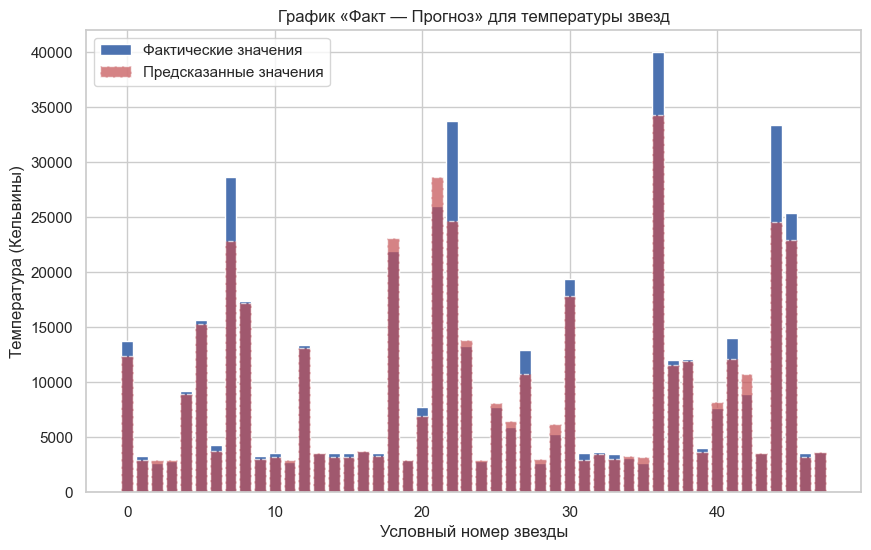

In [86]:
# Построение графика «Факт — Прогноз»
plt.figure(figsize=(10, 6))
plt.bar(range(len(y_test_real_inv)),y_test_real_inv, label='Фактические значения', color='b')
plt.bar(range(len(y_pred_real)),y_pred_real, label='Предсказанные значения', color='r', linestyle='--', alpha=0.7)
plt.xlabel('Условный номер звезды')
plt.ylabel('Температура (Кельвины)')
plt.title('График «Факт — Прогноз» для температуры звезд')
plt.legend()
plt.show()

## Оптимизация нейронной сети и анализ результатов

### Улучшенная модель
- **Лучшие параметры, найденные с помощью Optuna**: 
  - `dropout_rate`: 0.1066
  - `batch_size`: 8
  - `hidden_layer_size`: 512
  - `num_hidden_layers`: 4
  - `learning_rate`: 0.000235

- **Результаты модели**:
  - **RMSE на обучении**: 1516.11
  - **RMSE на тестовых данных**: 2337.38

### Сравнение моделей

| Модель             | Dropout Rate | Batch Size | Hidden Layer Size | Num Hidden Layers | Learning Rate | Train RMSE | Test RMSE |
|--------------------|--------------|------------|-------------------|-------------------|---------------|------------|-----------|
| Базовая модель     | 0.0          | 32         | 64                | 7                 | 0.001         | 5822.55    | 6400.00   |
| Улучшенная модель  | 0.1066       | 8          | 512               | 4                 | 0.000235      | 1516.11    | 2337.38   |

### Выводы
- Улучшенная модель, настроенная с использованием гиперпараметрической оптимизации, показала значительное снижение ошибки как на обучающей, так и на тестовой выборках по сравнению с базовой моделью.
- Применение `dropout` позволило уменьшить переобучение, а оптимизация параметров (размер батча, количество нейронов и слоев, скорость обучения) позволила достичь лучшего качества предсказаний.
- **RMSE на тесте для улучшенной модели** составил **2337.38**, что значительно ниже, чем у базовой модели, но все еще выше требуемого уровня в 4500.